# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics

## How to use this notebook

### Local installation

1. Install required packages with `pip install -r requirements.txt` to your desired environment.
2. If a script version of this notebook is desired, comment (not uncomment) the first line of `nbconvert` cell.

### Colab installation

1.  Comment (not uncomment) the first line of the drive mounting cell.
2.  Comment (not uncomment) the first line of the `pip install` cell.

<!-- - For colab we also want to set the runtime to GPU by clicking _Change runtime_ in the _Runtime_ menu, and -->
<!-- - We want to wait for the google drive connection popup to appear and follow the instructions. -->

### Loading / Generating data
3. Set `LOAD_DATA_FROM_CSV` to `True` / `False` to load data from csv files / generate data in this notebook.

### Training without optimization

4. Set `OPTIMIZE = False` in section _Constants and flags to set_.
5. Run the entire notebook.

### Training with optimization

4. Set `OPTIMIZE = True` in section _Constants and flags to set_.
5. Run the entire notebook.

### Loading an already trained model

4. Run cells in section _Initialization_.
5. Run cells with definitions in section _Input data and labels_.
6. Run cell with the definition of _Net_ in section _Defining the neural network_.
7. Make sure the `net.pth`, `optimizer.pth`, `scheduler.pth`, `var_dict.json` and `train_output.csv` files are in the directory containing this notebook.
8. Run the cells in section _Loading_ and continue from there.

### Generating the C++ model

9. Run section _Porting the model to C++_, this requires a model to be loaded.
10. Set the path to the `net.pt` file in the C++ source file.
11. `mkdir build && cd build`,
12. Configure a `CMakeLists.txt` file as is done [here](https://pytorch.org/cppdocs/installing.html).
13. `cmake -DCMAKE_PREFIX_PATH=/path/to/libtorch/ ..`,
14. Compile and run, e.g. `cmake --build . --config release && ./<executable name>`

## Initialization


Use this first cell to **convert this notebook** to a python script.

In [1]:
%%script echo skipping

!jupyter nbconvert GRMHD_ML.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on **google colab**,

In [2]:
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")
# change this to your desired folder
drive_folder = "/content/drive/My Drive/bsc/con2prim_GRMHD/1e5_runs/adjusted_layers"

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [3]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#%%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.5 MB/s eta 0:00:00


Importing the **libraries**,

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx
import pandas as pd

### Constants and flags to set
Defining some constants and parameters for convenience.

**NOTE**: Some **subparameters** still need to be adjusted in the `create_model` function itself as of (Tue May 16 07:42:45 AM CEST 2023) in the case the model is being trained without optimization.

In [6]:

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_TRIALS = 300 # Number of trials for hyperparameter optimization # NOTE: Set this properly.
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values. # NOTE: Set this properly.
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.
LOAD_DATA_FROM_CSV = False  # If not true we generate the data in this file and save to {x_train,y_train,x_test,y_test}.csv, otherwise we load the data from files of the same name. # NOTE: Set this before properly.

csv_filenames = { # File names to load input data and labels from if LOAD_DATA_FROM_CSV is True.
    "x_train": "x_train.csv",
    "x_val": "x_val.csv",
    "x_test": "x_test.csv",
    "y_train": "y_train.csv",
    "y_val": "y_val.csv",
    "y_test": "y_test.csv",
}

# Values to use for hyperparameters if OPTIMIZE is False; set these to the best parameters found by Optuna.
# NOTE: TODO: Currently (Sat May 27 05:16:57 PM CEST 2023) there are still subparameters to be set in create_model function.
N_LAYERS_NO_OPT = 3
N_UNITS_NO_OPT = [555, 458, 115]
HIDDEN_ACTIVATION_NAME_NO_OPT = "LeakyReLU"
OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
LOSS_NAME_NO_OPT = "Huber"
OPTIMIZER_NAME_NO_OPT = "RMSprop"
LR_NO_OPT = 0.000122770896701404
BATCH_SIZE_NO_OPT = 49
N_EPOCHS_NO_OPT = 500 # NOTE: Set this properly.
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"
DROPOUT_RATE_NO_OPT = 0.2

N_INPUTS = 14  # Number of input features.
N_OUTPUTS = 1  # Number of outputs.
Gamma = 5/3  # Adiabatic index

n_samples = 1e5 # NOTE: Set this properly.
train_frac = 0.7  # 70% of data for training
val_frac = 0.15  # 15% of data for validation, rest for testing

rho_interval = (0, 2) 
epsilon_interval = (1e-2, 2000)  # Will be sampled in log space
vx_interval = (0, 0.999)  
vy_interval = (0, 0.999)  
vz_interval = (0, 0.999)  
Bx_interval = (-10, 10)  
By_interval = (-10, 10)  
Bz_interval = (-10, 10)  
gxx_interval = (0.9, 1.1)
gxy_interval = (0, 0.1)
gxz_interval = (0, 0.1)
gyy_interval = (0.9, 1.1)
gyz_interval = (0, 0.1)
gzz_interval = (0.9, 1.1)

np.random.seed(70) # Comment for true random data.


## Input data and labels

We either generate the data or load the data. First the definitions for generating the data come below.

In [7]:
# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    # Adding some assertions to check that the input tensors are valid and have 
    # the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    print('rho.shape: ', rho.shape)
    print('epsilon.shape: ', epsilon.shape)
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (Gamma - 1) * rho * epsilon

def sample_primitive_variables_and_metric():
    rho = np.random.uniform(*rho_interval)  
    epsilon = np.random.uniform(*np.log10(epsilon_interval))
    vx = np.random.uniform(*vx_interval)  
    vy = np.random.uniform(*vy_interval)  
    vz = np.random.uniform(*vz_interval)  
    Bx = np.random.uniform(*Bx_interval)  
    By = np.random.uniform(*By_interval)  
    Bz = np.random.uniform(*Bz_interval)  
    gxx = np.random.uniform(*gxx_interval)
    gxy = np.random.uniform(*gxy_interval)
    gxz = np.random.uniform(*gxz_interval)
    gyy = np.random.uniform(*gyy_interval)
    gyz = np.random.uniform(*gyz_interval)
    gzz = np.random.uniform(*gzz_interval)

    return rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz

def check_sample(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    wtemp_expr = 1 - (gxx * vx**2 + gyy * vy**2 + gzz * vz**2 + 2 * gxy * vx * vy + 2 * gxz * vx * vz + 2 * gyz * vy * vz)
    sdet_expr = gxx * gyy * gzz + 2 * gxy * gxz * gyz - gxx * gyz ** 2 - gyy * gxz ** 2 - gzz * gxy ** 2
    if vx**2 + vy**2 + vz**2 >= 1 or wtemp_expr < 0 or sdet_expr < 0:
        # print(f"Sample failed checks. vx^2+vy^2+vz^2: {vx**2 + vy**2 + vz**2}, wtemp_expr: {wtemp_expr}, sdet_expr: {sdet_expr}")
        return False
    else:
        # print(f"Sample passed checks. vx^2+vy^2+vz^2: {vx**2 + vy**2 + vz**2}, wtemp_expr: {wtemp_expr}, sdet_expr: {sdet_expr}")
        return True

def generate_samples(n_samples):
    samples = []
    while len(samples) < n_samples:
        sample = sample_primitive_variables_and_metric()
        if check_sample(*sample):
            samples.append(sample)
        # print(f"Number of valid samples: {len(samples)}")
    return zip(*samples)
def sdet(gxx, gxy, gxz, gyy, gyz, gzz):
    # Determinant of the three metric.
    return (gxx * gyy * gzz + 2 * gxy * gxz * gyz - gxx * gyz ** 2 - gyy * gxz ** 2 - gzz * gxy ** 2) ** 0.5

# Defining a function that computes conserved variables from primitive variables and the metric
# We follow the source code of GRaM-X: A new GPU-accelerated dynamical spacetime GRMHD code for Exascale
# computing with the Einstein Toolkit of Shankar et al.
def compute_conserved_variables(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    pres = eos_analytic(rho, epsilon)
    wtemp = 1 / (1 - (gxx * vx**2 + gyy * vy**2 + gzz * vz**2 +
        2 * gxy * vx * vy + 2 * gxz * vx * vz +
        2 * gyz * vy * vz))**0.5

    vlowx = gxx * vx + gxy * vy + gxz * vz
    vlowy = gxy * vx + gyy * vy + gyz * vz
    vlowz = gxz * vx + gyz * vy + gzz * vz

    Bxlow = gxx * Bx + gxy * By + gxz * Bz
    Bylow = gxy * Bx + gyy * By + gyz * Bz
    Bzlow = gxz * Bx + gyz * By + gzz * Bz

    B2 = Bxlow * Bx + Bylow * By + Bzlow * Bz

    Bdotv = Bxlow * vx + Bylow * vy + Bzlow * vz
    Bdotv2 = Bdotv * Bdotv
    wtemp2 = wtemp * wtemp
    b2 = B2 / wtemp2 + Bdotv2
    ab0 = wtemp * Bdotv

    blowx = (gxx * Bx + gxy * By + gxz * Bz) / wtemp + wtemp * Bdotv * vlowx
    blowy = (gxy * Bx + gyy * By + gyz * Bz) / wtemp + wtemp * Bdotv * vlowy
    blowz = (gxz * Bx + gyz * By + gzz * Bz) / wtemp + wtemp * Bdotv * vlowz

    hrhow2 = (rho * (1 + epsilon) + pres + b2) * (wtemp) * (wtemp)

    D = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * rho * (wtemp)
    Sx = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowx - ab0 * blowx)
    Sy = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowy - ab0 * blowy)
    Sz = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowz - ab0 * blowz)
    tau = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 - pres - b2 / 2 - ab0 * ab0) - D
    Bconsx = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * Bx
    Bconsy = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * By
    Bconsz = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * Bz

    return D, Sx, Sy, Sz, tau, Bconsx, Bconsy, Bconsz

def generate_input_data(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    rho = torch.tensor(np.array(rho), dtype=torch.float32).to(device)
    epsilon = torch.tensor(np.array(epsilon), dtype=torch.float32).to(device)
    vx = torch.tensor(np.array(vx), dtype=torch.float32).to(device)
    vy = torch.tensor(np.array(vy), dtype=torch.float32).to(device)
    vz = torch.tensor(np.array(vz), dtype=torch.float32).to(device)
    Bx = torch.tensor(np.array(Bx), dtype=torch.float32).to(device)
    By = torch.tensor(np.array(By), dtype=torch.float32).to(device)
    Bz = torch.tensor(np.array(Bz), dtype=torch.float32).to(device)
    gxx = torch.tensor(np.array(gxx), dtype=torch.float32).to(device)
    gxy = torch.tensor(np.array(gxy), dtype=torch.float32).to(device)
    gxz = torch.tensor(np.array(gxz), dtype=torch.float32).to(device)
    gyy = torch.tensor(np.array(gyy), dtype=torch.float32).to(device)
    gyz = torch.tensor(np.array(gyz), dtype=torch.float32).to(device)
    gzz = torch.tensor(np.array(gzz), dtype=torch.float32).to(device)

    D, Sx, Sy, Sz, tau, Bscriptx, Bscripty, Bscriptz = compute_conserved_variables(
        rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz
    ) 

    # Add gxx, gxy, gxz, gyy, gyz, gzz to the tensor
    x = torch.stack([D, Sx, Sy, Sz, tau, Bscriptx, Bscripty, Bscriptz, gxx, gxy, gxz, gyy, gyz, gzz], axis=1)
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
# We use the definitions as given in Recovery schemes for primitive variables in
# general-relativistic magnetohydrodynamics of Siegel et al.
def generate_labels(rho, epsilon, vx, vy, vz):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(np.array(rho), dtype=torch.float32).to(device)
    epsilon = torch.tensor(np.array(epsilon), dtype=torch.float32).to(device)
    vx = torch.tensor(np.array(vx), dtype=torch.float32).to(device)
    vy = torch.tensor(np.array(vy), dtype=torch.float32).to(device)
    vz = torch.tensor(np.array(vz), dtype=torch.float32).to(device)

    # Computing the required quantities
    pres = eos_analytic(rho, epsilon)
    h = 1 + epsilon + pres / rho
    W = 1 / torch.sqrt(1 - (vx * vx + vy * vy + vz * vz))

    # Returning the output data tensor
    return h * W

### Generating or loading input data and labels

In [8]:
%config InteractiveShell.ast_node_interactivity = "all"

In [9]:
if LOAD_DATA_FROM_CSV:
    # Load the data from CSV files
    x_train = pd.read_csv(csv_filenames["x_train"]).values
    y_train = pd.read_csv(csv_filenames["y_train"]).values.squeeze()  # reshape to 1D
    x_val = pd.read_csv(csv_filenames["x_val"]).values
    y_val = pd.read_csv(csv_filenames["y_val"]).values.squeeze()  # reshape to 1D
    x_test = pd.read_csv(csv_filenames["x_test"]).values
    y_test = pd.read_csv(csv_filenames["y_test"]).values.squeeze()  # reshape to 1D

    # Convert numpy arrays to tensors
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    x_val = torch.from_numpy(x_val).float().to(device)
    y_val = torch.from_numpy(y_val).float().to(device)
    x_test = torch.from_numpy(x_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)

    # This is an alternative to having if clauses around the cells that visualize these variables.
    rho = epsilon = vx = vy = vz = Bx = By = Bz = gxx = gxy = gxz = gyy = gyz  = gzz = None

In [10]:
if not LOAD_DATA_FROM_CSV:
    # Sample primitive variables and metric
    rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz = generate_samples(n_samples)

In [11]:
if not LOAD_DATA_FROM_CSV:
    # Generate data and labels.
    x = generate_input_data(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz)
    y = generate_labels(rho, epsilon, vx, vy, vz)

    # Calculate the number of samples in each set
    n_train_samples = int(n_samples * train_frac)
    n_val_samples = int(n_samples * val_frac)

    # Create the data sets
    x_train = x[:n_train_samples]
    y_train = y[:n_train_samples]
    x_val = x[n_train_samples : n_train_samples + n_val_samples]
    y_val = y[n_train_samples : n_train_samples + n_val_samples]
    x_test = x[n_train_samples + n_val_samples :]
    y_test = y[n_train_samples + n_val_samples :]

    # Save the data to CSV files; tensors need to be converted numpy arrays for saving in CSV.
    pd.DataFrame(x_train.cpu().numpy()).to_csv(csv_filenames["x_train"], index=False)
    save_file(csv_filenames["x_train"])
    pd.DataFrame(y_train.cpu().numpy()).to_csv(csv_filenames["y_train"], index=False)
    save_file(csv_filenames["y_train"])

    pd.DataFrame(x_val.cpu().numpy()).to_csv(csv_filenames["x_val"], index=False)
    save_file(csv_filenames["x_val"])
    pd.DataFrame(y_val.cpu().numpy()).to_csv(csv_filenames["y_val"], index=False)
    save_file(csv_filenames["y_val"])

    pd.DataFrame(x_test.cpu().numpy()).to_csv(csv_filenames["x_test"], index=False)
    save_file(csv_filenames["x_test"])
    pd.DataFrame(y_test.cpu().numpy()).to_csv(csv_filenames["y_test"], index=False)
    save_file(csv_filenames["y_test"])

rho.shape:  torch.Size([100000])
epsilon.shape:  torch.Size([100000])
rho.shape:  torch.Size([100000])
epsilon.shape:  torch.Size([100000])


In [12]:

x_train.shape
y_train.shape
x_val.shape
y_val.shape
x_test.shape
y_test.shape
x_train
y_train
x_val
y_val
x_test
y_test

torch.Size([70000, 14])

torch.Size([70000])

torch.Size([15000, 14])

torch.Size([15000])

torch.Size([15000, 14])

torch.Size([15000])

tensor([[ 1.5052e-01,  6.9911e+01,  5.2254e+01,  ...,  9.0098e-01,
          7.8799e-02,  1.0349e+00],
        [ 1.6257e+00, -1.2595e+00,  8.2978e+00,  ...,  1.0485e+00,
          9.2982e-02,  9.0812e-01],
        [ 1.3144e+00,  1.9456e+01,  2.0009e+01,  ...,  1.0516e+00,
          5.2514e-02,  9.3525e-01],
        ...,
        [ 4.8502e+00,  3.0509e+01,  2.1219e+00,  ...,  1.0638e+00,
          2.5240e-02,  9.7035e-01],
        [ 2.0783e-01,  3.4716e+01,  1.7203e+01,  ...,  1.0622e+00,
          3.9270e-02,  9.8392e-01],
        [ 2.8773e+00, -3.8148e+00,  3.9378e+01,  ...,  1.0583e+00,
          3.7270e-02,  9.6673e-01]], device='cuda:0')

tensor([ 6.2784, -0.7416,  2.3403,  ..., -4.3545,  2.3844,  7.8899],
       device='cuda:0')

tensor([[ 1.7930e+00,  4.8936e+01,  5.1299e+01,  ...,  9.0994e-01,
          9.5550e-02,  9.1821e-01],
        [ 1.7003e+00, -7.2934e+00,  5.1039e+00,  ...,  9.1014e-01,
          9.0360e-02,  1.0498e+00],
        [ 1.2915e+00,  1.1420e+01, -1.5463e+01,  ...,  1.0101e+00,
          2.3252e-02,  9.8472e-01],
        ...,
        [ 1.5920e+00,  2.5180e+01,  1.4149e+01,  ...,  9.3743e-01,
          4.7283e-02,  1.0395e+00],
        [ 8.3691e-01, -7.8790e+00,  3.0667e+01,  ...,  9.9888e-01,
          9.2545e-02,  9.2777e-01],
        [ 1.7245e+00, -1.1318e+01,  1.3903e+01,  ...,  9.3182e-01,
          5.8519e-02,  9.6224e-01]], device='cuda:0')

tensor([ 7.8535, -0.0869,  0.9857,  ...,  1.4526,  9.4270,  7.3892],
       device='cuda:0')

tensor([[ 2.7066e+00,  7.2318e+01, -2.8853e+01,  ...,  9.8857e-01,
          4.1255e-02,  1.0451e+00],
        [ 2.1383e+00,  2.8131e+01,  6.9616e+01,  ...,  1.0613e+00,
          8.2385e-02,  1.0892e+00],
        [ 7.4486e-01,  8.1011e+01, -2.6955e+01,  ...,  9.1635e-01,
          1.1930e-02,  1.0935e+00],
        ...,
        [ 1.2719e+00,  4.0807e+00, -5.5112e-01,  ...,  1.0575e+00,
          3.0295e-02,  9.0798e-01],
        [ 1.7500e+00, -1.1416e+01,  2.5838e+01,  ...,  1.0783e+00,
          1.3951e-02,  9.5195e-01],
        [ 2.1329e+00, -8.5996e+00,  2.4396e+01,  ...,  9.2411e-01,
          4.0945e-02,  9.7228e-01]], device='cuda:0')

tensor([ 8.9882,  4.2383, 10.0341,  ...,  3.0453,  0.9038, -2.2624],
       device='cuda:0')

In [13]:
torch.isnan(x_train).any()
torch.isnan(x_val).any()
torch.isnan(x_test).any()
torch.isnan(y_train).any()
torch.isnan(y_val).any()
torch.isnan(y_test).any()

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

In [14]:
nan_mask_train = torch.isnan(x_train)     # get a boolean mask indicating NaN values
nan_indices_train = torch.where(nan_mask_train)  # get the indices of the NaN values
nan_indices_train
# len(nan_indices_train)

nan_mask_val = torch.isnan(x_val)     # get a boolean mask indicating NaN values
nan_indices_val = torch.where(nan_mask_val)  # get the indices of the NaN values
nan_indices_val
# len(nan_indices_test)

nan_mask_test = torch.isnan(x_test)     # get a boolean mask indicating NaN values
nan_indices_test = torch.where(nan_mask_test)  # get the indices of the NaN values
nan_indices_test
# len(nan_indices_test)

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

## Visualizing the data

### Visualizing sampled data

In [15]:
%%script echo skipping

if not LOAD_DATA_FROM_CSV:
    rho
    epsilon
    vx
    vy
    vz 
    Bx
    By
    Bz
    gxx
    gxy
    gxz
    gyy
    gyz
    gzz 

skipping


In [16]:
if not LOAD_DATA_FROM_CSV:
    print(len(rho))
    print(len(epsilon))
    print(len(vx))
    print(len(vy))
    print(len(vz))
    print(len(Bx))
    print(len(By))
    print(len(Bz))
    print()
    print(len(gxx))
    print(len(gxy))
    print(len(gxz))
    print(len(gyy))
    print(len(gyz))
    print(len(gzz))

100000
100000
100000
100000
100000
100000
100000
100000

100000
100000
100000
100000
100000
100000


In [17]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [18]:
%%script echo skipping

plt.hist([np.random.uniform(0, 0.999) for _ in range(n_train_samples)], bins=20)

skipping


In [19]:
%%script echo skipping

epsilon

skipping


The reason the sampling is not uniformly distributed in the following plots is due to the resampling and the fact that we certain values of e.g. velocity are more likely to violate the speed of light constraint than others.

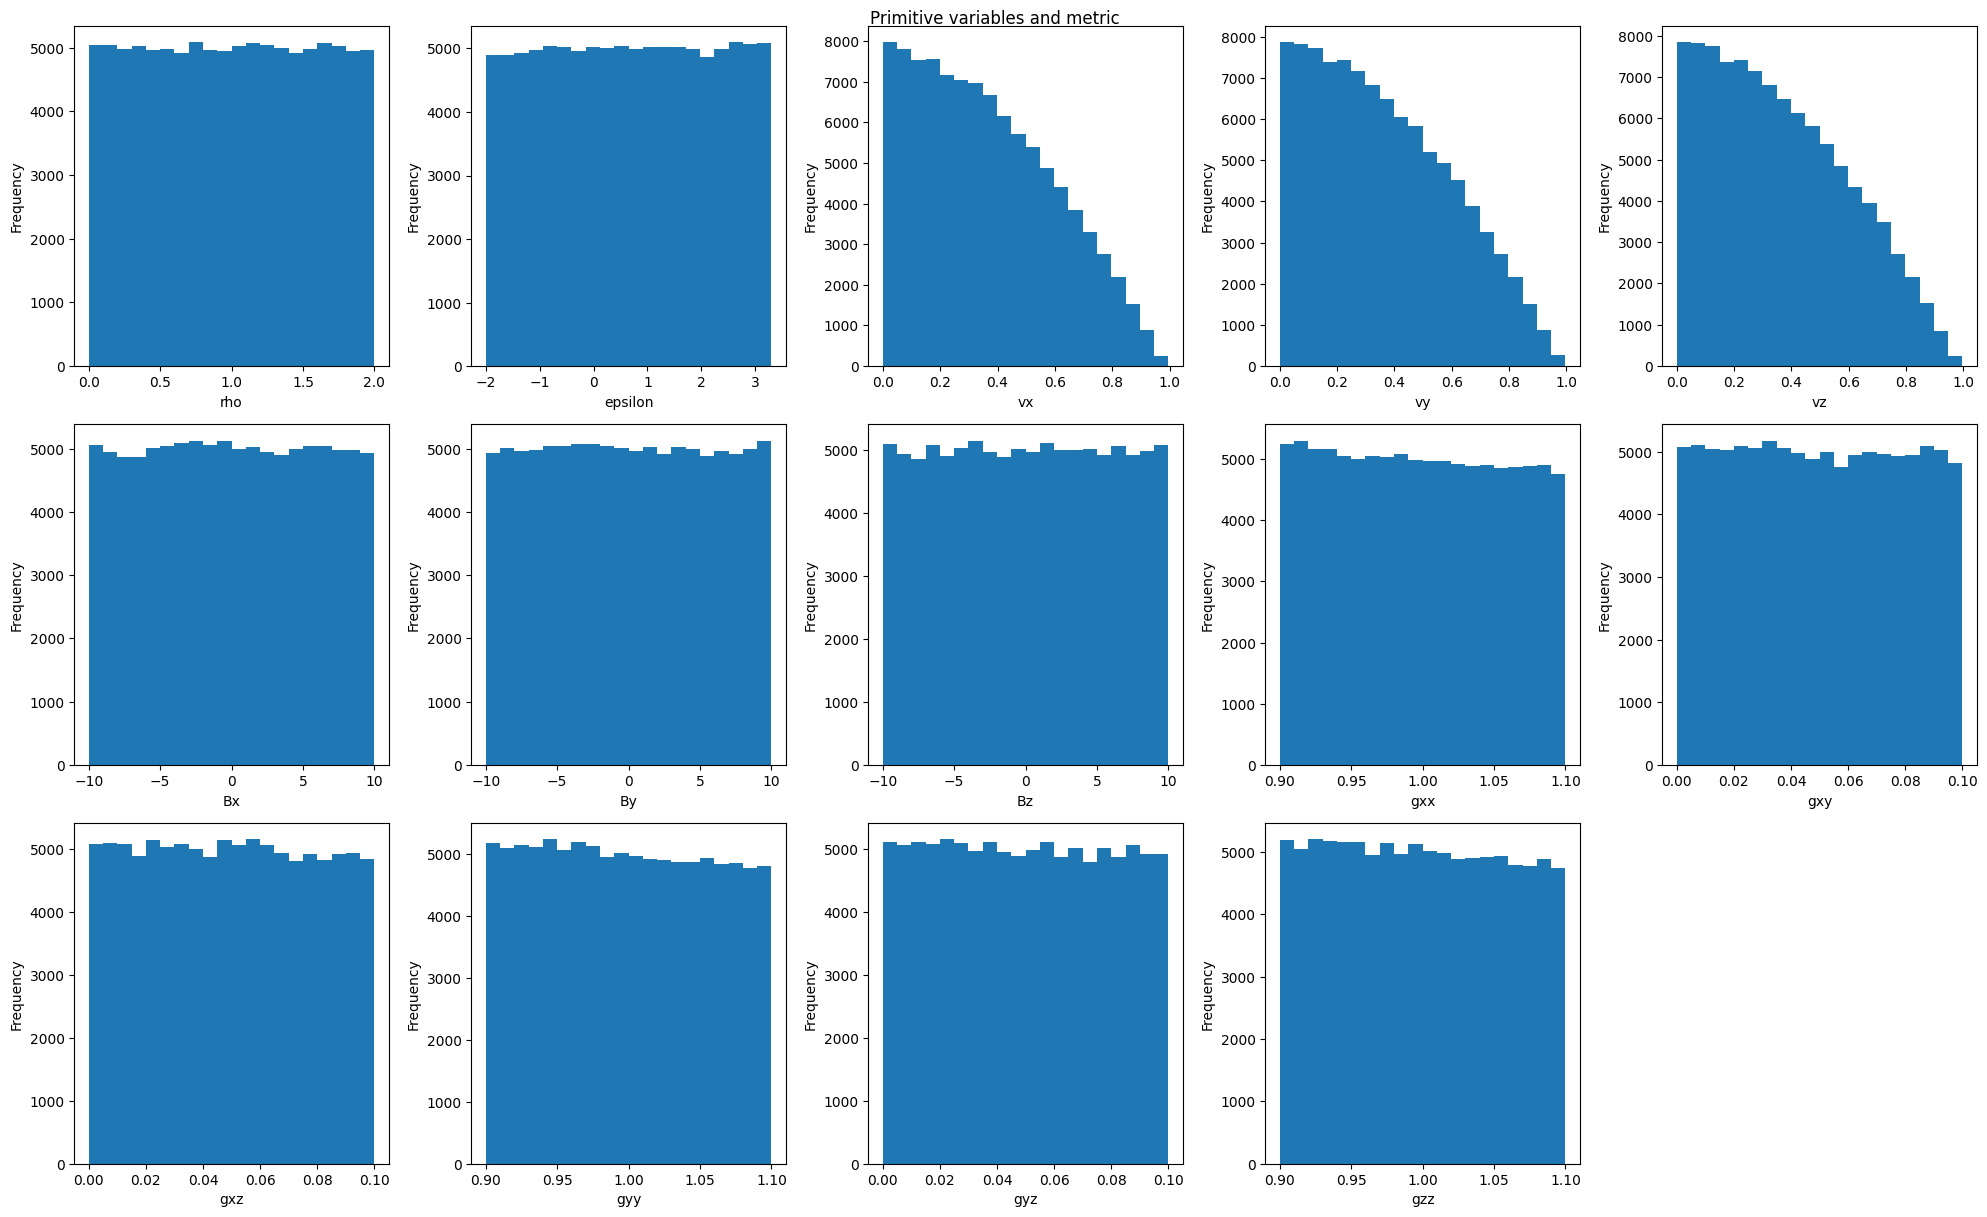

In [20]:
#%%script echo skipping

if not LOAD_DATA_FROM_CSV:
    def plot_histogram(data, xlabel, ylabel, position, bins=20, xlog_scale=False, ylog_scale=False):
        plt.subplot(4, 5, position)
        plt.hist(data, bins=bins)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if xlog_scale: # Setting does not work expected for epsilon.
            plt.xscale("log")
        if ylog_scale: # Setting does not work expected for epsilon.
            plt.yscale("log")

    # Plotting the histograms of rho, vx, epsilon, b0, b1, b2, and b3
    bins = 20
    plt.figure(figsize=(20, 16))

    plot_histogram(rho, "rho", "Frequency", 1, bins=bins)
    plot_histogram(epsilon, "epsilon", "Frequency", 2, bins=bins)
    plot_histogram(vx, "vx", "Frequency", 3, bins=bins)
    plot_histogram(vy, "vy", "Frequency", 4, bins=bins)
    plot_histogram(vz, "vz", "Frequency", 5, bins=bins)
    plot_histogram(Bx, "Bx", "Frequency", 6, bins=bins)
    plot_histogram(By, "By", "Frequency", 7, bins=bins)
    plot_histogram(Bz, "Bz", "Frequency", 8, bins=bins)

    # Plot these
    plot_histogram(gxx, "gxx", "Frequency", 9, bins=bins)
    plot_histogram(gxy, "gxy", "Frequency", 10, bins=bins)
    plot_histogram(gxz, "gxz", "Frequency", 11, bins=bins)
    plot_histogram(gyy, "gyy", "Frequency", 12, bins=bins)
    plot_histogram(gyz, "gyz", "Frequency", 13, bins=bins)
    plot_histogram(gzz, "gzz", "Frequency", 14, bins=bins)


    plt.suptitle("Primitive variables and metric")
    plt.tight_layout()
    plt.show()


In [21]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

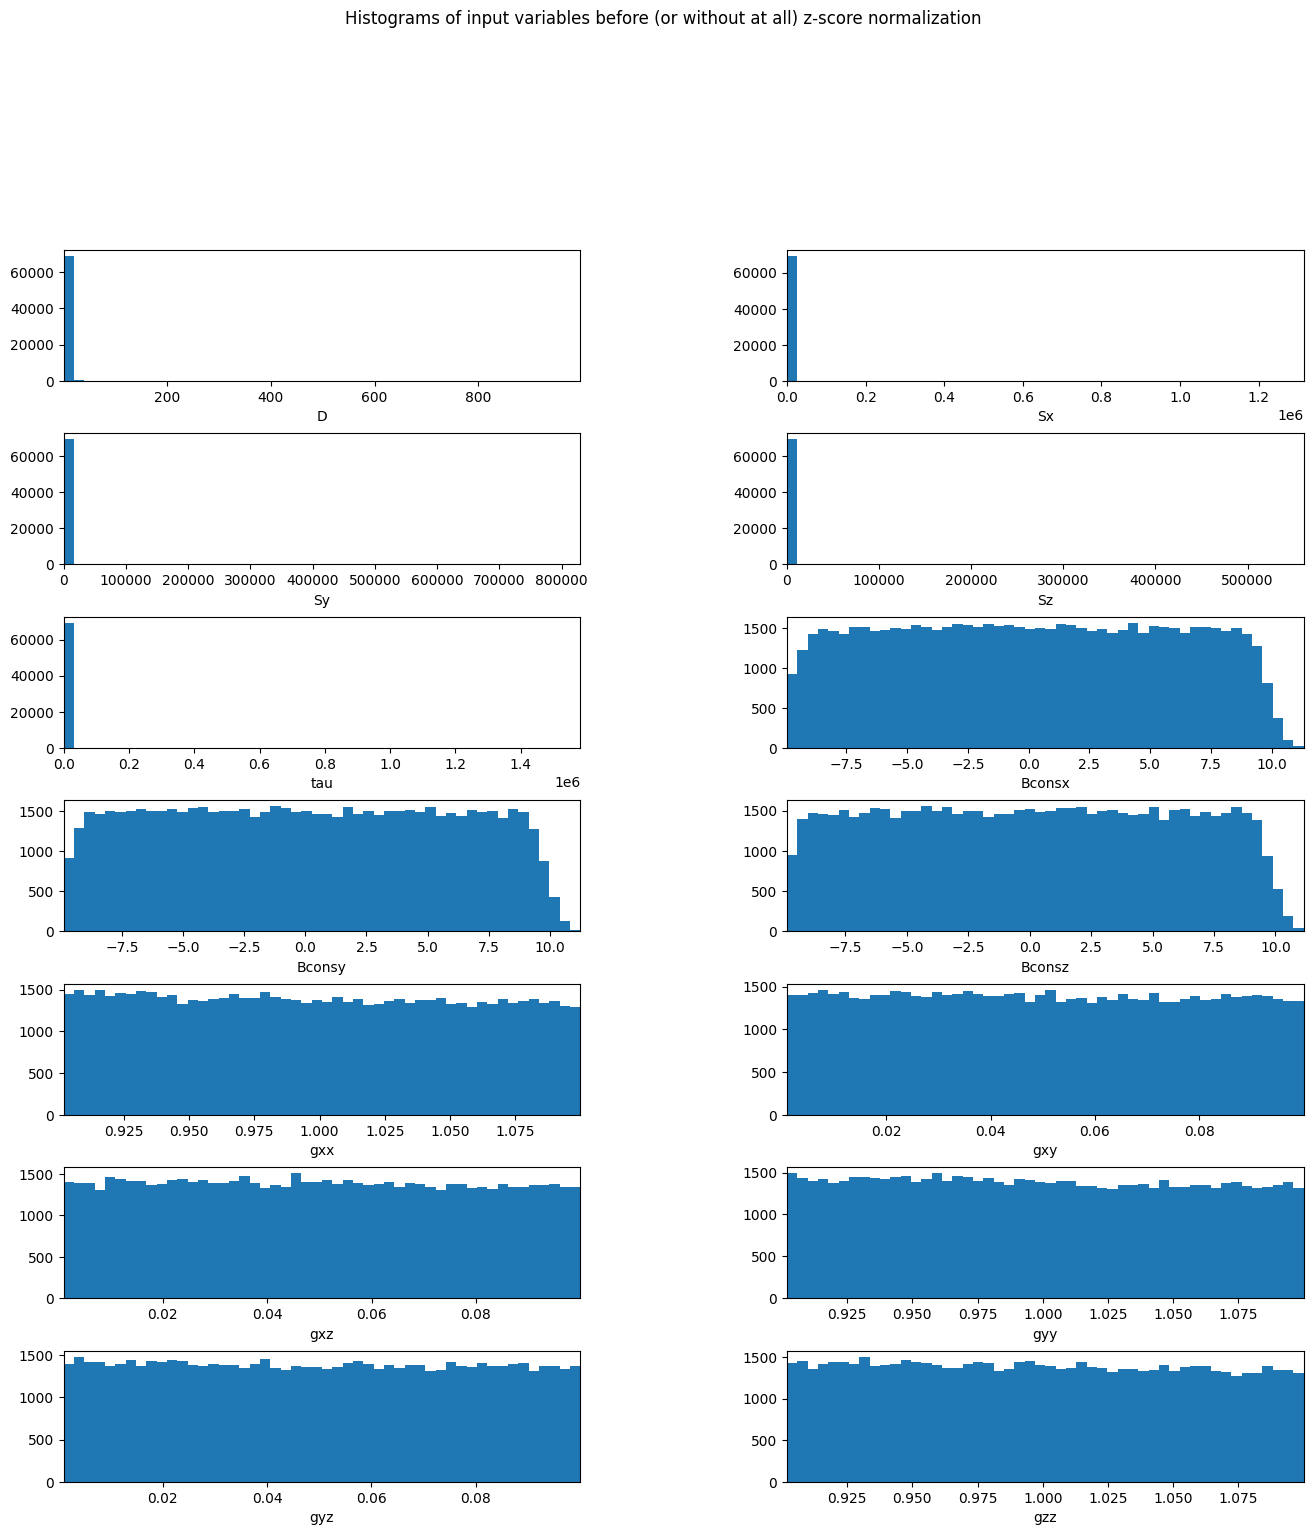

In [22]:
#%%script echo skipping

# Variable names
variable_names = ["D", "Sx", "Sy", "Sz", "tau", "Bconsx", "Bconsy", "Bconsz", "gxx", "gxy", "gxz", "gyy", "gyz", "gzz"]

# Plotting histograms of the input variables before z-score normalization
plt.figure(figsize=(16, 16))
plt.suptitle('Histograms of input variables before (or without at all) z-score normalization', y=1.03)

for i in range(N_INPUTS):
    plt.subplot(7, 2, i+1)
    data = x_train[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
    lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
    # lower_bound, upper_bound = np.percentile(data, [1, 90]) # Calculate 1st and 99th percentile

    plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
    plt.xlabel(variable_names[i])
    plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

# Same plotting but for the test data. Adjust the percentile range as needed to zoom in.
# plt.figure(figsize=(16, 16))
# plt.suptitle('Histograms of input variables before (or without at all) z-score normalization (test data)', y=1.03)

# for i in range(14):
#     plt.subplot(7, 2, i+1)
#     data = x_test[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
#     #lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
#     lower_bound, upper_bound = np.percentile(data, [1, 99]) # Use this to zoom in.

#     plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
#     plt.xlabel(variable_names[i])
#     plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

# plt.subplots_adjust(hspace=0.4, wspace=0.4)
# plt.show()



### Data normalization

In [23]:
# Computing summary statistics of the input variables before and after z-score normalization
print('Summary statistics of input variables before z-score normalization')
print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.nanmean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))

Summary statistics of input variables before z-score normalization
tensor([[ 2.0024e-05,  9.9682e+02,  2.3061e+00,  1.6714e+00,  5.8270e+00],
        [-5.1120e+03,  1.3142e+06,  6.3277e+01,  2.1865e+01,  5.1805e+03],
        [-1.5425e+04,  8.3010e+05,  5.5830e+01,  2.1914e+01,  3.3563e+03],
        [-1.7470e+04,  5.6085e+05,  5.0029e+01,  2.1745e+01,  2.2571e+03],
        [-2.3578e+04,  1.5822e+06,  1.2388e+02,  6.9362e+01,  6.2928e+03],
        [-1.1311e+01,  1.1307e+01,  1.0330e-02, -2.1675e-02,  5.7146e+00],
        [-1.1104e+01,  1.1247e+01, -6.2518e-03, -4.1105e-02,  5.7258e+00],
        [-1.1193e+01,  1.1151e+01,  9.4145e-03,  2.7754e-02,  5.7318e+00],
        [ 9.0000e-01,  1.1000e+00,  9.9834e-01,  9.9754e-01,  5.7876e-02],
        [ 9.5162e-07,  1.0000e-01,  4.9569e-02,  4.9252e-02,  2.8891e-02],
        [ 2.1062e-06,  1.0000e-01,  4.9584e-02,  4.9342e-02,  2.8787e-02],
        [ 9.0000e-01,  1.1000e+00,  9.9848e-01,  9.9727e-01,  5.7751e-02],
        [ 1.5818e-06,  9.9998e-02

Perform z-score normalization

In [24]:
%config InteractiveShell.ast_node_interactivity = "all"

In [25]:
if ZSCORE_NORMALIZATION:
    
    # TODO: Add magnetic field variables to the normalization if I decide to use the old code that is commented out here.
    # # Computing the median of each input variable from the training set using torch.nanmedian function
    # D_median = torch.nanmedian(x_train[:, 0])
    # Sx_median = torch.nanmedian(x_train[:, 1])
    # Sy_median = torch.nanmedian(x_train[:, 2])
    # Sz_median = torch.nanmedian(x_train[:, 3])
    # tau_median = torch.nanmedian(x_train[:, 4])

    # # Computing the standard deviation of each input variable from the training set using torch.std function with a boolean mask to ignore nan values
    # D_std = torch.std(x_train[~torch.isnan(x_train[:, 0]), 0])
    # Sx_std = torch.std(x_train[~torch.isnan(x_train[:, 1]), 1])
    # Sy_std = torch.std(x_train[~torch.isnan(x_train[:, 2]), 2])
    # Sz_std = torch.std(x_train[~torch.isnan(x_train[:, 3]), 3])
    # tau_std = torch.std(x_train[~torch.isnan(x_train[:, 4]), 4])


    # # Applying z-score normalization to both train and test sets using the statistics from the training set
    # x_train[:, 0] = torch.sub(x_train[:, 0], D_median).div(D_std)
    # x_train[:, 1] = torch.sub(x_train[:, 1], Sx_median).div(Sx_std)
    # x_train[:, 2] = torch.sub(x_train[:, 2], Sy_median).div(Sy_std)
    # x_train[:, 3] = torch.sub(x_train[:, 3], Sz_median).div(Sz_std)
    # x_train[:, 4] = torch.sub(x_train[:, 4], tau_median).div(tau_std)

    # x_test[:, 0] = torch.sub(x_test[:, 0], D_median).div(D_std)
    # x_test[:, 1] = torch.sub(x_test[:, 1], Sx_median).div(Sx_std)
    # x_test[:, 2] = torch.sub(x_test[:, 2], Sy_median).div(Sy_std)
    # x_test[:, 3] = torch.sub(x_test[:, 3], Sz_median).div(Sz_std)
    # x_test[:, 4] = torch.sub(x_test[:, 4], tau_median).div(tau_std)

    # Computing the mean and standard deviation of each column
    mean = x_train.mean(dim=0)
    std = x_train.std(dim=0)

    # Applying z-score normalization
    x_train = (x_train - mean) / std
    # Use the same mean and std from the training data as we don't want test data leakage.
    x_test = (x_test - mean) / std



Plotting the histograms of the input data after normalization if z-score normalization was performed.

In [26]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [27]:
if not LOAD_DATA_FROM_CSV:
    if ZSCORE_NORMALIZATION:
        # Variable names
        variable_names = ["D", "Sx", "Sy", "Sz", "tau", "Bconsx", "Bconsy", "Bconsz", "gxx", "gxy", "gxz", "gyy", "gyz", "gzz"]

        # Plotting histograms of the input variables before z-score normalization
        plt.figure(figsize=(16, 16))
        plt.suptitle('Histograms of input variables before (or without at all) z-score normalization', y=1.03)

        for i in range(N_INPUTS):
            plt.subplot(7, 2, i+1)
            data = x_train[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
            lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
            # lower_bound, upper_bound = np.percentile(data, [1, 90]) # Calculate 1st and 99th percentile

            plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
            plt.xlabel(variable_names[i])
            plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()

In [28]:
if ZSCORE_NORMALIZATION:
    # Computing summary statistics of the input variables after z-score normalization
    print('Summary statistics of input variables after z-score normalization')
    print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.mean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))


### Visualizing input data and labels

In [29]:
x_train
y_train
x_val
y_val
x_test
y_test

tensor([ 8.9882,  4.2383, 10.0341,  ...,  3.0453,  0.9038, -2.2624],
       device='cuda:0')

Checking if our output is always positive ~~by plotting a histogram of y_train and y_test tensors~~

In [30]:
import torch

# Create a sample tensor
tensor = torch.randn(80000, 14)  # Assuming a tensor of shape [80000, 14]
tensor


# Check if any element is negative
any_negative = torch.any(tensor < 0)

# Print the result
print(any_negative)


tensor(True)


In [31]:
y_train.shape
any_negative = torch.any(y_train < 0)
any_negative

y_test.shape
any_negative = torch.any(y_test < 0)
any_negative

x_train.shape
any_negative = torch.any(x_train < 0)
any_negative

tensor(True, device='cuda:0')

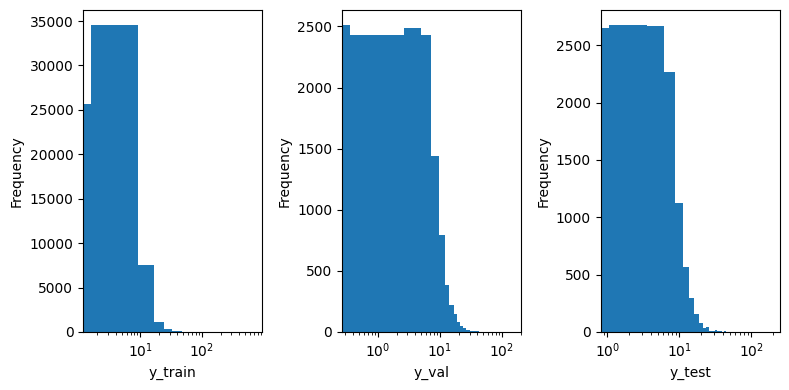

In [32]:
#%%script echo skipping

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.hist(y_train.cpu().numpy(), bins=100) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.xscale("log")
plt.subplot(1, 3, 2)
plt.hist(y_val.cpu().numpy(), bins=100) # must be cpu here
plt.xlabel("y_val")
plt.ylabel("Frequency")
plt.xscale("log")
plt.tight_layout()
plt.subplot(1, 3, 3)
plt.hist(y_test.cpu().numpy(), bins=100) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.xscale("log")
plt.tight_layout()
plt.show()


In [33]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [34]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation, dropout_rate):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
            TODO: [ver. Copilot description] dropout_rate (float): The dropout rate to use for all layers.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.dropout_rate = dropout_rate

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        self.layers.append(nn.Linear(N_INPUTS, n_units[0]))
        self.dropouts.append(nn.Dropout(p=dropout_rate))

        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
            self.dropouts.append(nn.Dropout(p=dropout_rate))

        self.layers.append(nn.Linear(n_units[-1], N_OUTPUTS))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, N_INPUTS).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, N_OUTPUTS).
        """
        # Adding an assertion to check that the input tensor has the expected shape and type
        assert isinstance(x, torch.Tensor), "x must be a torch.Tensor"
        assert x.shape[1] == N_INPUTS, f"x must have shape (batch_size, {N_INPUTS})"

        for layer, dropout in zip(self.layers[:-1], self.dropouts):
            x = dropout(self.hidden_activation(layer(x)))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x)) # No dropout at output layer

        return x # Returning the output tensor


In [35]:
%%script echo skipping

[1,2,3]
[1,2,3][:-1]

skipping


In [36]:
for x in [1,2,3][:-1]:
    print(x)



1
2


## Defining the model and search space

In [37]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
            dropout_rate is the dropout rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if OPTIMIZE:
        n_layers = trial.suggest_int("n_layers", 2, 6)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 4096) for i in range(n_layers)]

        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "PReLU", "Swish", "GELU", "SoftPlus"]
        )
        output_activation_name = trial.suggest_categorical( "output_activation", ["Linear"])

        loss_name = trial.suggest_categorical( "loss", ["MSE", "MAE", "Huber", "Quantile"]) 

        optimizer_name = trial.suggest_categorical( "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] )

        lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)

        batch_size_list = [32, 64, 128, 256, 512, 1024, 2048]
        batch_size = trial.suggest_categorical("batch_size", batch_size_list)
        
        n_epochs = trial.suggest_int("n_epochs", 50, 150)

        # scheduler_name = trial.suggest_categorical("scheduler", ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "CyclicLR"])
        scheduler_name = trial.suggest_categorical("scheduler", ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR"])

        # Creating the activation functions from their names
        if hidden_activation_name == "ReLU":
            hidden_activation = nn.ReLU()
        elif hidden_activation_name == "LeakyReLU":
            negative_slope = trial.suggest_uniform("leakyrelu_slope", 0.01, 0.3)
            hidden_activation = nn.LeakyReLU(negative_slope=negative_slope)
        elif hidden_activation_name == "ELU":
            hidden_activation = nn.ELU() 
        elif hidden_activation_name == "PReLU":
            init = trial.suggest_uniform("prelu_init", 0.1, 0.3)
            hidden_activation = nn.PReLU(init=init)
        elif hidden_activation_name == "Swish":
            class Swish(nn.Module):
                def forward(self, x):
                    return x * torch.sigmoid(x)
            hidden_activation = Swish()
        elif hidden_activation_name == "GELU":
            hidden_activation = nn.GELU()
        elif hidden_activation_name == "SoftPlus":
            beta = trial.suggest_uniform("softplus_beta", 0.5, 1.5)
            hidden_activation = nn.Softplus(beta=beta) # We don't optimize thresshold subparameters, as it's mainly for numerical stability.

        dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)


    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT

        # Creating the activation functions from their names
        if hidden_activation_name == "ReLU":
            hidden_activation = nn.ReLU()
        elif hidden_activation_name == "LeakyReLU":
            negative_slope = 0.01
            hidden_activation = nn.LeakyReLU(negative_slope=negative_slope)
        elif hidden_activation_name == "ELU":
            hidden_activation = nn.ELU() 
        elif hidden_activation_name == "PReLU":
            init = 0.25
            hidden_activation = nn.PReLU(init=init)
        elif hidden_activation_name == "Swish":
            class Swish(nn.Module):
                def forward(self, x):
                    return x * torch.sigmoid(x)
            hidden_activation = Swish()
        elif hidden_activation_name == "GELU":
            hidden_activation = nn.GELU()
        elif hidden_activation_name == "SoftPlus":
            beta = 1
            hidden_activation = nn.Softplus(beta=beta) # We don't optimize threshold subparameter, as it's mainly for numerical stability.

        dropout_rate = DROPOUT_RATE_NO_OPT


    # We used to have options here, but since we have a regression problem with continuous output, we only use Linear.
    output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    elif loss_name == "Quantile":
        def quantile_loss(y_pred, y_true, q=0.5):
            e = y_pred - y_true
            return torch.mean(torch.max(q*e, (q-1)*e))
        loss_fn = quantile_loss
    else:
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(n_layers, n_units, hidden_activation, output_activation, dropout_rate).to(device)


    if OPTIMIZE:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.9, 0.999)
            beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.1, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            if n_epochs < 150:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
            elif n_epochs > 250:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.05, 0.1)
            else:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.2)

            T_max = int(n_epochs * t_max_fraction)
            eta_min = trial.suggest_loguniform("eta_min", 1e-7, 1e-2)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
        elif scheduler_name == "ReduceLROnPlateau":
            factor = trial.suggest_uniform("factor", 0.1, 0.5)
            patience = trial.suggest_int("patience", 5, 10)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        elif scheduler_name == "CyclicLR":
            base_lr = trial.suggest_loguniform("base_lr", 1e-6, 1e-2)
            max_lr = trial.suggest_loguniform("max_lr", 1e-4, 1)
            step_size_up = trial.suggest_int("step_size_up", 200, 2000)
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up)
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer)
        elif scheduler_name == "ReduceLROnPlateau":
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.18979341786654758, patience=11, threshold=0.0017197466122611932 #, min_lr=1e-6
                    )
        elif scheduler_name == "CyclicLR":
            # TODO: Change these appropriately.
            base_lr = 1e-6
            max_lr = 1e-4
            step_size_up = 200
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up)
        else:
            scheduler = None

    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr, dropout_rate




 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [38]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [39]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_loader, val_loader, test_loader, trial=None):
    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    val_losses = []
    test_losses = []
    train_metrics = []
    val_metrics = []
    test_metrics = []


    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        if val_loader is not None:
            net.eval()
            val_loss = 0.0
            val_l1_norm = 0.0
            val_linf_norm = 0.0

            with torch.no_grad():
                for x_batch, y_batch in val_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = net(x_batch)
                    loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)

                    val_loss += loss.item() * x_batch.size(0)
                    val_l1_norm += l1_norm.item() * x_batch.size(0)
                    val_linf_norm += linf_norm.item() * x_batch.size(0)

            val_loss /= len(val_loader.dataset)
            val_l1_norm /= len(val_loader.dataset)
            val_linf_norm /= len(val_loader.dataset)

            val_losses.append(val_loss)
            val_metrics.append(
                {
                    "l1_norm": val_l1_norm,
                    "linf_norm": val_linf_norm,
                }
            )

            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("L1 norm/val", val_l1_norm, epoch)
            writer.add_scalar("Linf norm/val", val_linf_norm, epoch)
            print(f"Epoch {epoch+1}/{n_epochs}.. Train loss: {train_loss:.3f}.. Val loss: {val_loss:.3f}.. Train L1 norm: {train_l1_norm:.3f}.. Val L1 norm: {val_l1_norm:.3f}.. Train Linf norm: {train_linf_norm:.3f}.. Val Linf norm: {val_linf_norm:.3f}")


            update_scheduler(scheduler, val_loss)

        if test_loader is not None:
            net.eval()
            test_loss = 0.0
            test_l1_norm = 0.0
            test_linf_norm = 0.0

            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = net(x_batch)
                    loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)

                    test_loss += loss.item() * x_batch.size(0)
                    test_l1_norm += l1_norm.item() * x_batch.size(0)
                    test_linf_norm += linf_norm.item() * x_batch.size(0)

            test_loss /= len(test_loader.dataset)
            test_l1_norm /= len(test_loader.dataset)
            test_linf_norm /= len(test_loader.dataset)

            test_losses.append(test_loss)
            test_metrics.append(
                {
                    "l1_norm": test_l1_norm,
                    "linf_norm": test_linf_norm,
                }
            )

            writer.add_scalar("Loss/test", test_loss, epoch)
            writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
            writer.add_scalar("Linf norm/test", test_linf_norm, epoch)
            print(f"Epoch {epoch+1}/{n_epochs}.. Train loss: {train_loss:.3f}.. Test loss: {test_loss:.3f}.. Train L1 norm: {train_l1_norm:.3f}.. Test L1 norm: {test_l1_norm:.3f}.. Train Linf norm: {train_linf_norm:.3f}.. Test Linf norm: {test_linf_norm:.3f}")


        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(val_l1_norm, epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, val_losses, test_losses, train_metrics, val_metrics, test_metrics


## The objective function and hyperparameter tuning

In [40]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial, optimize=True)

    # Create separate data loaders for training and validation
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_val, y_val), batch_size=batch_size
    )
    
    _, _, _, _, val_metrics, _ = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_loader, val_loader, None, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return val_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-30 09:05:51,437] A new study created in memory with name: no-name-59b8ef73-cfcb-46a9-92cf-c61821401b19
<ipython-input-37-46c28bc3cd67>:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
<ipython-input-37-46c28bc3cd67>:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
<ipython-input-37-46c28bc3cd67>:149: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1

Epoch 1/67.. Train loss: 4.232.. Val loss: 2.203.. Train L1 norm: 5.593.. Val L1 norm: 3.324.. Train Linf norm: 2366.777.. Val Linf norm: 2108.416
Epoch 2/67.. Train loss: 2.599.. Val loss: 2.171.. Train L1 norm: 3.077.. Val L1 norm: 4.063.. Train Linf norm: 1286.347.. Val Linf norm: 2963.569
Epoch 3/67.. Train loss: 2.662.. Val loss: 2.133.. Train L1 norm: 3.344.. Val L1 norm: 5.106.. Train Linf norm: 1339.539.. Val Linf norm: 3873.994
Epoch 4/67.. Train loss: 2.543.. Val loss: 2.151.. Train L1 norm: 3.616.. Val L1 norm: 3.841.. Train Linf norm: 1495.251.. Val Linf norm: 2589.204
Epoch 5/67.. Train loss: 2.508.. Val loss: 2.119.. Train L1 norm: 3.833.. Val L1 norm: 5.397.. Train Linf norm: 1915.492.. Val Linf norm: 4043.086
Epoch 6/67.. Train loss: 2.999.. Val loss: 2.131.. Train L1 norm: 3.973.. Val L1 norm: 5.207.. Train Linf norm: 1798.669.. Val Linf norm: 3832.523
Epoch 7/67.. Train loss: 2.800.. Val loss: 2.139.. Train L1 norm: 3.578.. Val L1 norm: 5.792.. Train Linf norm: 1776.5

[I 2023-05-30 09:09:57,286] Trial 0 finished with value: 5.534290602874756 and parameters: {'n_layers': 3, 'n_units_0': 3188, 'n_units_1': 3256, 'n_units_2': 3807, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'Quantile', 'optimizer': 'Adam', 'lr': 0.00017981620997771432, 'batch_size': 2048, 'n_epochs': 67, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.35423504032468195, 'weight_decay': 0.0022448600990482314, 'beta1': 0.9286063070068987, 'beta2': 0.9995182614024852, 'factor': 0.17894972425005018, 'patience': 5, 'threshold': 0.0010373206056663244}. Best is trial 0 with value: 5.534290602874756.


Epoch 67/67.. Train loss: 2.428.. Val loss: 2.096.. Train L1 norm: 3.689.. Val L1 norm: 5.534.. Train Linf norm: 1602.697.. Val Linf norm: 4528.319


<ipython-input-37-46c28bc3cd67>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
<ipython-input-37-46c28bc3cd67>:175: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  eta_min = trial.suggest_loguniform("eta_min", 1e-7, 1e-2)


Epoch 1/62.. Train loss: 33185.692.. Val loss: 51.551.. Train L1 norm: 2.144.. Val L1 norm: 2.763.. Train Linf norm: 592.374.. Val Linf norm: 1110.736
Epoch 2/62.. Train loss: 283.779.. Val loss: 53.695.. Train L1 norm: 2.054.. Val L1 norm: 2.613.. Train Linf norm: 554.599.. Val Linf norm: 1084.607
Epoch 3/62.. Train loss: 445.914.. Val loss: 51.593.. Train L1 norm: 2.068.. Val L1 norm: 3.241.. Train Linf norm: 563.280.. Val Linf norm: 1449.429
Epoch 4/62.. Train loss: 2306.827.. Val loss: 62.617.. Train L1 norm: 2.246.. Val L1 norm: 2.502.. Train Linf norm: 611.692.. Val Linf norm: 1053.939
Epoch 5/62.. Train loss: 370.896.. Val loss: 54.264.. Train L1 norm: 2.163.. Val L1 norm: 3.820.. Train Linf norm: 553.575.. Val Linf norm: 1856.268
Epoch 6/62.. Train loss: 499.361.. Val loss: 51.623.. Train L1 norm: 2.569.. Val L1 norm: 3.027.. Train Linf norm: 717.652.. Val Linf norm: 1394.568
Epoch 7/62.. Train loss: 2986.705.. Val loss: 340.753.. Train L1 norm: 2.394.. Val L1 norm: 3.283.. Tra

[I 2023-05-30 09:11:22,855] Trial 1 finished with value: 5.512236584854126 and parameters: {'n_layers': 3, 'n_units_0': 1807, 'n_units_1': 1520, 'n_units_2': 1621, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 3.0085498815700412e-05, 'batch_size': 1024, 'n_epochs': 62, 'scheduler': 'CosineAnnealingLR', 'dropout_rate': 0.0055035656635483154, 't_max_fraction': 0.20478569961668544, 'eta_min': 0.00018382946360692007}. Best is trial 1 with value: 5.512236584854126.


Epoch 62/62.. Train loss: 16573.989.. Val loss: 133.296.. Train L1 norm: 3.821.. Val L1 norm: 5.512.. Train Linf norm: 1157.477.. Val Linf norm: 2683.678


<ipython-input-37-46c28bc3cd67>:161: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.1, 0.5)


Epoch 1/123.. Train loss: 8.474.. Val loss: 4.230.. Train L1 norm: 4.677.. Val L1 norm: 4.529.. Train Linf norm: 1484.011.. Val Linf norm: 2011.762
Epoch 2/123.. Train loss: 5.286.. Val loss: 4.258.. Train L1 norm: 3.660.. Val L1 norm: 5.530.. Train Linf norm: 1009.578.. Val Linf norm: 2759.653
Epoch 3/123.. Train loss: 5.083.. Val loss: 4.577.. Train L1 norm: 3.683.. Val L1 norm: 5.410.. Train Linf norm: 972.562.. Val Linf norm: 2785.153
Epoch 4/123.. Train loss: 5.205.. Val loss: 4.198.. Train L1 norm: 4.202.. Val L1 norm: 5.826.. Train Linf norm: 1153.061.. Val Linf norm: 2730.510
Epoch 5/123.. Train loss: 5.512.. Val loss: 4.184.. Train L1 norm: 3.960.. Val L1 norm: 6.154.. Train Linf norm: 1056.765.. Val Linf norm: 2813.194
Epoch 6/123.. Train loss: 5.939.. Val loss: 4.169.. Train L1 norm: 4.164.. Val L1 norm: 5.688.. Train Linf norm: 1117.112.. Val Linf norm: 2605.871
Epoch 7/123.. Train loss: 5.937.. Val loss: 4.212.. Train L1 norm: 4.400.. Val L1 norm: 4.106.. Train Linf norm: 

[I 2023-05-30 09:14:29,098] Trial 2 finished with value: 4.278739428075155 and parameters: {'n_layers': 3, 'n_units_0': 519, 'n_units_1': 1947, 'n_units_2': 2614, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 5.7482693441383555e-05, 'batch_size': 1024, 'n_epochs': 123, 'scheduler': 'StepLR', 'dropout_rate': 0.15450714831083956, 'step_size': 15, 'gamma': 0.33372857393463085}. Best is trial 2 with value: 4.278739428075155.


Epoch 123/123.. Train loss: 4.542.. Val loss: 4.510.. Train L1 norm: 3.900.. Val L1 norm: 4.279.. Train Linf norm: 1057.301.. Val Linf norm: 2084.673
Epoch 1/146.. Train loss: 19.255.. Val loss: 7.349.. Train L1 norm: 17.712.. Val L1 norm: 12.159.. Train Linf norm: 2203.579.. Val Linf norm: 3174.767
Epoch 2/146.. Train loss: 5.124.. Val loss: 4.349.. Train L1 norm: 5.577.. Val L1 norm: 5.633.. Train Linf norm: 1262.493.. Val Linf norm: 1474.072
Epoch 3/146.. Train loss: 6.078.. Val loss: 3.879.. Train L1 norm: 4.969.. Val L1 norm: 5.710.. Train Linf norm: 866.291.. Val Linf norm: 1473.785
Epoch 4/146.. Train loss: 6.030.. Val loss: 4.269.. Train L1 norm: 4.998.. Val L1 norm: 5.735.. Train Linf norm: 812.597.. Val Linf norm: 1604.226
Epoch 5/146.. Train loss: 6.299.. Val loss: 3.833.. Train L1 norm: 5.463.. Val L1 norm: 5.589.. Train Linf norm: 1037.319.. Val Linf norm: 1480.535
Epoch 6/146.. Train loss: 6.069.. Val loss: 3.840.. Train L1 norm: 4.800.. Val L1 norm: 5.073.. Train Linf no

[I 2023-05-30 09:16:50,535] Trial 3 finished with value: 4.956683638127645 and parameters: {'n_layers': 2, 'n_units_0': 24, 'n_units_1': 3038, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.05469598730138222, 'batch_size': 512, 'n_epochs': 146, 'scheduler': 'StepLR', 'dropout_rate': 0.22831458370460572, 'step_size': 7, 'gamma': 0.4913612099011547}. Best is trial 2 with value: 4.278739428075155.


Epoch 146/146.. Train loss: 3.682.. Val loss: 3.486.. Train L1 norm: 4.318.. Val L1 norm: 4.957.. Train Linf norm: 759.275.. Val Linf norm: 1247.694


<ipython-input-37-46c28bc3cd67>:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta = trial.suggest_uniform("softplus_beta", 0.5, 1.5)


Epoch 1/80.. Train loss: 4.533.. Val loss: 4.004.. Train L1 norm: 4.302.. Val L1 norm: 6.073.. Train Linf norm: 682.022.. Val Linf norm: 1617.976
Epoch 2/80.. Train loss: 4.243.. Val loss: 3.960.. Train L1 norm: 4.279.. Val L1 norm: 5.610.. Train Linf norm: 746.584.. Val Linf norm: 1453.500
Epoch 3/80.. Train loss: 4.496.. Val loss: 3.963.. Train L1 norm: 4.347.. Val L1 norm: 6.329.. Train Linf norm: 737.038.. Val Linf norm: 1648.235
Epoch 4/80.. Train loss: 4.316.. Val loss: 3.910.. Train L1 norm: 4.333.. Val L1 norm: 6.434.. Train Linf norm: 734.971.. Val Linf norm: 1707.942
Epoch 5/80.. Train loss: 4.301.. Val loss: 4.012.. Train L1 norm: 4.544.. Val L1 norm: 7.250.. Train Linf norm: 802.763.. Val Linf norm: 1895.436
Epoch 6/80.. Train loss: 4.240.. Val loss: 3.883.. Train L1 norm: 4.558.. Val L1 norm: 5.647.. Train Linf norm: 855.759.. Val Linf norm: 1472.409
Epoch 7/80.. Train loss: 4.074.. Val loss: 3.901.. Train L1 norm: 4.477.. Val L1 norm: 6.273.. Train Linf norm: 799.687.. Va

[I 2023-05-30 09:25:12,845] Trial 4 finished with value: 5.489308117039998 and parameters: {'n_layers': 6, 'n_units_0': 3628, 'n_units_1': 2985, 'n_units_2': 2465, 'n_units_3': 1231, 'n_units_4': 2947, 'n_units_5': 2860, 'hidden_activation': 'SoftPlus', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00013241337548474405, 'batch_size': 512, 'n_epochs': 80, 'scheduler': 'StepLR', 'softplus_beta': 0.7814392721286288, 'dropout_rate': 0.34704979047307866, 'weight_decay': 0.0027380692750783, 'beta1': 0.9346954300328163, 'beta2': 0.9995820246596001, 'step_size': 12, 'gamma': 0.33980241802322797}. Best is trial 2 with value: 4.278739428075155.


Epoch 80/80.. Train loss: 3.685.. Val loss: 3.687.. Train L1 norm: 4.369.. Val L1 norm: 5.489.. Train Linf norm: 799.228.. Val Linf norm: 1372.862


<ipython-input-37-46c28bc3cd67>:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-37-46c28bc3cd67>:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
/usr/local/lib/python3.10/dist-packages/optuna/pruners/_percentile.py:20: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)
[I 2023-05-30 09:25:15,993] Trial 5 pruned. 


Epoch 1/117.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-30 09:25:17,477] Trial 6 pruned. 


Epoch 1/89.. Train loss: 99.250.. Val loss: 3.786.. Train L1 norm: 163.917.. Val L1 norm: 6.426.. Train Linf norm: 28119.353.. Val Linf norm: 869.327


<ipython-input-37-46c28bc3cd67>:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  negative_slope = trial.suggest_uniform("leakyrelu_slope", 0.01, 0.3)
[I 2023-05-30 09:25:23,371] Trial 7 pruned. 


Epoch 1/147.. Train loss: 1940.986.. Val loss: 24440.228.. Train L1 norm: 2402.562.. Val L1 norm: 48389.128.. Train Linf norm: 71829.385.. Val Linf norm: 2004560.236


[I 2023-05-30 09:25:26,777] Trial 8 pruned. 


Epoch 1/51.. Train loss: 396060.738.. Val loss: 14305.748.. Train L1 norm: 816303.390.. Val L1 norm: 17276.284.. Train Linf norm: 413914828.945.. Val Linf norm: 10255829.148


[I 2023-05-30 09:25:36,360] Trial 9 pruned. 


Epoch 1/77.. Train loss: 5.341.. Val loss: 2.196.. Train L1 norm: 8.511.. Val L1 norm: 5.439.. Train Linf norm: 225.098.. Val Linf norm: 214.420


<ipython-input-37-46c28bc3cd67>:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  init = trial.suggest_uniform("prelu_init", 0.1, 0.3)
[I 2023-05-30 09:25:37,635] Trial 10 pruned. 


Epoch 1/113.. Train loss: 6.669.. Val loss: 4.379.. Train L1 norm: 3.962.. Val L1 norm: 4.689.. Train Linf norm: 1113.664.. Val Linf norm: 2084.210


[I 2023-05-30 09:25:39,106] Trial 11 pruned. 


Epoch 1/147.. Train loss: 143.983.. Val loss: 4.271.. Train L1 norm: 103.786.. Val L1 norm: 4.751.. Train Linf norm: 14498.909.. Val Linf norm: 1123.931


[I 2023-05-30 09:25:40,745] Trial 12 pruned. 


Epoch 1/128.. Train loss: 26.079.. Val loss: 6.256.. Train L1 norm: 15.281.. Val L1 norm: 7.802.. Train Linf norm: 758.325.. Val Linf norm: 539.894


[I 2023-05-30 09:25:47,270] Trial 13 pruned. 


Epoch 1/132.. Train loss: 3407.535.. Val loss: 4.314.. Train L1 norm: 4219.229.. Val L1 norm: 6.630.. Train Linf norm: 68878.263.. Val Linf norm: 149.226
Epoch 1/106.. Train loss: 4.747.. Val loss: 3.854.. Train L1 norm: 3.869.. Val L1 norm: 3.632.. Train Linf norm: 682.086.. Val Linf norm: 855.438
Epoch 2/106.. Train loss: 4.878.. Val loss: 3.804.. Train L1 norm: 3.831.. Val L1 norm: 5.254.. Train Linf norm: 731.975.. Val Linf norm: 1370.671
Epoch 3/106.. Train loss: 4.468.. Val loss: 3.861.. Train L1 norm: 4.060.. Val L1 norm: 5.564.. Train Linf norm: 739.151.. Val Linf norm: 1413.774
Epoch 4/106.. Train loss: 5.263.. Val loss: 3.800.. Train L1 norm: 3.319.. Val L1 norm: 4.741.. Train Linf norm: 568.374.. Val Linf norm: 1302.177
Epoch 5/106.. Train loss: 4.585.. Val loss: 3.783.. Train L1 norm: 3.352.. Val L1 norm: 4.832.. Train Linf norm: 594.671.. Val Linf norm: 1364.904
Epoch 6/106.. Train loss: 4.417.. Val loss: 3.860.. Train L1 norm: 3.356.. Val L1 norm: 5.135.. Train Linf norm:

[I 2023-05-30 09:27:39,806] Trial 14 finished with value: 5.37057144800822 and parameters: {'n_layers': 2, 'n_units_0': 1469, 'n_units_1': 1172, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 8.478033842024954e-05, 'batch_size': 512, 'n_epochs': 106, 'scheduler': 'StepLR', 'dropout_rate': 0.0864214424324232, 'step_size': 15, 'gamma': 0.3972921837147667}. Best is trial 2 with value: 4.278739428075155.


Epoch 106/106.. Train loss: 4.429.. Val loss: 3.697.. Train L1 norm: 3.622.. Val L1 norm: 5.371.. Train Linf norm: 663.484.. Val Linf norm: 1510.971
Epoch 1/129.. Train loss: 7.754.. Val loss: 4.258.. Train L1 norm: 5.229.. Val L1 norm: 3.582.. Train Linf norm: 457.214.. Val Linf norm: 458.306
Epoch 2/129.. Train loss: 5.247.. Val loss: 4.282.. Train L1 norm: 3.587.. Val L1 norm: 6.149.. Train Linf norm: 343.209.. Val Linf norm: 856.058
Epoch 3/129.. Train loss: 5.524.. Val loss: 4.124.. Train L1 norm: 4.050.. Val L1 norm: 5.452.. Train Linf norm: 446.907.. Val Linf norm: 820.338
Epoch 4/129.. Train loss: 6.028.. Val loss: 4.166.. Train L1 norm: 4.279.. Val L1 norm: 4.189.. Train Linf norm: 458.444.. Val Linf norm: 610.889
Epoch 5/129.. Train loss: 5.055.. Val loss: 10.460.. Train L1 norm: 4.319.. Val L1 norm: 6.117.. Train Linf norm: 471.239.. Val Linf norm: 670.957
Epoch 6/129.. Train loss: 5.277.. Val loss: 4.296.. Train L1 norm: 4.124.. Val L1 norm: 5.108.. Train Linf norm: 442.006

[I 2023-05-30 09:32:40,291] Trial 15 finished with value: 2.637177865409851 and parameters: {'n_layers': 3, 'n_units_0': 424, 'n_units_1': 2248, 'n_units_2': 3851, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.00028120522598157295, 'batch_size': 256, 'n_epochs': 129, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.1638109738215462, 'factor': 0.4916383604946113, 'patience': 10, 'threshold': 0.000101105563897185}. Best is trial 15 with value: 2.637177865409851.


Epoch 129/129.. Train loss: 2.194.. Val loss: 2.033.. Train L1 norm: 2.335.. Val L1 norm: 2.637.. Train Linf norm: 249.847.. Val Linf norm: 370.947
Epoch 1/128.. Train loss: 45.746.. Val loss: 5.096.. Train L1 norm: 38.541.. Val L1 norm: 1.247.. Train Linf norm: 6098.689.. Val Linf norm: 52.276
Epoch 2/128.. Train loss: 5.914.. Val loss: 4.257.. Train L1 norm: 3.355.. Val L1 norm: 4.546.. Train Linf norm: 354.732.. Val Linf norm: 624.180
Epoch 3/128.. Train loss: 5.551.. Val loss: 4.574.. Train L1 norm: 3.635.. Val L1 norm: 6.845.. Train Linf norm: 336.797.. Val Linf norm: 978.046
Epoch 4/128.. Train loss: 5.656.. Val loss: 4.182.. Train L1 norm: 3.566.. Val L1 norm: 4.348.. Train Linf norm: 367.479.. Val Linf norm: 618.094
Epoch 5/128.. Train loss: 6.344.. Val loss: 4.161.. Train L1 norm: 4.223.. Val L1 norm: 5.374.. Train Linf norm: 423.498.. Val Linf norm: 748.553
Epoch 6/128.. Train loss: 5.881.. Val loss: 7.440.. Train L1 norm: 3.924.. Val L1 norm: 3.523.. Train Linf norm: 413.145

[I 2023-05-30 09:39:24,835] Trial 16 finished with value: 2.325150522963206 and parameters: {'n_layers': 4, 'n_units_0': 2242, 'n_units_1': 2091, 'n_units_2': 3867, 'n_units_3': 124, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0003974193326281414, 'batch_size': 256, 'n_epochs': 128, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.02151025797403172, 'dropout_rate': 0.15075191938228671, 'factor': 0.49865596710754906, 'patience': 10, 'threshold': 0.00011556573688816053}. Best is trial 16 with value: 2.325150522963206.


Epoch 128/128.. Train loss: 1.829.. Val loss: 1.861.. Train L1 norm: 1.948.. Val L1 norm: 2.325.. Train Linf norm: 213.823.. Val Linf norm: 305.492


[I 2023-05-30 09:39:29,384] Trial 17 pruned. 


Epoch 1/98.. Train loss: 68.357.. Val loss: 4.874.. Train L1 norm: 153.982.. Val L1 norm: 7.405.. Train Linf norm: 15504.864.. Val Linf norm: 1042.653


[I 2023-05-30 09:39:30,978] Trial 18 pruned. 


Epoch 1/133.. Train loss: 12.633.. Val loss: 4.346.. Train L1 norm: 6.751.. Val L1 norm: 3.905.. Train Linf norm: 398.866.. Val Linf norm: 494.328


[I 2023-05-30 09:39:34,601] Trial 19 pruned. 


Epoch 1/102.. Train loss: 40.440.. Val loss: 5.657.. Train L1 norm: 68.850.. Val L1 norm: 9.496.. Train Linf norm: 7554.534.. Val Linf norm: 1361.801


[I 2023-05-30 09:39:38,894] Trial 20 pruned. 


Epoch 1/134.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-30 09:39:47,347] Trial 21 pruned. 


Epoch 1/118.. Train loss: 6.128.. Val loss: 4.205.. Train L1 norm: 4.262.. Val L1 norm: 4.653.. Train Linf norm: 83.954.. Val Linf norm: 102.513


[I 2023-05-30 09:39:50,423] Trial 22 pruned. 


Epoch 1/125.. Train loss: 5.644.. Val loss: 4.207.. Train L1 norm: 4.198.. Val L1 norm: 5.654.. Train Linf norm: 269.173.. Val Linf norm: 450.403


[I 2023-05-30 09:39:51,904] Trial 23 pruned. 


Epoch 1/138.. Train loss: 8.412.. Val loss: 4.341.. Train L1 norm: 6.293.. Val L1 norm: 5.103.. Train Linf norm: 1379.822.. Val Linf norm: 2258.263
Epoch 1/119.. Train loss: 3280122.263.. Val loss: 102.900.. Train L1 norm: 6.088.. Val L1 norm: 3.112.. Train Linf norm: 635.927.. Val Linf norm: 345.553
Epoch 2/119.. Train loss: 414667.269.. Val loss: 3017.822.. Train L1 norm: 9.575.. Val L1 norm: 11.815.. Train Linf norm: 1041.248.. Val Linf norm: 1621.276
Epoch 3/119.. Train loss: 969462.059.. Val loss: 153.606.. Train L1 norm: 16.370.. Val L1 norm: 4.157.. Train Linf norm: 1882.634.. Val Linf norm: 492.770
Epoch 4/119.. Train loss: 784671.205.. Val loss: 969.697.. Train L1 norm: 25.425.. Val L1 norm: 6.584.. Train Linf norm: 2821.394.. Val Linf norm: 727.491
Epoch 5/119.. Train loss: 3176585.771.. Val loss: 1912.016.. Train L1 norm: 40.266.. Val L1 norm: 9.807.. Train Linf norm: 3808.523.. Val Linf norm: 1216.518
Epoch 6/119.. Train loss: 3005142.142.. Val loss: 20327.016.. Train L1 no

[I 2023-05-30 09:43:20,884] Trial 24 finished with value: 10.180109810256958 and parameters: {'n_layers': 3, 'n_units_0': 1895, 'n_units_1': 1075, 'n_units_2': 2931, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 9.335337561257999e-05, 'batch_size': 256, 'n_epochs': 119, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.19132456615983262, 'factor': 0.42025038949284305, 'patience': 7, 'threshold': 0.00022536330301462234}. Best is trial 16 with value: 2.325150522963206.


Epoch 119/119.. Train loss: 4216703.651.. Val loss: 710.675.. Train L1 norm: 29.429.. Val L1 norm: 10.180.. Train Linf norm: 3511.355.. Val Linf norm: 1419.941


[I 2023-05-30 09:43:26,561] Trial 25 pruned. 


Epoch 1/108.. Train loss: 8.372.. Val loss: 4.238.. Train L1 norm: 6.219.. Val L1 norm: 5.932.. Train Linf norm: 489.156.. Val Linf norm: 891.057
Epoch 1/140.. Train loss: 759.328.. Val loss: 4.722.. Train L1 norm: 739.552.. Val L1 norm: 2.443.. Train Linf norm: 320460.988.. Val Linf norm: 845.507
Epoch 2/140.. Train loss: 13.035.. Val loss: 6.827.. Train L1 norm: 11.456.. Val L1 norm: 13.074.. Train Linf norm: 3039.505.. Val Linf norm: 6164.709
Epoch 3/140.. Train loss: 9.301.. Val loss: 4.426.. Train L1 norm: 7.073.. Val L1 norm: 5.107.. Train Linf norm: 1915.547.. Val Linf norm: 2138.668
Epoch 4/140.. Train loss: 7.983.. Val loss: 4.416.. Train L1 norm: 4.750.. Val L1 norm: 5.054.. Train Linf norm: 1310.341.. Val Linf norm: 2249.443
Epoch 5/140.. Train loss: 8.283.. Val loss: 4.321.. Train L1 norm: 6.169.. Val L1 norm: 4.293.. Train Linf norm: 2179.535.. Val Linf norm: 1786.055
Epoch 6/140.. Train loss: 7.943.. Val loss: 4.444.. Train L1 norm: 5.291.. Val L1 norm: 3.031.. Train Linf

[I 2023-05-30 09:49:55,761] Trial 26 finished with value: 2.281326140975952 and parameters: {'n_layers': 4, 'n_units_0': 2605, 'n_units_1': 2777, 'n_units_2': 2309, 'n_units_3': 828, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0005416664306837979, 'batch_size': 1024, 'n_epochs': 140, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.09467065255719287, 'dropout_rate': 0.1253632216160531, 'factor': 0.4413512941677007, 'patience': 9, 'threshold': 0.000102055832386654}. Best is trial 26 with value: 2.281326140975952.


Epoch 140/140.. Train loss: 2.809.. Val loss: 2.727.. Train L1 norm: 2.736.. Val L1 norm: 2.281.. Train Linf norm: 788.121.. Val Linf norm: 846.578


[I 2023-05-30 09:49:58,574] Trial 27 pruned. 


Epoch 1/140.. Train loss: 61.176.. Val loss: 4.431.. Train L1 norm: 71.079.. Val L1 norm: 5.281.. Train Linf norm: 8838.345.. Val Linf norm: 727.439


[I 2023-05-30 09:50:13,653] Trial 28 pruned. 


Epoch 1/140.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-30 09:50:18,785] Trial 29 pruned. 


Epoch 1/127.. Train loss: 213717.593.. Val loss: 10984.218.. Train L1 norm: 5.757.. Val L1 norm: 25.947.. Train Linf norm: 2506.646.. Val Linf norm: 16549.312


[I 2023-05-30 09:50:29,887] Trial 30 pruned. 


Epoch 1/150.. Train loss: 3.024.. Val loss: 2.488.. Train L1 norm: 3.771.. Val L1 norm: 7.886.. Train Linf norm: 135.126.. Val Linf norm: 341.263


[I 2023-05-30 09:50:32,809] Trial 31 pruned. 


Epoch 1/125.. Train loss: 33.517.. Val loss: 4.659.. Train L1 norm: 39.577.. Val L1 norm: 6.286.. Train Linf norm: 17958.468.. Val Linf norm: 2766.847


[I 2023-05-30 09:50:34,493] Trial 32 pruned. 


Epoch 1/122.. Train loss: 6.924.. Val loss: 4.317.. Train L1 norm: 4.725.. Val L1 norm: 6.219.. Train Linf norm: 1568.534.. Val Linf norm: 2831.223


[I 2023-05-30 09:50:37,505] Trial 33 pruned. 


Epoch 1/141.. Train loss: 6.160.. Val loss: 4.391.. Train L1 norm: 4.316.. Val L1 norm: 6.346.. Train Linf norm: 1254.550.. Val Linf norm: 2887.137


[I 2023-05-30 09:50:40,302] Trial 34 pruned. 


Epoch 1/112.. Train loss: 7.874.. Val loss: 5.169.. Train L1 norm: 5.458.. Val L1 norm: 4.503.. Train Linf norm: 1683.586.. Val Linf norm: 1899.972


[I 2023-05-30 09:50:42,799] Trial 35 pruned. 


Epoch 1/94.. Train loss: 9199.661.. Val loss: 92.169.. Train L1 norm: 8.638.. Val L1 norm: 5.190.. Train Linf norm: 1810.813.. Val Linf norm: 2013.443
Epoch 1/132.. Train loss: 15.067.. Val loss: 4.376.. Train L1 norm: 9.017.. Val L1 norm: 3.013.. Train Linf norm: 396.747.. Val Linf norm: 208.412
Epoch 2/132.. Train loss: 6.293.. Val loss: 4.539.. Train L1 norm: 4.017.. Val L1 norm: 7.561.. Train Linf norm: 261.796.. Val Linf norm: 565.833
Epoch 3/132.. Train loss: 4.557.. Val loss: 3.819.. Train L1 norm: 3.572.. Val L1 norm: 5.143.. Train Linf norm: 213.278.. Val Linf norm: 431.525
Epoch 4/132.. Train loss: 4.714.. Val loss: 3.407.. Train L1 norm: 3.395.. Val L1 norm: 5.787.. Train Linf norm: 210.134.. Val Linf norm: 467.850
Epoch 5/132.. Train loss: 4.031.. Val loss: 3.547.. Train L1 norm: 3.223.. Val L1 norm: 6.010.. Train Linf norm: 200.903.. Val Linf norm: 478.446
Epoch 6/132.. Train loss: 4.158.. Val loss: 2.901.. Train L1 norm: 2.948.. Val L1 norm: 3.577.. Train Linf norm: 175.2

[I 2023-05-30 09:58:34,165] Trial 36 finished with value: 2.3680258420467375 and parameters: {'n_layers': 3, 'n_units_0': 3097, 'n_units_1': 2194, 'n_units_2': 1414, 'hidden_activation': 'Swish', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0004920034577378482, 'batch_size': 128, 'n_epochs': 132, 'scheduler': 'StepLR', 'dropout_rate': 0.11217497717042871, 'step_size': 12, 'gamma': 0.2760758950854579}. Best is trial 26 with value: 2.281326140975952.


Epoch 132/132.. Train loss: 2.047.. Val loss: 1.958.. Train L1 norm: 2.169.. Val L1 norm: 2.368.. Train Linf norm: 139.955.. Val Linf norm: 163.694


[I 2023-05-30 09:58:38,221] Trial 37 pruned. 


Epoch 1/134.. Train loss: 22.117.. Val loss: 4.048.. Train L1 norm: 19.014.. Val L1 norm: 5.662.. Train Linf norm: 1531.895.. Val Linf norm: 425.375


[I 2023-05-30 09:58:42,642] Trial 38 pruned. 


Epoch 1/142.. Train loss: 5.975.. Val loss: 4.289.. Train L1 norm: 4.246.. Val L1 norm: 4.231.. Train Linf norm: 264.114.. Val Linf norm: 315.174
Epoch 1/130.. Train loss: 5.025.. Val loss: 4.814.. Train L1 norm: 1.231.. Val L1 norm: 1.799.. Train Linf norm: 22.205.. Val Linf norm: 83.152
Epoch 2/130.. Train loss: 4.710.. Val loss: 4.603.. Train L1 norm: 1.859.. Val L1 norm: 2.771.. Train Linf norm: 78.711.. Val Linf norm: 170.759
Epoch 3/130.. Train loss: 4.526.. Val loss: 4.465.. Train L1 norm: 2.545.. Val L1 norm: 3.664.. Train Linf norm: 129.545.. Val Linf norm: 247.595
Epoch 4/130.. Train loss: 4.414.. Val loss: 4.370.. Train L1 norm: 3.159.. Val L1 norm: 4.430.. Train Linf norm: 182.369.. Val Linf norm: 312.451
Epoch 5/130.. Train loss: 4.301.. Val loss: 4.214.. Train L1 norm: 3.620.. Val L1 norm: 4.925.. Train Linf norm: 210.623.. Val Linf norm: 361.137
Epoch 6/130.. Train loss: 4.196.. Val loss: 4.168.. Train L1 norm: 3.930.. Val L1 norm: 5.529.. Train Linf norm: 234.779.. Val 

[I 2023-05-30 10:08:09,461] Trial 39 finished with value: 2.7703968172073363 and parameters: {'n_layers': 5, 'n_units_0': 2996, 'n_units_1': 1837, 'n_units_2': 1472, 'n_units_3': 542, 'n_units_4': 16, 'hidden_activation': 'Swish', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0013728396959929562, 'batch_size': 128, 'n_epochs': 130, 'scheduler': 'StepLR', 'dropout_rate': 0.12407010037093874, 'weight_decay': 0.0005188902159042139, 'beta1': 0.9843006067151776, 'beta2': 0.9990113188128321, 'step_size': 13, 'gamma': 0.11825097301315199}. Best is trial 26 with value: 2.281326140975952.


Epoch 130/130.. Train loss: 2.517.. Val loss: 2.357.. Train L1 norm: 2.507.. Val L1 norm: 2.770.. Train Linf norm: 150.897.. Val Linf norm: 201.535


[I 2023-05-30 10:08:12,089] Trial 40 pruned. 


Epoch 1/136.. Train loss: 2.301.. Val loss: 2.170.. Train L1 norm: 3.225.. Val L1 norm: 5.005.. Train Linf norm: 1360.458.. Val Linf norm: 3714.146


[I 2023-05-30 10:08:16,672] Trial 41 pruned. 


Epoch 1/131.. Train loss: 5.574.. Val loss: 4.339.. Train L1 norm: 3.216.. Val L1 norm: 6.158.. Train Linf norm: 190.496.. Val Linf norm: 494.126


[I 2023-05-30 10:08:21,324] Trial 42 pruned. 


Epoch 1/115.. Train loss: 5.275.. Val loss: 4.345.. Train L1 norm: 4.384.. Val L1 norm: 8.253.. Train Linf norm: 273.197.. Val Linf norm: 641.792
Epoch 1/144.. Train loss: 5.389.. Val loss: 4.688.. Train L1 norm: 1.775.. Val L1 norm: 2.336.. Train Linf norm: 59.930.. Val Linf norm: 132.286
Epoch 2/144.. Train loss: 4.577.. Val loss: 4.470.. Train L1 norm: 2.440.. Val L1 norm: 3.636.. Train Linf norm: 123.187.. Val Linf norm: 245.242
Epoch 3/144.. Train loss: 4.409.. Val loss: 4.364.. Train L1 norm: 3.257.. Val L1 norm: 4.670.. Train Linf norm: 179.644.. Val Linf norm: 331.900
Epoch 4/144.. Train loss: 4.372.. Val loss: 4.327.. Train L1 norm: 3.973.. Val L1 norm: 5.307.. Train Linf norm: 232.890.. Val Linf norm: 384.249
Epoch 5/144.. Train loss: 4.317.. Val loss: 4.308.. Train L1 norm: 4.313.. Val L1 norm: 5.754.. Train Linf norm: 261.399.. Val Linf norm: 421.170
Epoch 6/144.. Train loss: 4.310.. Val loss: 4.309.. Train L1 norm: 4.537.. Val L1 norm: 6.031.. Train Linf norm: 279.674.. Va

[I 2023-05-30 10:21:37,732] Trial 43 finished with value: 2.662420503616333 and parameters: {'n_layers': 6, 'n_units_0': 3273, 'n_units_1': 2207, 'n_units_2': 1033, 'n_units_3': 350, 'n_units_4': 2461, 'n_units_5': 351, 'hidden_activation': 'Swish', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.002017262235721798, 'batch_size': 128, 'n_epochs': 144, 'scheduler': 'StepLR', 'dropout_rate': 0.11538048575266113, 'weight_decay': 7.063841281947311e-05, 'beta1': 0.9712640631438683, 'beta2': 0.9992367065081621, 'step_size': 13, 'gamma': 0.27402127784930036}. Best is trial 26 with value: 2.281326140975952.


Epoch 144/144.. Train loss: 1.900.. Val loss: 1.931.. Train L1 norm: 2.057.. Val L1 norm: 2.662.. Train Linf norm: 123.917.. Val Linf norm: 198.984
Epoch 1/144.. Train loss: 5.684.. Val loss: 4.619.. Train L1 norm: 2.801.. Val L1 norm: 2.683.. Train Linf norm: 149.299.. Val Linf norm: 163.067
Epoch 2/144.. Train loss: 4.500.. Val loss: 4.392.. Train L1 norm: 2.775.. Val L1 norm: 4.307.. Train Linf norm: 145.818.. Val Linf norm: 301.809
Epoch 3/144.. Train loss: 4.339.. Val loss: 4.324.. Train L1 norm: 3.767.. Val L1 norm: 5.372.. Train Linf norm: 221.671.. Val Linf norm: 389.525
Epoch 4/144.. Train loss: 4.413.. Val loss: 4.310.. Train L1 norm: 4.375.. Val L1 norm: 5.905.. Train Linf norm: 259.614.. Val Linf norm: 432.899
Epoch 5/144.. Train loss: 4.413.. Val loss: 4.309.. Train L1 norm: 4.967.. Val L1 norm: 6.075.. Train Linf norm: 298.872.. Val Linf norm: 446.691
Epoch 6/144.. Train loss: 4.290.. Val loss: 4.309.. Train L1 norm: 4.709.. Val L1 norm: 6.193.. Train Linf norm: 279.848..

[I 2023-05-30 10:33:07,040] Trial 44 pruned. 


Epoch 128/144.. Train loss: 2.015.. Val loss: 2.093.. Train L1 norm: 2.280.. Val L1 norm: 2.836.. Train Linf norm: 147.896.. Val Linf norm: 191.130


[I 2023-05-30 10:33:10,492] Trial 45 pruned. 


Epoch 1/148.. Train loss: 9.549.. Val loss: 4.070.. Train L1 norm: 5.456.. Val L1 norm: 4.837.. Train Linf norm: 514.676.. Val Linf norm: 600.268


[I 2023-05-30 10:33:17,381] Trial 46 pruned. 


Epoch 1/75.. Train loss: 307950.955.. Val loss: 1814.059.. Train L1 norm: 6.738.. Val L1 norm: 7.661.. Train Linf norm: 191.512.. Val Linf norm: 290.264


[I 2023-05-30 10:33:20,745] Trial 47 pruned. 


Epoch 1/121.. Train loss: 6.564.. Val loss: 4.225.. Train L1 norm: 3.869.. Val L1 norm: 4.513.. Train Linf norm: 230.833.. Val Linf norm: 338.357


[I 2023-05-30 10:33:25,398] Trial 48 pruned. 


Epoch 1/52.. Train loss: 1411.449.. Val loss: 2.081.. Train L1 norm: 1446.637.. Val L1 norm: 6.655.. Train Linf norm: 167627.244.. Val Linf norm: 1718.214


[I 2023-05-30 10:33:27,456] Trial 49 pruned. 


Epoch 1/136.. Train loss: 16.390.. Val loss: 4.126.. Train L1 norm: 10.038.. Val L1 norm: 4.882.. Train Linf norm: 1061.205.. Val Linf norm: 680.865


[I 2023-05-30 10:33:30,429] Trial 50 pruned. 


Epoch 1/87.. Train loss: 16.485.. Val loss: 4.424.. Train L1 norm: 8.978.. Val L1 norm: 5.014.. Train Linf norm: 391.052.. Val Linf norm: 368.049


[I 2023-05-30 10:33:35,497] Trial 51 pruned. 


Epoch 1/130.. Train loss: 4.262.. Val loss: 3.923.. Train L1 norm: 4.025.. Val L1 norm: 5.370.. Train Linf norm: 242.311.. Val Linf norm: 401.413


[I 2023-05-30 10:33:41,818] Trial 52 pruned. 


Epoch 1/146.. Train loss: 6.578.. Val loss: 4.261.. Train L1 norm: 4.340.. Val L1 norm: 4.105.. Train Linf norm: 227.401.. Val Linf norm: 281.057


[I 2023-05-30 10:33:49,250] Trial 53 pruned. 


Epoch 1/129.. Train loss: 4.988.. Val loss: 4.143.. Train L1 norm: 4.594.. Val L1 norm: 7.033.. Train Linf norm: 293.466.. Val Linf norm: 505.439


[I 2023-05-30 10:33:51,707] Trial 54 pruned. 


Epoch 1/137.. Train loss: 87.284.. Val loss: 4.531.. Train L1 norm: 69.128.. Val L1 norm: 4.618.. Train Linf norm: 20488.257.. Val Linf norm: 3084.429
Epoch 1/143.. Train loss: 8.285.. Val loss: 6.224.. Train L1 norm: 5.245.. Val L1 norm: 1.946.. Train Linf norm: 600.361.. Val Linf norm: 137.022
Epoch 2/143.. Train loss: 6.456.. Val loss: 5.212.. Train L1 norm: 3.821.. Val L1 norm: 7.089.. Train Linf norm: 379.203.. Val Linf norm: 944.755
Epoch 3/143.. Train loss: 7.463.. Val loss: 4.272.. Train L1 norm: 4.555.. Val L1 norm: 4.644.. Train Linf norm: 521.086.. Val Linf norm: 595.324
Epoch 4/143.. Train loss: 5.461.. Val loss: 4.288.. Train L1 norm: 3.365.. Val L1 norm: 4.467.. Train Linf norm: 348.284.. Val Linf norm: 609.997
Epoch 5/143.. Train loss: 5.203.. Val loss: 4.445.. Train L1 norm: 3.133.. Val L1 norm: 6.663.. Train Linf norm: 302.391.. Val Linf norm: 970.677
Epoch 6/143.. Train loss: 5.669.. Val loss: 4.977.. Train L1 norm: 3.174.. Val L1 norm: 2.024.. Train Linf norm: 310.71

[I 2023-05-30 10:40:37,888] Trial 55 finished with value: 6.044210311190287 and parameters: {'n_layers': 4, 'n_units_0': 3568, 'n_units_1': 1687, 'n_units_2': 1707, 'n_units_3': 90, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0005669944857507298, 'batch_size': 256, 'n_epochs': 143, 'scheduler': 'StepLR', 'prelu_init': 0.17345870396167612, 'dropout_rate': 0.15176383545522878, 'weight_decay': 0.0004203946152874221, 'beta1': 0.9643157021131642, 'beta2': 0.9991068629862785, 'step_size': 13, 'gamma': 0.11244510760494827}. Best is trial 26 with value: 2.281326140975952.


Epoch 143/143.. Train loss: 4.024.. Val loss: 3.992.. Train L1 norm: 4.279.. Val L1 norm: 6.044.. Train Linf norm: 450.298.. Val Linf norm: 862.863


[I 2023-05-30 10:40:48,176] Trial 56 pruned. 


Epoch 1/124.. Train loss: 5.074.. Val loss: 4.270.. Train L1 norm: 3.651.. Val L1 norm: 3.919.. Train Linf norm: 70.785.. Val Linf norm: 86.439


[I 2023-05-30 10:40:49,894] Trial 57 pruned. 


Epoch 1/132.. Train loss: 41.720.. Val loss: 5.257.. Train L1 norm: 40.439.. Val L1 norm: 9.007.. Train Linf norm: 8379.990.. Val Linf norm: 2481.358
Epoch 1/112.. Train loss: 323.106.. Val loss: 4.864.. Train L1 norm: 210.847.. Val L1 norm: 1.605.. Train Linf norm: 5180.643.. Val Linf norm: 64.840
Epoch 2/112.. Train loss: 4.822.. Val loss: 4.682.. Train L1 norm: 1.725.. Val L1 norm: 2.366.. Train Linf norm: 67.502.. Val Linf norm: 134.973
Epoch 3/112.. Train loss: 4.611.. Val loss: 4.539.. Train L1 norm: 2.223.. Val L1 norm: 3.149.. Train Linf norm: 107.075.. Val Linf norm: 203.621
Epoch 4/112.. Train loss: 4.477.. Val loss: 4.433.. Train L1 norm: 2.796.. Val L1 norm: 3.936.. Train Linf norm: 151.022.. Val Linf norm: 270.590
Epoch 5/112.. Train loss: 4.384.. Val loss: 4.363.. Train L1 norm: 3.361.. Val L1 norm: 4.683.. Train Linf norm: 192.897.. Val Linf norm: 332.984
Epoch 6/112.. Train loss: 4.328.. Val loss: 4.327.. Train L1 norm: 3.848.. Val L1 norm: 5.308.. Train Linf norm: 226.

[I 2023-05-30 10:54:49,425] Trial 58 finished with value: 6.250667823855082 and parameters: {'n_layers': 5, 'n_units_0': 1672, 'n_units_1': 3082, 'n_units_2': 3860, 'n_units_3': 3013, 'n_units_4': 88, 'hidden_activation': 'Swish', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.000992356556763652, 'batch_size': 128, 'n_epochs': 112, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.13371928619524187, 'factor': 0.46713987694469206, 'patience': 8, 'threshold': 0.00014843401688088652}. Best is trial 26 with value: 2.281326140975952.


Epoch 112/112.. Train loss: 4.290.. Val loss: 4.309.. Train L1 norm: 4.783.. Val L1 norm: 6.251.. Train Linf norm: 294.280.. Val Linf norm: 460.820


[I 2023-05-30 10:54:52,612] Trial 59 pruned. 


Epoch 1/127.. Train loss: 43.103.. Val loss: 3.941.. Train L1 norm: 25.853.. Val L1 norm: 3.233.. Train Linf norm: 2219.935.. Val Linf norm: 411.284


[I 2023-05-30 10:55:02,618] Trial 60 pruned. 


Epoch 1/150.. Train loss: 929.143.. Val loss: 4.240.. Train L1 norm: 569.587.. Val L1 norm: 4.595.. Train Linf norm: 10472.052.. Val Linf norm: 187.602


[I 2023-05-30 10:55:03,984] Trial 61 pruned. 


Epoch 1/138.. Train loss: 12.005.. Val loss: 4.602.. Train L1 norm: 6.987.. Val L1 norm: 7.142.. Train Linf norm: 1373.136.. Val Linf norm: 3278.174


[I 2023-05-30 10:55:04,878] Trial 62 pruned. 


Epoch 1/120.. Train loss: 12.178.. Val loss: 4.748.. Train L1 norm: 10.152.. Val L1 norm: 7.500.. Train Linf norm: 2147.346.. Val Linf norm: 3293.063


[I 2023-05-30 10:55:06,526] Trial 63 pruned. 


Epoch 1/124.. Train loss: 8.242.. Val loss: 4.300.. Train L1 norm: 6.375.. Val L1 norm: 4.741.. Train Linf norm: 1861.915.. Val Linf norm: 2089.543


[I 2023-05-30 10:55:09,763] Trial 64 pruned. 


Epoch 1/134.. Train loss: 14.968.. Val loss: 2.083.. Train L1 norm: 26.256.. Val L1 norm: 6.958.. Train Linf norm: 2262.561.. Val Linf norm: 951.019
Epoch 1/145.. Train loss: 59044296.659.. Val loss: 90.152.. Train L1 norm: 9.131.. Val L1 norm: 2.449.. Train Linf norm: 3608.264.. Val Linf norm: 719.650
Epoch 2/145.. Train loss: 7523.458.. Val loss: 1292.624.. Train L1 norm: 4.529.. Val L1 norm: 8.043.. Train Linf norm: 1294.357.. Val Linf norm: 3181.100
Epoch 3/145.. Train loss: 2664625.548.. Val loss: 182.072.. Train L1 norm: 6.662.. Val L1 norm: 7.722.. Train Linf norm: 2562.722.. Val Linf norm: 4212.655
Epoch 4/145.. Train loss: 396630.281.. Val loss: 334.150.. Train L1 norm: 7.128.. Val L1 norm: 5.154.. Train Linf norm: 2202.492.. Val Linf norm: 2380.736
Epoch 5/145.. Train loss: 3716300.563.. Val loss: 12440.854.. Train L1 norm: 8.545.. Val L1 norm: 29.843.. Train Linf norm: 2470.295.. Val Linf norm: 12995.628
Epoch 6/145.. Train loss: 901408.242.. Val loss: 61.917.. Train L1 norm

[I 2023-05-30 10:58:39,172] Trial 65 finished with value: 3.426022251001994 and parameters: {'n_layers': 3, 'n_units_0': 640, 'n_units_1': 2262, 'n_units_2': 1998, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.0001052628307181834, 'batch_size': 1024, 'n_epochs': 145, 'scheduler': 'StepLR', 'dropout_rate': 0.11420573192152174, 'step_size': 13, 'gamma': 0.31148076735767655}. Best is trial 26 with value: 2.281326140975952.


Epoch 145/145.. Train loss: 331596.408.. Val loss: 115.752.. Train L1 norm: 9.803.. Val L1 norm: 3.426.. Train Linf norm: 3426.347.. Val Linf norm: 1300.678
Epoch 1/143.. Train loss: 170303.900.. Val loss: 63.894.. Train L1 norm: 3.598.. Val L1 norm: 2.384.. Train Linf norm: 812.046.. Val Linf norm: 728.241
Epoch 2/143.. Train loss: 702.004.. Val loss: 52.466.. Train L1 norm: 2.202.. Val L1 norm: 3.938.. Train Linf norm: 507.697.. Val Linf norm: 1662.404
Epoch 3/143.. Train loss: 1739.095.. Val loss: 62.500.. Train L1 norm: 2.809.. Val L1 norm: 3.559.. Train Linf norm: 720.459.. Val Linf norm: 1531.980
Epoch 4/143.. Train loss: 15955.078.. Val loss: 94.891.. Train L1 norm: 2.727.. Val L1 norm: 5.292.. Train Linf norm: 740.762.. Val Linf norm: 2462.845
Epoch 5/143.. Train loss: 1599.018.. Val loss: 447.193.. Train L1 norm: 3.021.. Val L1 norm: 3.852.. Train Linf norm: 858.624.. Val Linf norm: 1184.792
Epoch 6/143.. Train loss: 7844.719.. Val loss: 65.319.. Train L1 norm: 2.775.. Val L1 

[I 2023-05-30 11:02:48,927] Trial 66 finished with value: 4.675939255142212 and parameters: {'n_layers': 4, 'n_units_0': 734, 'n_units_1': 2242, 'n_units_2': 2113, 'n_units_3': 1030, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.00010497953728854043, 'batch_size': 1024, 'n_epochs': 143, 'scheduler': 'StepLR', 'dropout_rate': 0.10243535710557829, 'step_size': 13, 'gamma': 0.3038919436959863}. Best is trial 26 with value: 2.281326140975952.


Epoch 143/143.. Train loss: 60487.035.. Val loss: 65.953.. Train L1 norm: 3.737.. Val L1 norm: 4.676.. Train Linf norm: 1165.599.. Val Linf norm: 2300.820


[I 2023-05-30 11:02:52,510] Trial 67 pruned. 


Epoch 1/145.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-30 11:03:04,727] Trial 68 pruned. 


Epoch 1/140.. Train loss: 13717.970.. Val loss: 477.669.. Train L1 norm: 3.769.. Val L1 norm: 3.590.. Train Linf norm: 73.675.. Val Linf norm: 61.347


[I 2023-05-30 11:03:07,573] Trial 69 pruned. 


Epoch 1/147.. Train loss: 3312333247.853.. Val loss: 2153924.614.. Train L1 norm: 546.909.. Val L1 norm: 455.782.. Train Linf norm: 61942.016.. Val Linf norm: 79810.211


[I 2023-05-30 11:03:11,454] Trial 70 pruned. 


Epoch 1/129.. Train loss: 303556.854.. Val loss: 552.864.. Train L1 norm: 7.330.. Val L1 norm: 8.192.. Train Linf norm: 2086.374.. Val Linf norm: 4077.669


[I 2023-05-30 11:03:13,169] Trial 71 pruned. 


Epoch 1/134.. Train loss: 11.708.. Val loss: 4.417.. Train L1 norm: 9.124.. Val L1 norm: 3.554.. Train Linf norm: 2634.208.. Val Linf norm: 1575.454


[I 2023-05-30 11:03:14,378] Trial 72 pruned. 


Epoch 1/117.. Train loss: 7.828.. Val loss: 5.189.. Train L1 norm: 6.569.. Val L1 norm: 3.344.. Train Linf norm: 1977.086.. Val Linf norm: 1480.916


[I 2023-05-30 11:03:16,005] Trial 73 pruned. 


Epoch 1/139.. Train loss: 7.226.. Val loss: 4.351.. Train L1 norm: 5.144.. Val L1 norm: 4.931.. Train Linf norm: 1404.455.. Val Linf norm: 2388.326


[I 2023-05-30 11:03:17,629] Trial 74 pruned. 


Epoch 1/126.. Train loss: 5.924.. Val loss: 4.517.. Train L1 norm: 3.841.. Val L1 norm: 4.049.. Train Linf norm: 235.214.. Val Linf norm: 310.492
Epoch 1/131.. Train loss: 7.267.. Val loss: 5.577.. Train L1 norm: 3.976.. Val L1 norm: 2.642.. Train Linf norm: 1740.709.. Val Linf norm: 1896.043
Epoch 2/131.. Train loss: 5.194.. Val loss: 5.326.. Train L1 norm: 3.379.. Val L1 norm: 3.568.. Train Linf norm: 1670.146.. Val Linf norm: 3018.390
Epoch 3/131.. Train loss: 5.091.. Val loss: 4.898.. Train L1 norm: 3.369.. Val L1 norm: 4.257.. Train Linf norm: 1556.935.. Val Linf norm: 3668.522
Epoch 4/131.. Train loss: 5.364.. Val loss: 4.398.. Train L1 norm: 3.485.. Val L1 norm: 5.707.. Train Linf norm: 1528.786.. Val Linf norm: 4864.866
Epoch 5/131.. Train loss: 5.179.. Val loss: 5.050.. Train L1 norm: 3.774.. Val L1 norm: 3.435.. Train Linf norm: 1695.982.. Val Linf norm: 2995.558
Epoch 6/131.. Train loss: 5.285.. Val loss: 5.156.. Train L1 norm: 3.008.. Val L1 norm: 4.676.. Train Linf norm: 1

[I 2023-05-30 11:07:15,005] Trial 75 finished with value: 5.484732369613647 and parameters: {'n_layers': 3, 'n_units_0': 884, 'n_units_1': 2622, 'n_units_2': 2237, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00018803822967648306, 'batch_size': 2048, 'n_epochs': 131, 'scheduler': 'CosineAnnealingLR', 'dropout_rate': 0.17449640199645206, 't_max_fraction': 0.2375379361098572, 'eta_min': 0.0002707449592337127}. Best is trial 26 with value: 2.281326140975952.


Epoch 131/131.. Train loss: 4.760.. Val loss: 4.169.. Train L1 norm: 3.528.. Val L1 norm: 5.485.. Train Linf norm: 1567.468.. Val Linf norm: 4963.948
Epoch 1/150.. Train loss: 114.898.. Val loss: 4.566.. Train L1 norm: 613.570.. Val L1 norm: 2.424.. Train Linf norm: 131985.897.. Val Linf norm: 253.866
Epoch 2/150.. Train loss: 6.241.. Val loss: 4.148.. Train L1 norm: 4.294.. Val L1 norm: 5.586.. Train Linf norm: 509.734.. Val Linf norm: 768.012
Epoch 3/150.. Train loss: 5.747.. Val loss: 4.400.. Train L1 norm: 4.198.. Val L1 norm: 2.660.. Train Linf norm: 419.611.. Val Linf norm: 317.486
Epoch 4/150.. Train loss: 5.141.. Val loss: 4.381.. Train L1 norm: 3.821.. Val L1 norm: 3.640.. Train Linf norm: 412.897.. Val Linf norm: 518.306
Epoch 5/150.. Train loss: 4.985.. Val loss: 4.852.. Train L1 norm: 3.520.. Val L1 norm: 2.258.. Train Linf norm: 349.280.. Val Linf norm: 239.464
Epoch 6/150.. Train loss: 4.423.. Val loss: 5.018.. Train L1 norm: 3.597.. Val L1 norm: 1.940.. Train Linf norm: 

[I 2023-05-30 11:17:24,306] Trial 76 finished with value: 1.860728225739797 and parameters: {'n_layers': 4, 'n_units_0': 2359, 'n_units_1': 1876, 'n_units_2': 3204, 'n_units_3': 2503, 'hidden_activation': 'Swish', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0006359437376138404, 'batch_size': 256, 'n_epochs': 150, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.10042097269830652, 'factor': 0.47304532900033064, 'patience': 6, 'threshold': 0.0001320079515337432}. Best is trial 76 with value: 1.860728225739797.


Epoch 150/150.. Train loss: 1.471.. Val loss: 1.791.. Train L1 norm: 1.485.. Val L1 norm: 1.861.. Train Linf norm: 158.362.. Val Linf norm: 204.209


[I 2023-05-30 11:17:29,067] Trial 77 pruned. 


Epoch 1/150.. Train loss: 186.845.. Val loss: 4.336.. Train L1 norm: 131.307.. Val L1 norm: 4.521.. Train Linf norm: 5030.640.. Val Linf norm: 611.199


[I 2023-05-30 11:17:34,245] Trial 78 pruned. 


Epoch 1/142.. Train loss: 33.625.. Val loss: 3.770.. Train L1 norm: 23.000.. Val L1 norm: 3.940.. Train Linf norm: 1819.566.. Val Linf norm: 481.763


[I 2023-05-30 11:17:42,158] Trial 79 pruned. 


Epoch 1/145.. Train loss: 2.350.. Val loss: 1.962.. Train L1 norm: 4.876.. Val L1 norm: 5.023.. Train Linf norm: 585.087.. Val Linf norm: 679.972


[I 2023-05-30 11:17:45,852] Trial 80 pruned. 


Epoch 1/147.. Train loss: 8026378443.564.. Val loss: 3559151.886.. Train L1 norm: 1223.377.. Val L1 norm: 480.708.. Train Linf norm: 145565.475.. Val Linf norm: 125326.277


[I 2023-05-30 11:17:47,920] Trial 81 pruned. 


Epoch 1/136.. Train loss: 34.562.. Val loss: 4.417.. Train L1 norm: 30.680.. Val L1 norm: 7.580.. Train Linf norm: 3049.956.. Val Linf norm: 1037.919
Epoch 1/123.. Train loss: 42.203.. Val loss: 5.119.. Train L1 norm: 42.251.. Val L1 norm: 1.630.. Train Linf norm: 8755.529.. Val Linf norm: 437.844
Epoch 2/123.. Train loss: 7.289.. Val loss: 4.355.. Train L1 norm: 4.609.. Val L1 norm: 4.237.. Train Linf norm: 1547.523.. Val Linf norm: 1723.105
Epoch 3/123.. Train loss: 5.922.. Val loss: 5.244.. Train L1 norm: 3.581.. Val L1 norm: 2.823.. Train Linf norm: 972.552.. Val Linf norm: 1210.801
Epoch 4/123.. Train loss: 7.822.. Val loss: 4.357.. Train L1 norm: 4.676.. Val L1 norm: 3.773.. Train Linf norm: 1320.947.. Val Linf norm: 1511.205
Epoch 5/123.. Train loss: 6.219.. Val loss: 4.427.. Train L1 norm: 3.318.. Val L1 norm: 6.238.. Train Linf norm: 789.021.. Val Linf norm: 2817.097
Epoch 6/123.. Train loss: 6.384.. Val loss: 11.940.. Train L1 norm: 3.873.. Val L1 norm: 9.370.. Train Linf nor

[I 2023-05-30 11:24:17,554] Trial 82 finished with value: 4.972879493331909 and parameters: {'n_layers': 4, 'n_units_0': 2359, 'n_units_1': 2083, 'n_units_2': 3279, 'n_units_3': 2065, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.00014483155136492534, 'batch_size': 1024, 'n_epochs': 123, 'scheduler': 'StepLR', 'leakyrelu_slope': 0.17334289121816848, 'dropout_rate': 0.10139708910400105, 'step_size': 14, 'gamma': 0.2629833386666989}. Best is trial 76 with value: 1.860728225739797.


Epoch 123/123.. Train loss: 4.216.. Val loss: 4.117.. Train L1 norm: 3.753.. Val L1 norm: 4.973.. Train Linf norm: 1074.369.. Val Linf norm: 2196.355


[I 2023-05-30 11:24:20,892] Trial 83 pruned. 


Epoch 1/139.. Train loss: 7.847.. Val loss: 4.210.. Train L1 norm: 5.267.. Val L1 norm: 5.295.. Train Linf norm: 295.672.. Val Linf norm: 411.175


[I 2023-05-30 11:24:29,379] Trial 84 pruned. 


Epoch 1/107.. Train loss: 7.120.. Val loss: 4.360.. Train L1 norm: 5.172.. Val L1 norm: 2.983.. Train Linf norm: 155.782.. Val Linf norm: 107.046


[I 2023-05-30 11:24:35,644] Trial 85 pruned. 


Epoch 1/128.. Train loss: 27.775.. Val loss: 8.370.. Train L1 norm: 29.346.. Val L1 norm: 16.629.. Train Linf norm: 3147.507.. Val Linf norm: 2403.704


[I 2023-05-30 11:24:42,804] Trial 86 pruned. 


Epoch 1/133.. Train loss: 7.170.. Val loss: 4.578.. Train L1 norm: 4.758.. Val L1 norm: 3.362.. Train Linf norm: 271.361.. Val Linf norm: 251.501


[I 2023-05-30 11:24:46,200] Trial 87 pruned. 


Epoch 1/141.. Train loss: 1401.843.. Val loss: 283.603.. Train L1 norm: 1497.912.. Val L1 norm: 334.346.. Train Linf norm: 351154.299.. Val Linf norm: 138343.024


[I 2023-05-30 11:24:55,781] Trial 88 pruned. 


Epoch 1/148.. Train loss: 11.658.. Val loss: 4.404.. Train L1 norm: 5.664.. Val L1 norm: 4.835.. Train Linf norm: 257.323.. Val Linf norm: 349.396


[I 2023-05-30 11:25:03,744] Trial 89 pruned. 


Epoch 1/144.. Train loss: 14.181.. Val loss: 9.090.. Train L1 norm: 9.701.. Val L1 norm: 16.643.. Train Linf norm: 187.068.. Val Linf norm: 390.307


[I 2023-05-30 11:25:08,047] Trial 90 pruned. 


Epoch 1/136.. Train loss: 5.599.. Val loss: 4.521.. Train L1 norm: 3.148.. Val L1 norm: 2.673.. Train Linf norm: 283.368.. Val Linf norm: 319.512


[I 2023-05-30 11:25:10,347] Trial 91 pruned. 


Epoch 1/142.. Train loss: 35870.057.. Val loss: 70.972.. Train L1 norm: 3.164.. Val L1 norm: 2.887.. Train Linf norm: 910.415.. Val Linf norm: 1058.736


[I 2023-05-30 11:25:12,007] Trial 92 pruned. 


Epoch 1/103.. Train loss: 144188.826.. Val loss: 61.981.. Train L1 norm: 4.277.. Val L1 norm: 4.007.. Train Linf norm: 1345.594.. Val Linf norm: 1751.754


[I 2023-05-30 11:25:13,819] Trial 93 pruned. 


Epoch 1/150.. Train loss: 97454.765.. Val loss: 72.381.. Train L1 norm: 3.075.. Val L1 norm: 3.207.. Train Linf norm: 641.665.. Val Linf norm: 1180.128


[I 2023-05-30 11:25:15,204] Trial 94 pruned. 


Epoch 1/144.. Train loss: 5185.143.. Val loss: 118.928.. Train L1 norm: 4.254.. Val L1 norm: 3.508.. Train Linf norm: 1549.745.. Val Linf norm: 1425.948


[I 2023-05-30 11:25:16,822] Trial 95 pruned. 


Epoch 1/131.. Train loss: 10185.441.. Val loss: 92.433.. Train L1 norm: 3.330.. Val L1 norm: 4.693.. Train Linf norm: 581.862.. Val Linf norm: 2126.486


[I 2023-05-30 11:25:19,499] Trial 96 pruned. 


Epoch 1/139.. Train loss: 11.333.. Val loss: 3.977.. Train L1 norm: 6.630.. Val L1 norm: 2.890.. Train Linf norm: 2424.362.. Val Linf norm: 1800.791


[I 2023-05-30 11:25:24,025] Trial 97 pruned. 


Epoch 1/136.. Train loss: 160.475.. Val loss: 3.228.. Train L1 norm: 98.570.. Val L1 norm: 10.551.. Train Linf norm: 8222.476.. Val Linf norm: 791.394
Epoch 1/148.. Train loss: 7.354.. Val loss: 6.142.. Train L1 norm: 3.766.. Val L1 norm: 2.007.. Train Linf norm: 654.651.. Val Linf norm: 274.198
Epoch 2/148.. Train loss: 6.744.. Val loss: 5.626.. Train L1 norm: 3.964.. Val L1 norm: 2.065.. Train Linf norm: 689.204.. Val Linf norm: 364.017
Epoch 3/148.. Train loss: 8.790.. Val loss: 4.560.. Train L1 norm: 5.994.. Val L1 norm: 4.476.. Train Linf norm: 1183.107.. Val Linf norm: 1085.478
Epoch 4/148.. Train loss: 5.614.. Val loss: 4.496.. Train L1 norm: 2.754.. Val L1 norm: 4.421.. Train Linf norm: 430.568.. Val Linf norm: 1140.211
Epoch 5/148.. Train loss: 4.869.. Val loss: 5.098.. Train L1 norm: 3.176.. Val L1 norm: 2.055.. Train Linf norm: 541.274.. Val Linf norm: 344.661
Epoch 6/148.. Train loss: 8.205.. Val loss: 5.528.. Train L1 norm: 5.251.. Val L1 norm: 10.542.. Train Linf norm: 10

[I 2023-05-30 11:28:14,655] Trial 98 pruned. 


Epoch 147/148.. Train loss: 4.379.. Val loss: 4.104.. Train L1 norm: 4.216.. Val L1 norm: 5.515.. Train Linf norm: 714.356.. Val Linf norm: 1386.678


[I 2023-05-30 11:28:16,885] Trial 99 pruned. 


Epoch 1/115.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-30 11:28:20,324] Trial 100 pruned. 


Epoch 1/127.. Train loss: 4409.216.. Val loss: 4.309.. Train L1 norm: 2679.282.. Val L1 norm: 6.166.. Train Linf norm: 179059.860.. Val Linf norm: 2668.798


[I 2023-05-30 11:28:21,271] Trial 101 pruned. 


Epoch 1/143.. Train loss: 173.356.. Val loss: 4.424.. Train L1 norm: 183.310.. Val L1 norm: 5.070.. Train Linf norm: 39080.108.. Val Linf norm: 1353.605


[I 2023-05-30 11:28:22,523] Trial 102 pruned. 


Epoch 1/146.. Train loss: 6.848.. Val loss: 4.761.. Train L1 norm: 5.034.. Val L1 norm: 8.210.. Train Linf norm: 1009.589.. Val Linf norm: 2441.292


[I 2023-05-30 11:28:24,031] Trial 103 pruned. 


Epoch 1/141.. Train loss: 8.100.. Val loss: 5.593.. Train L1 norm: 6.207.. Val L1 norm: 5.156.. Train Linf norm: 1187.293.. Val Linf norm: 1293.709


[I 2023-05-30 11:28:27,171] Trial 104 pruned. 


Epoch 1/69.. Train loss: 126.453.. Val loss: 3.752.. Train L1 norm: 86.140.. Val L1 norm: 3.866.. Train Linf norm: 2738.883.. Val Linf norm: 273.439


[I 2023-05-30 11:28:34,375] Trial 105 pruned. 


Epoch 1/137.. Train loss: 13.832.. Val loss: 3.870.. Train L1 norm: 8.577.. Val L1 norm: 6.699.. Train Linf norm: 267.169.. Val Linf norm: 287.803


[I 2023-05-30 11:28:35,677] Trial 106 pruned. 


Epoch 1/134.. Train loss: 9.228.. Val loss: 6.603.. Train L1 norm: 7.312.. Val L1 norm: 10.155.. Train Linf norm: 787.829.. Val Linf norm: 1496.754


[I 2023-05-30 11:28:38,308] Trial 107 pruned. 


Epoch 1/145.. Train loss: 328544.719.. Val loss: 480.466.. Train L1 norm: 16.306.. Val L1 norm: 3.134.. Train Linf norm: 3726.419.. Val Linf norm: 979.707


[I 2023-05-30 11:28:44,309] Trial 108 pruned. 


Epoch 1/148.. Train loss: 5823381.704.. Val loss: 4.626.. Train L1 norm: 4322455.021.. Val L1 norm: 2.649.. Train Linf norm: 163060933.291.. Val Linf norm: 160.069


[I 2023-05-30 11:28:45,928] Trial 109 pruned. 


Epoch 1/129.. Train loss: 3839916.268.. Val loss: 5554.596.. Train L1 norm: 4456898.703.. Val L1 norm: 6127.980.. Train Linf norm: 932818347.136.. Val Linf norm: 1703385.949


[I 2023-05-30 11:28:47,739] Trial 110 pruned. 


Epoch 1/88.. Train loss: 14.064.. Val loss: 3.716.. Train L1 norm: 13.608.. Val L1 norm: 6.977.. Train Linf norm: 1248.614.. Val Linf norm: 1017.172


[I 2023-05-30 11:28:51,230] Trial 111 pruned. 


Epoch 1/122.. Train loss: 92.068.. Val loss: 4.972.. Train L1 norm: 42.723.. Val L1 norm: 3.027.. Train Linf norm: 7637.741.. Val Linf norm: 1184.957


[I 2023-05-30 11:28:53,708] Trial 112 pruned. 


Epoch 1/121.. Train loss: 8.705.. Val loss: 4.336.. Train L1 norm: 6.370.. Val L1 norm: 4.459.. Train Linf norm: 1695.663.. Val Linf norm: 1778.521


[I 2023-05-30 11:28:56,919] Trial 113 pruned. 


Epoch 1/125.. Train loss: 26175397.214.. Val loss: 160418.668.. Train L1 norm: 34377539.471.. Val L1 norm: 172558.540.. Train Linf norm: 8906054615.868.. Val Linf norm: 57494046.108


[I 2023-05-30 11:28:58,733] Trial 114 pruned. 


Epoch 1/119.. Train loss: 17.394.. Val loss: 4.685.. Train L1 norm: 13.027.. Val L1 norm: 5.544.. Train Linf norm: 3338.218.. Val Linf norm: 2238.502


[I 2023-05-30 11:29:02,973] Trial 115 pruned. 


Epoch 1/122.. Train loss: 9.473.. Val loss: 11.323.. Train L1 norm: 7.559.. Val L1 norm: 19.689.. Train Linf norm: 2292.219.. Val Linf norm: 9109.593


[I 2023-05-30 11:29:13,289] Trial 116 pruned. 


Epoch 1/124.. Train loss: 4.564.. Val loss: 4.244.. Train L1 norm: 4.722.. Val L1 norm: 6.593.. Train Linf norm: 91.272.. Val Linf norm: 150.175


[I 2023-05-30 11:29:16,623] Trial 117 pruned. 


Epoch 1/132.. Train loss: 14.961.. Val loss: 4.324.. Train L1 norm: 9.874.. Val L1 norm: 4.973.. Train Linf norm: 473.359.. Val Linf norm: 371.940


[I 2023-05-30 11:29:19,593] Trial 118 pruned. 


Epoch 1/95.. Train loss: 4.322.. Val loss: 2.121.. Train L1 norm: 7.677.. Val L1 norm: 4.516.. Train Linf norm: 2222.515.. Val Linf norm: 1791.126


[I 2023-05-30 11:29:23,143] Trial 119 pruned. 


Epoch 1/140.. Train loss: 6.202.. Val loss: 4.396.. Train L1 norm: 3.233.. Val L1 norm: 3.144.. Train Linf norm: 320.149.. Val Linf norm: 375.491


[I 2023-05-30 11:29:28,080] Trial 120 pruned. 


Epoch 1/130.. Train loss: 261.332.. Val loss: 48.584.. Train L1 norm: 2.576.. Val L1 norm: 4.278.. Train Linf norm: 904.221.. Val Linf norm: 3270.314


[I 2023-05-30 11:29:29,323] Trial 121 pruned. 


Epoch 1/110.. Train loss: 5.335.. Val loss: 3.890.. Train L1 norm: 4.029.. Val L1 norm: 5.629.. Train Linf norm: 738.750.. Val Linf norm: 1623.155


[I 2023-05-30 11:29:30,288] Trial 122 pruned. 


Epoch 1/91.. Train loss: 4.905.. Val loss: 3.848.. Train L1 norm: 3.457.. Val L1 norm: 4.167.. Train Linf norm: 636.242.. Val Linf norm: 1060.348


[I 2023-05-30 11:29:31,621] Trial 123 pruned. 


Epoch 1/116.. Train loss: 4.777.. Val loss: 3.897.. Train L1 norm: 2.915.. Val L1 norm: 4.163.. Train Linf norm: 502.378.. Val Linf norm: 1058.856


[I 2023-05-30 11:29:34,163] Trial 124 pruned. 


Epoch 1/105.. Train loss: 5.277.. Val loss: 4.031.. Train L1 norm: 3.461.. Val L1 norm: 3.138.. Train Linf norm: 218.145.. Val Linf norm: 215.220


[I 2023-05-30 11:29:36,037] Trial 125 pruned. 


Epoch 1/143.. Train loss: 6.947.. Val loss: 4.264.. Train L1 norm: 4.940.. Val L1 norm: 6.586.. Train Linf norm: 830.868.. Val Linf norm: 1784.606


<ipython-input-37-46c28bc3cd67>:172: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.2)
[I 2023-05-30 11:29:37,583] Trial 126 pruned. 


Epoch 1/150.. Train loss: 13.380.. Val loss: 7.567.. Train L1 norm: 8.271.. Val L1 norm: 4.542.. Train Linf norm: 2152.151.. Val Linf norm: 1875.808


[I 2023-05-30 11:29:40,887] Trial 127 pruned. 


Epoch 1/85.. Train loss: 72915.270.. Val loss: 64.965.. Train L1 norm: 2.610.. Val L1 norm: 2.555.. Train Linf norm: 261.680.. Val Linf norm: 288.652


[I 2023-05-30 11:29:45,250] Trial 128 pruned. 


Epoch 1/134.. Train loss: 178.908.. Val loss: 7.344.. Train L1 norm: 154.736.. Val L1 norm: 4.182.. Train Linf norm: 2783.085.. Val Linf norm: 147.869


[I 2023-05-30 11:29:50,171] Trial 129 pruned. 


Epoch 1/127.. Train loss: 13.329.. Val loss: 3.695.. Train L1 norm: 9.678.. Val L1 norm: 5.892.. Train Linf norm: 1773.888.. Val Linf norm: 2749.527


[I 2023-05-30 11:29:56,096] Trial 130 pruned. 


Epoch 1/138.. Train loss: 32.023.. Val loss: 13.479.. Train L1 norm: 83.353.. Val L1 norm: 22.003.. Train Linf norm: 3807.954.. Val Linf norm: 1695.656


[I 2023-05-30 11:29:57,898] Trial 131 pruned. 


Epoch 1/132.. Train loss: 5.918.. Val loss: 4.388.. Train L1 norm: 4.177.. Val L1 norm: 5.487.. Train Linf norm: 2156.152.. Val Linf norm: 4112.332
Epoch 1/99.. Train loss: 6.625.. Val loss: 6.003.. Train L1 norm: 4.027.. Val L1 norm: 2.159.. Train Linf norm: 1841.339.. Val Linf norm: 887.264
Epoch 2/99.. Train loss: 5.057.. Val loss: 4.506.. Train L1 norm: 3.561.. Val L1 norm: 4.200.. Train Linf norm: 1722.731.. Val Linf norm: 3169.690
Epoch 3/99.. Train loss: 6.035.. Val loss: 5.019.. Train L1 norm: 3.711.. Val L1 norm: 2.900.. Train Linf norm: 2102.757.. Val Linf norm: 1941.826
Epoch 4/99.. Train loss: 5.082.. Val loss: 4.358.. Train L1 norm: 3.846.. Val L1 norm: 4.211.. Train Linf norm: 1717.325.. Val Linf norm: 3517.405
Epoch 5/99.. Train loss: 5.753.. Val loss: 5.299.. Train L1 norm: 3.509.. Val L1 norm: 3.576.. Train Linf norm: 1755.936.. Val Linf norm: 2872.612
Epoch 6/99.. Train loss: 5.092.. Val loss: 5.072.. Train L1 norm: 3.963.. Val L1 norm: 2.671.. Train Linf norm: 1846.1

[I 2023-05-30 11:33:40,747] Trial 132 finished with value: 4.478333655865987 and parameters: {'n_layers': 3, 'n_units_0': 2111, 'n_units_1': 2630, 'n_units_2': 2375, 'hidden_activation': 'GELU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00018191668731910946, 'batch_size': 2048, 'n_epochs': 99, 'scheduler': 'CosineAnnealingLR', 'dropout_rate': 0.25892335713024983, 't_max_fraction': 0.2555489485089445, 'eta_min': 0.001504736562684335}. Best is trial 76 with value: 1.860728225739797.


Epoch 99/99.. Train loss: 4.632.. Val loss: 4.170.. Train L1 norm: 3.640.. Val L1 norm: 4.478.. Train Linf norm: 1764.240.. Val Linf norm: 3797.755


[I 2023-05-30 11:33:43,537] Trial 133 pruned. 


Epoch 1/102.. Train loss: 7.551.. Val loss: 4.293.. Train L1 norm: 5.000.. Val L1 norm: 4.688.. Train Linf norm: 2533.202.. Val Linf norm: 3667.486


[I 2023-05-30 11:33:44,781] Trial 134 pruned. 


Epoch 1/93.. Train loss: 6.328.. Val loss: 4.357.. Train L1 norm: 4.001.. Val L1 norm: 4.455.. Train Linf norm: 2053.434.. Val Linf norm: 3539.578


[I 2023-05-30 11:33:47,495] Trial 135 pruned. 


Epoch 1/98.. Train loss: 6.147.. Val loss: 5.886.. Train L1 norm: 5.353.. Val L1 norm: 2.770.. Train Linf norm: 604.931.. Val Linf norm: 301.860


[I 2023-05-30 11:33:50,577] Trial 136 pruned. 


Epoch 1/146.. Train loss: 14.202.. Val loss: 5.060.. Train L1 norm: 9.834.. Val L1 norm: 8.630.. Train Linf norm: 1590.950.. Val Linf norm: 3836.921


[I 2023-05-30 11:33:53,923] Trial 137 pruned. 


Epoch 1/124.. Train loss: 11716531563551.326.. Val loss: 1738445.640.. Train L1 norm: 6336.461.. Val L1 norm: 293.778.. Train Linf norm: 3264776.486.. Val Linf norm: 183408.696


[I 2023-05-30 11:33:56,000] Trial 138 pruned. 


Epoch 1/99.. Train loss: 8.329.. Val loss: 4.314.. Train L1 norm: 5.550.. Val L1 norm: 4.865.. Train Linf norm: 815.014.. Val Linf norm: 1343.815


[I 2023-05-30 11:34:01,126] Trial 139 pruned. 


Epoch 1/96.. Train loss: 22.418.. Val loss: 38.939.. Train L1 norm: 18.334.. Val L1 norm: 51.167.. Train Linf norm: 1239.868.. Val Linf norm: 4184.093


[I 2023-05-30 11:34:03,618] Trial 140 pruned. 


Epoch 1/143.. Train loss: 3.848.. Val loss: 2.140.. Train L1 norm: 16.943.. Val L1 norm: 3.935.. Train Linf norm: 3178.096.. Val Linf norm: 524.989


[I 2023-05-30 11:34:05,244] Trial 141 pruned. 


Epoch 1/131.. Train loss: 6.166.. Val loss: 6.717.. Train L1 norm: 4.004.. Val L1 norm: 2.817.. Train Linf norm: 1933.229.. Val Linf norm: 1115.449


[I 2023-05-30 11:34:07,072] Trial 142 pruned. 


Epoch 1/128.. Train loss: 5.640.. Val loss: 4.576.. Train L1 norm: 3.540.. Val L1 norm: 3.312.. Train Linf norm: 1810.982.. Val Linf norm: 2254.573


[I 2023-05-30 11:34:09,638] Trial 143 pruned. 


Epoch 1/136.. Train loss: 6.883.. Val loss: 4.277.. Train L1 norm: 4.488.. Val L1 norm: 4.295.. Train Linf norm: 2134.607.. Val Linf norm: 2919.509


[I 2023-05-30 11:34:11,901] Trial 144 pruned. 


Epoch 1/126.. Train loss: 6.215.. Val loss: 4.791.. Train L1 norm: 3.757.. Val L1 norm: 3.601.. Train Linf norm: 1856.909.. Val Linf norm: 2836.693


[I 2023-05-30 11:34:20,667] Trial 145 pruned. 


Epoch 1/147.. Train loss: 5.329.. Val loss: 10.154.. Train L1 norm: 4.183.. Val L1 norm: 6.205.. Train Linf norm: 82.731.. Val Linf norm: 122.741


[I 2023-05-30 11:34:23,883] Trial 146 pruned. 


Epoch 1/141.. Train loss: 8.649.. Val loss: 3.895.. Train L1 norm: 6.805.. Val L1 norm: 4.577.. Train Linf norm: 1709.018.. Val Linf norm: 1856.635


[I 2023-05-30 11:34:26,474] Trial 147 pruned. 


Epoch 1/130.. Train loss: 6.677.. Val loss: 4.405.. Train L1 norm: 3.718.. Val L1 norm: 3.352.. Train Linf norm: 212.827.. Val Linf norm: 226.314


[I 2023-05-30 11:34:28,919] Trial 148 pruned. 


Epoch 1/134.. Train loss: inf.. Val loss: 223207121053139002821203300712448.000.. Train L1 norm: 2801452995709666.000.. Val L1 norm: 3576798030308695.500.. Train Linf norm: 789796712346855808.000.. Val Linf norm: 1461348777697623552.000


[I 2023-05-30 11:34:33,643] Trial 149 pruned. 


Epoch 1/118.. Train loss: 5.222.. Val loss: 5.304.. Train L1 norm: 3.323.. Val L1 norm: 8.806.. Train Linf norm: 316.891.. Val Linf norm: 1227.386


[I 2023-05-30 11:34:35,539] Trial 150 pruned. 


Epoch 1/101.. Train loss: 1652.968.. Val loss: 10.597.. Train L1 norm: 1019.644.. Val L1 norm: 6.725.. Train Linf norm: 62795.495.. Val Linf norm: 1468.338


[I 2023-05-30 11:34:41,926] Trial 151 pruned. 


Epoch 1/82.. Train loss: 4.950.. Val loss: 4.043.. Train L1 norm: 4.434.. Val L1 norm: 5.836.. Train Linf norm: 817.171.. Val Linf norm: 1543.273


[I 2023-05-30 11:34:50,757] Trial 152 pruned. 


Epoch 1/81.. Train loss: 6.709.. Val loss: 4.018.. Train L1 norm: 4.460.. Val L1 norm: 5.608.. Train Linf norm: 796.576.. Val Linf norm: 1477.634


[I 2023-05-30 11:34:57,788] Trial 153 pruned. 


Epoch 1/60.. Train loss: 4.328.. Val loss: 4.024.. Train L1 norm: 4.414.. Val L1 norm: 4.823.. Train Linf norm: 789.429.. Val Linf norm: 1219.837


[I 2023-05-30 11:35:02,378] Trial 154 pruned. 


Epoch 1/70.. Train loss: 4.905.. Val loss: 4.357.. Train L1 norm: 3.248.. Val L1 norm: 6.482.. Train Linf norm: 889.918.. Val Linf norm: 2805.603


[I 2023-05-30 11:35:09,827] Trial 155 pruned. 


Epoch 1/77.. Train loss: 4.452.. Val loss: 4.016.. Train L1 norm: 4.353.. Val L1 norm: 7.688.. Train Linf norm: 261.107.. Val Linf norm: 594.369


[I 2023-05-30 11:35:13,350] Trial 156 pruned. 


Epoch 1/145.. Train loss: 4.532.. Val loss: 3.648.. Train L1 norm: 3.550.. Val L1 norm: 6.129.. Train Linf norm: 568.656.. Val Linf norm: 1650.356
Epoch 1/61.. Train loss: 5986.242.. Val loss: 57.640.. Train L1 norm: 3.038.. Val L1 norm: 1.634.. Train Linf norm: 1233.762.. Val Linf norm: 601.665
Epoch 2/61.. Train loss: 631.714.. Val loss: 85.728.. Train L1 norm: 2.609.. Val L1 norm: 1.392.. Train Linf norm: 789.584.. Val Linf norm: 222.605
Epoch 3/61.. Train loss: 12465.256.. Val loss: 1132.455.. Train L1 norm: 4.383.. Val L1 norm: 7.266.. Train Linf norm: 1804.570.. Val Linf norm: 4388.668
Epoch 4/61.. Train loss: 66327.869.. Val loss: 203.980.. Train L1 norm: 3.762.. Val L1 norm: 2.359.. Train Linf norm: 1736.207.. Val Linf norm: 909.928
Epoch 5/61.. Train loss: 60311.610.. Val loss: 65.127.. Train L1 norm: 5.076.. Val L1 norm: 1.554.. Train Linf norm: 2352.324.. Val Linf norm: 639.419
Epoch 6/61.. Train loss: 48496.431.. Val loss: 1114.391.. Train L1 norm: 7.197.. Val L1 norm: 8.53

[I 2023-05-30 11:37:48,020] Trial 157 finished with value: 1.6091984252293905 and parameters: {'n_layers': 6, 'n_units_0': 3138, 'n_units_1': 1850, 'n_units_2': 977, 'n_units_3': 261, 'n_units_4': 1566, 'n_units_5': 3376, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 5.7561271274586616e-05, 'batch_size': 2048, 'n_epochs': 61, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.23891269017199018, 'dropout_rate': 0.36890025778652474, 'factor': 0.4230796362739385, 'patience': 9, 'threshold': 0.00015968695247120938}. Best is trial 157 with value: 1.6091984252293905.


Epoch 61/61.. Train loss: 4943.106.. Val loss: 62.161.. Train L1 norm: 2.277.. Val L1 norm: 1.609.. Train Linf norm: 948.979.. Val Linf norm: 703.601
Epoch 1/65.. Train loss: 18053.482.. Val loss: 70.247.. Train L1 norm: 2.304.. Val L1 norm: 1.303.. Train Linf norm: 988.807.. Val Linf norm: 368.260
Epoch 2/65.. Train loss: 807.778.. Val loss: 60.818.. Train L1 norm: 2.050.. Val L1 norm: 1.316.. Train Linf norm: 776.999.. Val Linf norm: 410.993
Epoch 3/65.. Train loss: 7155.274.. Val loss: 257.103.. Train L1 norm: 1.998.. Val L1 norm: 2.981.. Train Linf norm: 685.235.. Val Linf norm: 1287.223
Epoch 4/65.. Train loss: 9164.491.. Val loss: 300.343.. Train L1 norm: 2.225.. Val L1 norm: 4.992.. Train Linf norm: 929.332.. Val Linf norm: 3524.563
Epoch 5/65.. Train loss: 9793.824.. Val loss: 120.333.. Train L1 norm: 2.982.. Val L1 norm: 1.659.. Train Linf norm: 1395.419.. Val Linf norm: 349.673
Epoch 6/65.. Train loss: 20799.820.. Val loss: 56.010.. Train L1 norm: 1.968.. Val L1 norm: 1.645..

[I 2023-05-30 11:39:52,549] Trial 158 finished with value: 2.4629997712453204 and parameters: {'n_layers': 6, 'n_units_0': 529, 'n_units_1': 1839, 'n_units_2': 1054, 'n_units_3': 239, 'n_units_4': 1452, 'n_units_5': 3531, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 5.864730016369645e-05, 'batch_size': 2048, 'n_epochs': 65, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.23185557496654652, 'dropout_rate': 0.42822889093574307, 'factor': 0.46228244068030544, 'patience': 9, 'threshold': 0.00016059664553738843}. Best is trial 157 with value: 1.6091984252293905.


Epoch 65/65.. Train loss: 180.665.. Val loss: 60.783.. Train L1 norm: 2.488.. Val L1 norm: 2.463.. Train Linf norm: 913.765.. Val Linf norm: 1608.332


[I 2023-05-30 11:39:54,623] Trial 159 pruned. 


Epoch 1/62.. Train loss: 12294.888.. Val loss: 117.896.. Train L1 norm: 2.127.. Val L1 norm: 3.260.. Train Linf norm: 672.654.. Val Linf norm: 2141.540
Epoch 1/148.. Train loss: 9965.268.. Val loss: 55.472.. Train L1 norm: 2.463.. Val L1 norm: 1.338.. Train Linf norm: 1161.335.. Val Linf norm: 446.280
Epoch 2/148.. Train loss: 5440.964.. Val loss: 200.858.. Train L1 norm: 2.172.. Val L1 norm: 2.907.. Train Linf norm: 675.335.. Val Linf norm: 1435.427
Epoch 3/148.. Train loss: 12599.428.. Val loss: 84.992.. Train L1 norm: 2.704.. Val L1 norm: 2.749.. Train Linf norm: 1164.989.. Val Linf norm: 1718.470
Epoch 4/148.. Train loss: 19483.713.. Val loss: 352.166.. Train L1 norm: 2.652.. Val L1 norm: 3.976.. Train Linf norm: 959.671.. Val Linf norm: 2267.971
Epoch 5/148.. Train loss: 1895.310.. Val loss: 115.443.. Train L1 norm: 2.412.. Val L1 norm: 1.796.. Train Linf norm: 899.837.. Val Linf norm: 636.865
Epoch 6/148.. Train loss: 57657.782.. Val loss: 702.940.. Train L1 norm: 2.712.. Val L1 

[I 2023-05-30 11:45:36,341] Trial 160 finished with value: 1.392051764678955 and parameters: {'n_layers': 6, 'n_units_0': 3164, 'n_units_1': 1600, 'n_units_2': 924, 'n_units_3': 398, 'n_units_4': 1215, 'n_units_5': 3492, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 4.1351367002684025e-05, 'batch_size': 2048, 'n_epochs': 148, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2679527657138893, 'dropout_rate': 0.41069865392588467, 'factor': 0.4857214539826753, 'patience': 9, 'threshold': 0.00011306754818482679}. Best is trial 160 with value: 1.392051764678955.


Epoch 148/148.. Train loss: 12505.863.. Val loss: 85.928.. Train L1 norm: 2.130.. Val L1 norm: 1.392.. Train Linf norm: 822.293.. Val Linf norm: 317.769
Epoch 1/57.. Train loss: 13613.448.. Val loss: 57.727.. Train L1 norm: 2.287.. Val L1 norm: 1.196.. Train Linf norm: 838.989.. Val Linf norm: 198.283
Epoch 2/57.. Train loss: 20264.966.. Val loss: 57.226.. Train L1 norm: 2.210.. Val L1 norm: 1.375.. Train Linf norm: 974.846.. Val Linf norm: 409.930
Epoch 3/57.. Train loss: 2806.387.. Val loss: 254.358.. Train L1 norm: 2.216.. Val L1 norm: 3.069.. Train Linf norm: 811.918.. Val Linf norm: 1508.482
Epoch 4/57.. Train loss: 20450.444.. Val loss: 227.905.. Train L1 norm: 2.469.. Val L1 norm: 2.771.. Train Linf norm: 889.646.. Val Linf norm: 1263.964
Epoch 5/57.. Train loss: 21596.682.. Val loss: 318.207.. Train L1 norm: 2.213.. Val L1 norm: 3.346.. Train Linf norm: 895.633.. Val Linf norm: 1590.065
Epoch 6/57.. Train loss: 22482.649.. Val loss: 223.636.. Train L1 norm: 2.662.. Val L1 norm:

[I 2023-05-30 11:47:48,691] Trial 161 finished with value: 1.8574815090179444 and parameters: {'n_layers': 6, 'n_units_0': 3178, 'n_units_1': 1634, 'n_units_2': 856, 'n_units_3': 439, 'n_units_4': 1259, 'n_units_5': 3525, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 4.105910016150028e-05, 'batch_size': 2048, 'n_epochs': 57, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2789104311238777, 'dropout_rate': 0.41923039978072174, 'factor': 0.48382745787324893, 'patience': 9, 'threshold': 0.00010942895618981707}. Best is trial 160 with value: 1.392051764678955.


Epoch 57/57.. Train loss: 10398.816.. Val loss: 60.542.. Train L1 norm: 2.307.. Val L1 norm: 1.857.. Train Linf norm: 901.705.. Val Linf norm: 961.022
Epoch 1/55.. Train loss: 427.722.. Val loss: 70.540.. Train L1 norm: 1.797.. Val L1 norm: 1.249.. Train Linf norm: 542.937.. Val Linf norm: 149.980
Epoch 2/55.. Train loss: 548.583.. Val loss: 71.208.. Train L1 norm: 1.513.. Val L1 norm: 1.227.. Train Linf norm: 345.768.. Val Linf norm: 136.421
Epoch 3/55.. Train loss: 657.681.. Val loss: 73.048.. Train L1 norm: 1.655.. Val L1 norm: 1.268.. Train Linf norm: 510.404.. Val Linf norm: 202.557
Epoch 4/55.. Train loss: 16338.047.. Val loss: 57.113.. Train L1 norm: 1.795.. Val L1 norm: 1.354.. Train Linf norm: 774.166.. Val Linf norm: 445.016
Epoch 5/55.. Train loss: 2105.182.. Val loss: 63.993.. Train L1 norm: 1.968.. Val L1 norm: 1.168.. Train Linf norm: 693.999.. Val Linf norm: 210.191
Epoch 6/55.. Train loss: 2639.917.. Val loss: 198.680.. Train L1 norm: 1.966.. Val L1 norm: 2.695.. Train 

[I 2023-05-30 11:49:56,803] Trial 162 finished with value: 1.5173378540039062 and parameters: {'n_layers': 6, 'n_units_0': 3128, 'n_units_1': 1509, 'n_units_2': 993, 'n_units_3': 412, 'n_units_4': 1301, 'n_units_5': 3554, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.649424374997485e-05, 'batch_size': 2048, 'n_epochs': 55, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.28176702368392825, 'dropout_rate': 0.3998031211214621, 'factor': 0.48498585865986793, 'patience': 9, 'threshold': 0.00011724500678879548}. Best is trial 160 with value: 1.392051764678955.


Epoch 55/55.. Train loss: 4906.198.. Val loss: 81.055.. Train L1 norm: 1.793.. Val L1 norm: 1.517.. Train Linf norm: 479.267.. Val Linf norm: 545.872
Epoch 1/55.. Train loss: 7142.694.. Val loss: 59.093.. Train L1 norm: 2.485.. Val L1 norm: 1.529.. Train Linf norm: 1064.635.. Val Linf norm: 775.815
Epoch 2/55.. Train loss: 2720.632.. Val loss: 141.414.. Train L1 norm: 2.518.. Val L1 norm: 2.091.. Train Linf norm: 969.131.. Val Linf norm: 757.313
Epoch 3/55.. Train loss: 37223.030.. Val loss: 65.267.. Train L1 norm: 2.357.. Val L1 norm: 2.314.. Train Linf norm: 873.782.. Val Linf norm: 1325.607
Epoch 4/55.. Train loss: 4614.587.. Val loss: 56.928.. Train L1 norm: 2.475.. Val L1 norm: 2.087.. Train Linf norm: 961.694.. Val Linf norm: 1050.142
Epoch 5/55.. Train loss: 24288.791.. Val loss: 328.301.. Train L1 norm: 2.581.. Val L1 norm: 3.493.. Train Linf norm: 1037.615.. Val Linf norm: 1852.661
Epoch 6/55.. Train loss: 64636.258.. Val loss: 401.813.. Train L1 norm: 3.110.. Val L1 norm: 5.7

[I 2023-05-30 11:52:04,469] Trial 163 finished with value: 2.502031920305888 and parameters: {'n_layers': 6, 'n_units_0': 3159, 'n_units_1': 1597, 'n_units_2': 965, 'n_units_3': 353, 'n_units_4': 1197, 'n_units_5': 3499, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 4.328036333677395e-05, 'batch_size': 2048, 'n_epochs': 55, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2902288549927697, 'dropout_rate': 0.4112368233276526, 'factor': 0.48432944970506964, 'patience': 9, 'threshold': 0.00012142601046840315}. Best is trial 160 with value: 1.392051764678955.


Epoch 55/55.. Train loss: 90409.900.. Val loss: 50.379.. Train L1 norm: 3.605.. Val L1 norm: 2.502.. Train Linf norm: 1861.151.. Val Linf norm: 1463.529
Epoch 1/51.. Train loss: 9783.758.. Val loss: 64.758.. Train L1 norm: 1.943.. Val L1 norm: 1.153.. Train Linf norm: 745.101.. Val Linf norm: 151.636
Epoch 2/51.. Train loss: 3732.607.. Val loss: 55.817.. Train L1 norm: 1.911.. Val L1 norm: 1.285.. Train Linf norm: 769.281.. Val Linf norm: 286.410
Epoch 3/51.. Train loss: 1832.902.. Val loss: 58.177.. Train L1 norm: 1.657.. Val L1 norm: 1.258.. Train Linf norm: 491.776.. Val Linf norm: 273.693
Epoch 4/51.. Train loss: 10735.809.. Val loss: 67.770.. Train L1 norm: 1.638.. Val L1 norm: 1.185.. Train Linf norm: 477.480.. Val Linf norm: 178.016
Epoch 5/51.. Train loss: 13156.975.. Val loss: 55.414.. Train L1 norm: 1.729.. Val L1 norm: 1.876.. Train Linf norm: 526.626.. Val Linf norm: 827.671
Epoch 6/51.. Train loss: 16991.320.. Val loss: 62.670.. Train L1 norm: 1.784.. Val L1 norm: 1.221.. 

[I 2023-05-30 11:53:59,247] Trial 164 finished with value: 2.251044174702962 and parameters: {'n_layers': 6, 'n_units_0': 3131, 'n_units_1': 1527, 'n_units_2': 960, 'n_units_3': 399, 'n_units_4': 1258, 'n_units_5': 3539, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.8537143406606053e-05, 'batch_size': 2048, 'n_epochs': 51, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.28819877139152034, 'dropout_rate': 0.4141795382222748, 'factor': 0.4903925510179047, 'patience': 9, 'threshold': 0.00011795854358560041}. Best is trial 160 with value: 1.392051764678955.


Epoch 51/51.. Train loss: 1203.536.. Val loss: 52.155.. Train L1 norm: 2.043.. Val L1 norm: 2.251.. Train Linf norm: 634.076.. Val Linf norm: 1290.094
Epoch 1/53.. Train loss: 1360.353.. Val loss: 54.519.. Train L1 norm: 2.038.. Val L1 norm: 1.633.. Train Linf norm: 723.163.. Val Linf norm: 685.584
Epoch 2/53.. Train loss: 12335.267.. Val loss: 76.270.. Train L1 norm: 1.671.. Val L1 norm: 1.286.. Train Linf norm: 489.671.. Val Linf norm: 186.579
Epoch 3/53.. Train loss: 905.989.. Val loss: 54.270.. Train L1 norm: 1.587.. Val L1 norm: 1.558.. Train Linf norm: 417.041.. Val Linf norm: 650.543
Epoch 4/53.. Train loss: 5333.345.. Val loss: 110.679.. Train L1 norm: 1.675.. Val L1 norm: 1.830.. Train Linf norm: 479.066.. Val Linf norm: 617.043
Epoch 5/53.. Train loss: 7227.657.. Val loss: 84.353.. Train L1 norm: 1.699.. Val L1 norm: 1.385.. Train Linf norm: 461.553.. Val Linf norm: 239.719
Epoch 6/53.. Train loss: 2806.718.. Val loss: 57.919.. Train L1 norm: 1.595.. Val L1 norm: 1.283.. Trai

[I 2023-05-30 11:56:04,375] Trial 165 finished with value: 1.8569402977625529 and parameters: {'n_layers': 6, 'n_units_0': 3257, 'n_units_1': 1563, 'n_units_2': 938, 'n_units_3': 388, 'n_units_4': 1254, 'n_units_5': 3531, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.3147372563961917e-05, 'batch_size': 2048, 'n_epochs': 53, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2908346283715514, 'dropout_rate': 0.41678968638104813, 'factor': 0.4851992170899088, 'patience': 9, 'threshold': 0.00011717450124494628}. Best is trial 160 with value: 1.392051764678955.


Epoch 53/53.. Train loss: 12494.305.. Val loss: 57.875.. Train L1 norm: 2.318.. Val L1 norm: 1.857.. Train Linf norm: 958.761.. Val Linf norm: 935.612
Epoch 1/50.. Train loss: 6720.202.. Val loss: 69.661.. Train L1 norm: 1.778.. Val L1 norm: 1.231.. Train Linf norm: 610.936.. Val Linf norm: 178.806
Epoch 2/50.. Train loss: 3135.075.. Val loss: 131.422.. Train L1 norm: 1.511.. Val L1 norm: 2.194.. Train Linf norm: 411.171.. Val Linf norm: 976.226
Epoch 3/50.. Train loss: 1291.192.. Val loss: 72.121.. Train L1 norm: 1.431.. Val L1 norm: 1.229.. Train Linf norm: 302.440.. Val Linf norm: 174.578
Epoch 4/50.. Train loss: 3733.414.. Val loss: 102.838.. Train L1 norm: 1.494.. Val L1 norm: 1.755.. Train Linf norm: 430.208.. Val Linf norm: 639.950
Epoch 5/50.. Train loss: 3269.147.. Val loss: 71.169.. Train L1 norm: 1.549.. Val L1 norm: 1.215.. Train Linf norm: 381.493.. Val Linf norm: 171.882
Epoch 6/50.. Train loss: 5351.911.. Val loss: 56.234.. Train L1 norm: 1.743.. Val L1 norm: 1.262.. Tra

[I 2023-05-30 11:57:57,629] Trial 166 finished with value: 1.6897637318293253 and parameters: {'n_layers': 6, 'n_units_0': 3123, 'n_units_1': 1469, 'n_units_2': 968, 'n_units_3': 399, 'n_units_4': 1249, 'n_units_5': 3503, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.1738742383432368e-05, 'batch_size': 2048, 'n_epochs': 50, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2912882036225215, 'dropout_rate': 0.40402794030859485, 'factor': 0.4864143841602258, 'patience': 9, 'threshold': 0.00011780779950325104}. Best is trial 160 with value: 1.392051764678955.


Epoch 50/50.. Train loss: 10597.968.. Val loss: 57.351.. Train L1 norm: 1.840.. Val L1 norm: 1.690.. Train Linf norm: 658.836.. Val Linf norm: 782.110
Epoch 1/53.. Train loss: 2789.176.. Val loss: 57.779.. Train L1 norm: 2.160.. Val L1 norm: 1.706.. Train Linf norm: 948.143.. Val Linf norm: 772.458
Epoch 2/53.. Train loss: 1913.934.. Val loss: 66.608.. Train L1 norm: 1.579.. Val L1 norm: 1.144.. Train Linf norm: 424.285.. Val Linf norm: 96.819
Epoch 3/53.. Train loss: 2735.305.. Val loss: 60.411.. Train L1 norm: 1.769.. Val L1 norm: 1.127.. Train Linf norm: 492.606.. Val Linf norm: 142.365
Epoch 4/53.. Train loss: 2246.520.. Val loss: 69.615.. Train L1 norm: 1.738.. Val L1 norm: 1.186.. Train Linf norm: 477.024.. Val Linf norm: 109.829
Epoch 5/53.. Train loss: 238.311.. Val loss: 101.050.. Train L1 norm: 1.615.. Val L1 norm: 1.736.. Train Linf norm: 414.414.. Val Linf norm: 576.111
Epoch 6/53.. Train loss: 2990.692.. Val loss: 80.294.. Train L1 norm: 1.814.. Val L1 norm: 1.338.. Train 

[I 2023-05-30 11:59:56,547] Trial 167 finished with value: 2.0803739095687868 and parameters: {'n_layers': 6, 'n_units_0': 3150, 'n_units_1': 1471, 'n_units_2': 966, 'n_units_3': 399, 'n_units_4': 1231, 'n_units_5': 3512, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.730926185901447e-05, 'batch_size': 2048, 'n_epochs': 53, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2916589776101552, 'dropout_rate': 0.4114372619661597, 'factor': 0.4796789638154708, 'patience': 9, 'threshold': 0.00012067052006530568}. Best is trial 160 with value: 1.392051764678955.


Epoch 53/53.. Train loss: 28593.374.. Val loss: 51.753.. Train L1 norm: 1.802.. Val L1 norm: 2.080.. Train Linf norm: 740.103.. Val Linf norm: 1097.768
Epoch 1/53.. Train loss: 195.158.. Val loss: 54.192.. Train L1 norm: 1.773.. Val L1 norm: 1.484.. Train Linf norm: 578.656.. Val Linf norm: 568.791
Epoch 2/53.. Train loss: 777.066.. Val loss: 70.756.. Train L1 norm: 1.692.. Val L1 norm: 1.262.. Train Linf norm: 495.485.. Val Linf norm: 241.306
Epoch 3/53.. Train loss: 1676.425.. Val loss: 64.498.. Train L1 norm: 1.631.. Val L1 norm: 1.287.. Train Linf norm: 392.565.. Val Linf norm: 355.273
Epoch 4/53.. Train loss: 298.712.. Val loss: 64.347.. Train L1 norm: 1.696.. Val L1 norm: 2.320.. Train Linf norm: 535.376.. Val Linf norm: 1307.018
Epoch 5/53.. Train loss: 10618.211.. Val loss: 53.753.. Train L1 norm: 1.667.. Val L1 norm: 1.579.. Train Linf norm: 457.182.. Val Linf norm: 652.581
Epoch 6/53.. Train loss: 8569.614.. Val loss: 61.486.. Train L1 norm: 1.736.. Val L1 norm: 1.248.. Train

[I 2023-05-30 12:01:55,570] Trial 168 finished with value: 2.541820700263977 and parameters: {'n_layers': 6, 'n_units_0': 3102, 'n_units_1': 1477, 'n_units_2': 943, 'n_units_3': 399, 'n_units_4': 1278, 'n_units_5': 3488, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.4233754342151897e-05, 'batch_size': 2048, 'n_epochs': 53, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.28752682253327394, 'dropout_rate': 0.4066976821007261, 'factor': 0.4893510189972723, 'patience': 9, 'threshold': 0.00011621488097910065}. Best is trial 160 with value: 1.392051764678955.


Epoch 53/53.. Train loss: 262.789.. Val loss: 54.096.. Train L1 norm: 2.091.. Val L1 norm: 2.542.. Train Linf norm: 644.246.. Val Linf norm: 1534.486
Epoch 1/53.. Train loss: 81672.268.. Val loss: 66.714.. Train L1 norm: 1.981.. Val L1 norm: 1.176.. Train Linf norm: 855.587.. Val Linf norm: 148.948
Epoch 2/53.. Train loss: 2496.943.. Val loss: 85.210.. Train L1 norm: 1.538.. Val L1 norm: 1.438.. Train Linf norm: 400.103.. Val Linf norm: 295.436
Epoch 3/53.. Train loss: 7731.279.. Val loss: 54.971.. Train L1 norm: 1.669.. Val L1 norm: 1.714.. Train Linf norm: 477.608.. Val Linf norm: 755.091
Epoch 4/53.. Train loss: 4377.811.. Val loss: 55.133.. Train L1 norm: 1.766.. Val L1 norm: 1.775.. Train Linf norm: 552.777.. Val Linf norm: 841.732
Epoch 5/53.. Train loss: 4095.120.. Val loss: 59.114.. Train L1 norm: 1.623.. Val L1 norm: 1.225.. Train Linf norm: 500.958.. Val Linf norm: 311.808
Epoch 6/53.. Train loss: 749.151.. Val loss: 53.872.. Train L1 norm: 1.625.. Val L1 norm: 1.637.. Train 

[I 2023-05-30 12:04:00,687] Trial 169 finished with value: 1.3980872606277466 and parameters: {'n_layers': 6, 'n_units_0': 3117, 'n_units_1': 1471, 'n_units_2': 935, 'n_units_3': 411, 'n_units_4': 1299, 'n_units_5': 3530, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.542262246597451e-05, 'batch_size': 2048, 'n_epochs': 53, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.28663428197847535, 'dropout_rate': 0.41600660105401677, 'factor': 0.48934796995675833, 'patience': 9, 'threshold': 0.00011451355911977315}. Best is trial 160 with value: 1.392051764678955.


Epoch 53/53.. Train loss: 9366.991.. Val loss: 67.697.. Train L1 norm: 1.786.. Val L1 norm: 1.398.. Train Linf norm: 615.836.. Val Linf norm: 457.499
Epoch 1/53.. Train loss: 9448.954.. Val loss: 54.510.. Train L1 norm: 1.726.. Val L1 norm: 1.438.. Train Linf norm: 564.363.. Val Linf norm: 510.974
Epoch 2/53.. Train loss: 5778.138.. Val loss: 71.242.. Train L1 norm: 1.604.. Val L1 norm: 1.267.. Train Linf norm: 403.889.. Val Linf norm: 245.141
Epoch 3/53.. Train loss: 2321.031.. Val loss: 64.156.. Train L1 norm: 1.631.. Val L1 norm: 2.279.. Train Linf norm: 432.564.. Val Linf norm: 1269.778
Epoch 4/53.. Train loss: 5111.358.. Val loss: 90.587.. Train L1 norm: 1.849.. Val L1 norm: 1.427.. Train Linf norm: 679.728.. Val Linf norm: 280.722
Epoch 5/53.. Train loss: 814.407.. Val loss: 54.475.. Train L1 norm: 1.969.. Val L1 norm: 1.902.. Train Linf norm: 741.695.. Val Linf norm: 961.601
Epoch 6/53.. Train loss: 2187.148.. Val loss: 54.377.. Train L1 norm: 2.016.. Val L1 norm: 1.548.. Train 

[I 2023-05-30 12:05:56,409] Trial 170 finished with value: 2.0702741766611736 and parameters: {'n_layers': 6, 'n_units_0': 3126, 'n_units_1': 1339, 'n_units_2': 873, 'n_units_3': 407, 'n_units_4': 1254, 'n_units_5': 3537, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.461771294242153e-05, 'batch_size': 2048, 'n_epochs': 53, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.29111652531213256, 'dropout_rate': 0.4153223988579175, 'factor': 0.4868402106367756, 'patience': 9, 'threshold': 0.00011600993750483069}. Best is trial 160 with value: 1.392051764678955.


Epoch 53/53.. Train loss: 832.884.. Val loss: 53.504.. Train L1 norm: 1.979.. Val L1 norm: 2.070.. Train Linf norm: 726.476.. Val Linf norm: 1134.495
Epoch 1/53.. Train loss: 1599.430.. Val loss: 56.369.. Train L1 norm: 1.949.. Val L1 norm: 1.140.. Train Linf norm: 700.844.. Val Linf norm: 162.977
Epoch 2/53.. Train loss: 2816.688.. Val loss: 56.674.. Train L1 norm: 1.467.. Val L1 norm: 1.140.. Train Linf norm: 321.538.. Val Linf norm: 150.779
Epoch 3/53.. Train loss: 6602.317.. Val loss: 70.120.. Train L1 norm: 1.564.. Val L1 norm: 1.275.. Train Linf norm: 485.945.. Val Linf norm: 246.026
Epoch 4/53.. Train loss: 1691.521.. Val loss: 58.933.. Train L1 norm: 1.485.. Val L1 norm: 1.075.. Train Linf norm: 322.318.. Val Linf norm: 57.869
Epoch 5/53.. Train loss: 2797.291.. Val loss: 91.255.. Train L1 norm: 1.506.. Val L1 norm: 1.628.. Train Linf norm: 428.515.. Val Linf norm: 513.826
Epoch 6/53.. Train loss: 1531.315.. Val loss: 61.184.. Train L1 norm: 1.473.. Val L1 norm: 1.064.. Train L

[I 2023-05-30 12:07:52,671] Trial 171 finished with value: 1.3934339139938354 and parameters: {'n_layers': 6, 'n_units_0': 3105, 'n_units_1': 1342, 'n_units_2': 928, 'n_units_3': 401, 'n_units_4': 1211, 'n_units_5': 3528, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.353446993597271e-05, 'batch_size': 2048, 'n_epochs': 53, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2890697365966558, 'dropout_rate': 0.4208814132754832, 'factor': 0.48590075511798536, 'patience': 9, 'threshold': 0.00011575697653148094}. Best is trial 160 with value: 1.392051764678955.


Epoch 53/53.. Train loss: 1682.821.. Val loss: 69.258.. Train L1 norm: 1.617.. Val L1 norm: 1.393.. Train Linf norm: 388.952.. Val Linf norm: 427.879
Epoch 1/53.. Train loss: 1062.155.. Val loss: 56.676.. Train L1 norm: 1.766.. Val L1 norm: 1.182.. Train Linf norm: 569.626.. Val Linf norm: 198.124
Epoch 2/53.. Train loss: 6075.979.. Val loss: 76.308.. Train L1 norm: 1.734.. Val L1 norm: 1.361.. Train Linf norm: 667.157.. Val Linf norm: 327.582
Epoch 3/53.. Train loss: 38850.311.. Val loss: 68.801.. Train L1 norm: 1.592.. Val L1 norm: 1.196.. Train Linf norm: 444.073.. Val Linf norm: 169.388
Epoch 4/53.. Train loss: 503.969.. Val loss: 54.125.. Train L1 norm: 1.592.. Val L1 norm: 1.450.. Train Linf norm: 375.555.. Val Linf norm: 421.342
Epoch 5/53.. Train loss: 902.877.. Val loss: 73.559.. Train L1 norm: 1.565.. Val L1 norm: 1.239.. Train Linf norm: 456.336.. Val Linf norm: 207.442
Epoch 6/53.. Train loss: 2232.945.. Val loss: 54.738.. Train L1 norm: 1.633.. Val L1 norm: 1.806.. Train L

[I 2023-05-30 12:09:49,086] Trial 172 finished with value: 2.0038212151845296 and parameters: {'n_layers': 6, 'n_units_0': 3140, 'n_units_1': 1306, 'n_units_2': 903, 'n_units_3': 397, 'n_units_4': 1236, 'n_units_5': 3552, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.6439314709047974e-05, 'batch_size': 2048, 'n_epochs': 53, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2884724640635086, 'dropout_rate': 0.41365027033711155, 'factor': 0.4893362227557163, 'patience': 9, 'threshold': 0.00011410918897524287}. Best is trial 160 with value: 1.392051764678955.


Epoch 53/53.. Train loss: 23233.298.. Val loss: 53.902.. Train L1 norm: 1.945.. Val L1 norm: 2.004.. Train Linf norm: 782.733.. Val Linf norm: 1030.030
Epoch 1/50.. Train loss: 35110.824.. Val loss: 57.131.. Train L1 norm: 1.694.. Val L1 norm: 1.130.. Train Linf norm: 581.884.. Val Linf norm: 172.379
Epoch 2/50.. Train loss: 1371.931.. Val loss: 63.466.. Train L1 norm: 1.403.. Val L1 norm: 1.132.. Train Linf norm: 301.222.. Val Linf norm: 128.936
Epoch 3/50.. Train loss: 90.434.. Val loss: 59.184.. Train L1 norm: 1.566.. Val L1 norm: 1.106.. Train Linf norm: 449.245.. Val Linf norm: 140.277
Epoch 4/50.. Train loss: 3476.029.. Val loss: 86.892.. Train L1 norm: 1.554.. Val L1 norm: 1.543.. Train Linf norm: 443.848.. Val Linf norm: 403.703
Epoch 5/50.. Train loss: 1918.317.. Val loss: 57.147.. Train L1 norm: 1.603.. Val L1 norm: 1.844.. Train Linf norm: 543.000.. Val Linf norm: 880.640
Epoch 6/50.. Train loss: 4197.255.. Val loss: 64.901.. Train L1 norm: 1.637.. Val L1 norm: 1.166.. Train

[I 2023-05-30 12:11:36,099] Trial 173 finished with value: 2.9804772941589355 and parameters: {'n_layers': 6, 'n_units_0': 3162, 'n_units_1': 1311, 'n_units_2': 894, 'n_units_3': 281, 'n_units_4': 1166, 'n_units_5': 3462, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 2.7177583339294286e-05, 'batch_size': 2048, 'n_epochs': 50, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2912678868656877, 'dropout_rate': 0.4123275647219709, 'factor': 0.4852894287931071, 'patience': 9, 'threshold': 0.00011621356692120035}. Best is trial 160 with value: 1.392051764678955.


Epoch 50/50.. Train loss: 5638.855.. Val loss: 52.777.. Train L1 norm: 2.332.. Val L1 norm: 2.980.. Train Linf norm: 883.756.. Val Linf norm: 1963.068
Epoch 1/54.. Train loss: 7588.750.. Val loss: 57.456.. Train L1 norm: 1.780.. Val L1 norm: 1.104.. Train Linf norm: 764.712.. Val Linf norm: 132.819
Epoch 2/54.. Train loss: 2567.627.. Val loss: 67.203.. Train L1 norm: 1.472.. Val L1 norm: 1.214.. Train Linf norm: 469.003.. Val Linf norm: 197.020
Epoch 3/54.. Train loss: 331.315.. Val loss: 56.312.. Train L1 norm: 1.406.. Val L1 norm: 1.195.. Train Linf norm: 306.425.. Val Linf norm: 236.253
Epoch 4/54.. Train loss: 1106.119.. Val loss: 71.896.. Train L1 norm: 1.445.. Val L1 norm: 1.289.. Train Linf norm: 366.828.. Val Linf norm: 242.653
Epoch 5/54.. Train loss: 687.013.. Val loss: 72.929.. Train L1 norm: 1.404.. Val L1 norm: 1.286.. Train Linf norm: 325.042.. Val Linf norm: 223.003
Epoch 6/54.. Train loss: 3938.047.. Val loss: 64.726.. Train L1 norm: 1.452.. Val L1 norm: 1.123.. Train L

[I 2023-05-30 12:13:42,510] Trial 174 finished with value: 1.9599572503407796 and parameters: {'n_layers': 6, 'n_units_0': 3230, 'n_units_1': 1369, 'n_units_2': 734, 'n_units_3': 431, 'n_units_4': 1442, 'n_units_5': 3634, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.786422061650472e-05, 'batch_size': 2048, 'n_epochs': 54, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2813761119256878, 'dropout_rate': 0.42615626553559266, 'factor': 0.4861701456428086, 'patience': 9, 'threshold': 0.00011619550266406826}. Best is trial 160 with value: 1.392051764678955.


Epoch 54/54.. Train loss: 497.088.. Val loss: 57.634.. Train L1 norm: 1.908.. Val L1 norm: 1.960.. Train Linf norm: 588.112.. Val Linf norm: 1057.025
Epoch 1/57.. Train loss: 1546.799.. Val loss: 61.616.. Train L1 norm: 1.701.. Val L1 norm: 1.068.. Train Linf norm: 525.074.. Val Linf norm: 53.369
Epoch 2/57.. Train loss: 670.242.. Val loss: 65.032.. Train L1 norm: 1.531.. Val L1 norm: 1.156.. Train Linf norm: 412.771.. Val Linf norm: 147.497
Epoch 3/57.. Train loss: 800.320.. Val loss: 64.283.. Train L1 norm: 1.445.. Val L1 norm: 1.096.. Train Linf norm: 360.428.. Val Linf norm: 66.290
Epoch 4/57.. Train loss: 2158.920.. Val loss: 65.523.. Train L1 norm: 1.479.. Val L1 norm: 1.106.. Train Linf norm: 398.886.. Val Linf norm: 72.754
Epoch 5/57.. Train loss: 1448.756.. Val loss: 80.968.. Train L1 norm: 1.490.. Val L1 norm: 1.382.. Train Linf norm: 401.661.. Val Linf norm: 285.719
Epoch 6/57.. Train loss: 661.709.. Val loss: 78.991.. Train L1 norm: 1.529.. Val L1 norm: 1.332.. Train Linf n

[I 2023-05-30 12:16:00,074] Trial 175 finished with value: 2.3896057985305785 and parameters: {'n_layers': 6, 'n_units_0': 3266, 'n_units_1': 1378, 'n_units_2': 725, 'n_units_3': 484, 'n_units_4': 1458, 'n_units_5': 3807, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.924920026524268e-05, 'batch_size': 2048, 'n_epochs': 57, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.27509215491184, 'dropout_rate': 0.42559219759846734, 'factor': 0.48939217198942964, 'patience': 9, 'threshold': 0.00010043293605703611}. Best is trial 160 with value: 1.392051764678955.


Epoch 57/57.. Train loss: 17825.978.. Val loss: 50.918.. Train L1 norm: 2.684.. Val L1 norm: 2.390.. Train Linf norm: 1111.743.. Val Linf norm: 1449.607
Epoch 1/57.. Train loss: 19394.256.. Val loss: 57.077.. Train L1 norm: 1.594.. Val L1 norm: 1.120.. Train Linf norm: 545.191.. Val Linf norm: 140.905
Epoch 2/57.. Train loss: 536.571.. Val loss: 79.772.. Train L1 norm: 1.309.. Val L1 norm: 1.518.. Train Linf norm: 259.564.. Val Linf norm: 451.704
Epoch 3/57.. Train loss: 7781.951.. Val loss: 59.207.. Train L1 norm: 1.344.. Val L1 norm: 1.083.. Train Linf norm: 317.378.. Val Linf norm: 78.890
Epoch 4/57.. Train loss: 598.223.. Val loss: 67.405.. Train L1 norm: 1.312.. Val L1 norm: 1.175.. Train Linf norm: 239.484.. Val Linf norm: 123.288
Epoch 5/57.. Train loss: 156.167.. Val loss: 57.145.. Train L1 norm: 1.336.. Val L1 norm: 1.185.. Train Linf norm: 283.393.. Val Linf norm: 232.860
Epoch 6/57.. Train loss: 262.738.. Val loss: 62.741.. Train L1 norm: 1.342.. Val L1 norm: 1.088.. Train L

[I 2023-05-30 12:18:00,433] Trial 176 finished with value: 1.670979642422994 and parameters: {'n_layers': 6, 'n_units_0': 3252, 'n_units_1': 1381, 'n_units_2': 731, 'n_units_3': 462, 'n_units_4': 933, 'n_units_5': 3780, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.9353156870263337e-05, 'batch_size': 2048, 'n_epochs': 57, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2791960611433101, 'dropout_rate': 0.3959634226703381, 'factor': 0.4925085612706198, 'patience': 9, 'threshold': 0.00010009246170575932}. Best is trial 160 with value: 1.392051764678955.


Epoch 57/57.. Train loss: 1439.105.. Val loss: 70.041.. Train L1 norm: 1.807.. Val L1 norm: 1.671.. Train Linf norm: 578.666.. Val Linf norm: 705.925
Epoch 1/53.. Train loss: 2927.122.. Val loss: 57.267.. Train L1 norm: 1.810.. Val L1 norm: 1.185.. Train Linf norm: 563.690.. Val Linf norm: 235.124
Epoch 2/53.. Train loss: 8951.460.. Val loss: 77.108.. Train L1 norm: 1.401.. Val L1 norm: 1.348.. Train Linf norm: 332.601.. Val Linf norm: 247.913
Epoch 3/53.. Train loss: 870.114.. Val loss: 67.855.. Train L1 norm: 1.446.. Val L1 norm: 1.182.. Train Linf norm: 315.349.. Val Linf norm: 144.463
Epoch 4/53.. Train loss: 230.582.. Val loss: 54.026.. Train L1 norm: 1.433.. Val L1 norm: 1.540.. Train Linf norm: 338.728.. Val Linf norm: 607.082
Epoch 5/53.. Train loss: 3805.979.. Val loss: 73.088.. Train L1 norm: 1.465.. Val L1 norm: 1.240.. Train Linf norm: 352.888.. Val Linf norm: 164.776
Epoch 6/53.. Train loss: 360.108.. Val loss: 76.851.. Train L1 norm: 1.470.. Val L1 norm: 1.280.. Train Lin

[I 2023-05-30 12:19:42,806] Trial 177 finished with value: 2.1841336651484173 and parameters: {'n_layers': 6, 'n_units_0': 3015, 'n_units_1': 1200, 'n_units_2': 838, 'n_units_3': 578, 'n_units_4': 893, 'n_units_5': 3252, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.8494122315366846e-05, 'batch_size': 2048, 'n_epochs': 53, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2996546484136615, 'dropout_rate': 0.39724821099642227, 'factor': 0.49898038068387063, 'patience': 9, 'threshold': 0.00011309781357199896}. Best is trial 160 with value: 1.392051764678955.


Epoch 53/53.. Train loss: 20732.884.. Val loss: 51.208.. Train L1 norm: 1.684.. Val L1 norm: 2.184.. Train Linf norm: 544.542.. Val Linf norm: 1185.249
Epoch 1/54.. Train loss: 494.929.. Val loss: 67.600.. Train L1 norm: 1.678.. Val L1 norm: 1.206.. Train Linf norm: 480.789.. Val Linf norm: 186.757
Epoch 2/54.. Train loss: 15802.058.. Val loss: 65.134.. Train L1 norm: 1.449.. Val L1 norm: 1.124.. Train Linf norm: 428.427.. Val Linf norm: 101.520
Epoch 3/54.. Train loss: 138.253.. Val loss: 54.421.. Train L1 norm: 1.738.. Val L1 norm: 1.523.. Train Linf norm: 574.470.. Val Linf norm: 541.587
Epoch 4/54.. Train loss: 11410.281.. Val loss: 60.101.. Train L1 norm: 1.520.. Val L1 norm: 1.117.. Train Linf norm: 489.978.. Val Linf norm: 132.778
Epoch 5/54.. Train loss: 3894.253.. Val loss: 65.678.. Train L1 norm: 1.518.. Val L1 norm: 1.134.. Train Linf norm: 415.725.. Val Linf norm: 105.156
Epoch 6/54.. Train loss: 518.593.. Val loss: 53.985.. Train L1 norm: 1.539.. Val L1 norm: 1.639.. Train

[I 2023-05-30 12:21:33,650] Trial 178 finished with value: 1.7554533120473226 and parameters: {'n_layers': 6, 'n_units_0': 3231, 'n_units_1': 1200, 'n_units_2': 598, 'n_units_3': 557, 'n_units_4': 1039, 'n_units_5': 3232, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.943439276637449e-05, 'batch_size': 2048, 'n_epochs': 54, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.29610294723500724, 'dropout_rate': 0.3936171982461559, 'factor': 0.4967351855022283, 'patience': 9, 'threshold': 0.00011232354931263363}. Best is trial 160 with value: 1.392051764678955.


Epoch 54/54.. Train loss: 2024.531.. Val loss: 60.548.. Train L1 norm: 1.958.. Val L1 norm: 1.755.. Train Linf norm: 726.586.. Val Linf norm: 815.400
Epoch 1/53.. Train loss: 7140.709.. Val loss: 59.609.. Train L1 norm: 1.611.. Val L1 norm: 1.111.. Train Linf norm: 452.802.. Val Linf norm: 153.574
Epoch 2/53.. Train loss: 1981.986.. Val loss: 65.975.. Train L1 norm: 1.297.. Val L1 norm: 1.145.. Train Linf norm: 222.722.. Val Linf norm: 104.903
Epoch 3/53.. Train loss: 1062.567.. Val loss: 58.297.. Train L1 norm: 1.421.. Val L1 norm: 1.143.. Train Linf norm: 320.263.. Val Linf norm: 201.457
Epoch 4/53.. Train loss: 5727.434.. Val loss: 54.831.. Train L1 norm: 1.326.. Val L1 norm: 1.400.. Train Linf norm: 271.781.. Val Linf norm: 476.044
Epoch 5/53.. Train loss: 12182.465.. Val loss: 59.086.. Train L1 norm: 1.438.. Val L1 norm: 1.165.. Train Linf norm: 402.068.. Val Linf norm: 226.592
Epoch 6/53.. Train loss: 160.034.. Val loss: 59.801.. Train L1 norm: 1.408.. Val L1 norm: 1.156.. Train 

[I 2023-05-30 12:23:21,094] Trial 179 finished with value: 1.6257018871943156 and parameters: {'n_layers': 6, 'n_units_0': 3006, 'n_units_1': 1158, 'n_units_2': 636, 'n_units_3': 606, 'n_units_4': 964, 'n_units_5': 3308, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.9469687503113263e-05, 'batch_size': 2048, 'n_epochs': 53, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.29974299814284056, 'dropout_rate': 0.3944232210672457, 'factor': 0.4993653162529972, 'patience': 9, 'threshold': 0.00011472769766618464}. Best is trial 160 with value: 1.392051764678955.


Epoch 53/53.. Train loss: 366.391.. Val loss: 57.726.. Train L1 norm: 1.557.. Val L1 norm: 1.626.. Train Linf norm: 396.211.. Val Linf norm: 716.595
Epoch 1/54.. Train loss: 7586.733.. Val loss: 66.913.. Train L1 norm: 1.720.. Val L1 norm: 1.169.. Train Linf norm: 559.745.. Val Linf norm: 114.042
Epoch 2/54.. Train loss: 367.422.. Val loss: 58.647.. Train L1 norm: 1.456.. Val L1 norm: 1.148.. Train Linf norm: 342.038.. Val Linf norm: 195.998
Epoch 3/54.. Train loss: 5451.304.. Val loss: 54.491.. Train L1 norm: 1.436.. Val L1 norm: 1.470.. Train Linf norm: 329.023.. Val Linf norm: 536.995
Epoch 4/54.. Train loss: 1018.791.. Val loss: 69.959.. Train L1 norm: 1.448.. Val L1 norm: 1.225.. Train Linf norm: 333.834.. Val Linf norm: 185.885
Epoch 5/54.. Train loss: 469.713.. Val loss: 55.440.. Train L1 norm: 1.458.. Val L1 norm: 1.307.. Train Linf norm: 349.805.. Val Linf norm: 343.352
Epoch 6/54.. Train loss: 7233.347.. Val loss: 86.288.. Train L1 norm: 1.490.. Val L1 norm: 1.518.. Train Lin

[I 2023-05-30 12:25:08,958] Trial 180 finished with value: 1.383674863243103 and parameters: {'n_layers': 6, 'n_units_0': 2994, 'n_units_1': 1160, 'n_units_2': 575, 'n_units_3': 615, 'n_units_4': 936, 'n_units_5': 3355, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.8828567233542174e-05, 'batch_size': 2048, 'n_epochs': 54, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2995974224459009, 'dropout_rate': 0.3939281712531196, 'factor': 0.4999320256175089, 'patience': 9, 'threshold': 0.00011546278555938921}. Best is trial 180 with value: 1.383674863243103.


Epoch 54/54.. Train loss: 5878.479.. Val loss: 60.411.. Train L1 norm: 1.554.. Val L1 norm: 1.384.. Train Linf norm: 402.495.. Val Linf norm: 474.279
Epoch 1/54.. Train loss: 84.613.. Val loss: 59.515.. Train L1 norm: 1.602.. Val L1 norm: 1.090.. Train Linf norm: 412.995.. Val Linf norm: 124.054
Epoch 2/54.. Train loss: 3054.278.. Val loss: 68.334.. Train L1 norm: 1.440.. Val L1 norm: 1.174.. Train Linf norm: 400.066.. Val Linf norm: 118.246
Epoch 3/54.. Train loss: 398.305.. Val loss: 55.297.. Train L1 norm: 1.434.. Val L1 norm: 1.309.. Train Linf norm: 302.321.. Val Linf norm: 377.428
Epoch 4/54.. Train loss: 1315.121.. Val loss: 93.223.. Train L1 norm: 1.371.. Val L1 norm: 1.628.. Train Linf norm: 259.948.. Val Linf norm: 479.158
Epoch 5/54.. Train loss: 2590.816.. Val loss: 75.648.. Train L1 norm: 1.465.. Val L1 norm: 1.270.. Train Linf norm: 353.945.. Val Linf norm: 171.604
Epoch 6/54.. Train loss: 296.185.. Val loss: 59.322.. Train L1 norm: 1.365.. Val L1 norm: 1.207.. Train Linf

[I 2023-05-30 12:26:56,420] Trial 181 finished with value: 1.9879378833134969 and parameters: {'n_layers': 6, 'n_units_0': 3025, 'n_units_1': 1116, 'n_units_2': 619, 'n_units_3': 609, 'n_units_4': 976, 'n_units_5': 3226, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.8485736429685526e-05, 'batch_size': 2048, 'n_epochs': 54, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2980490172575131, 'dropout_rate': 0.3951201557576231, 'factor': 0.49883017841018346, 'patience': 9, 'threshold': 0.00011525034516878582}. Best is trial 180 with value: 1.383674863243103.


Epoch 54/54.. Train loss: 1212.540.. Val loss: 52.723.. Train L1 norm: 1.962.. Val L1 norm: 1.988.. Train Linf norm: 650.780.. Val Linf norm: 1031.560
Epoch 1/54.. Train loss: 419.745.. Val loss: 73.889.. Train L1 norm: 1.715.. Val L1 norm: 1.305.. Train Linf norm: 524.707.. Val Linf norm: 225.435
Epoch 2/54.. Train loss: 5193.101.. Val loss: 54.355.. Train L1 norm: 1.598.. Val L1 norm: 1.488.. Train Linf norm: 447.150.. Val Linf norm: 519.132
Epoch 3/54.. Train loss: 1295.745.. Val loss: 111.753.. Train L1 norm: 1.518.. Val L1 norm: 1.963.. Train Linf norm: 345.439.. Val Linf norm: 758.330
Epoch 4/54.. Train loss: 3931.393.. Val loss: 57.657.. Train L1 norm: 1.533.. Val L1 norm: 1.184.. Train Linf norm: 427.028.. Val Linf norm: 250.889
Epoch 5/54.. Train loss: 980.703.. Val loss: 78.585.. Train L1 norm: 1.417.. Val L1 norm: 1.376.. Train Linf norm: 331.525.. Val Linf norm: 269.171
Epoch 6/54.. Train loss: 1013.219.. Val loss: 96.364.. Train L1 norm: 1.516.. Val L1 norm: 1.702.. Train 

[I 2023-05-30 12:28:44,800] Trial 182 finished with value: 1.3303799763997395 and parameters: {'n_layers': 6, 'n_units_0': 3025, 'n_units_1': 1155, 'n_units_2': 566, 'n_units_3': 618, 'n_units_4': 939, 'n_units_5': 3234, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.8335770848295632e-05, 'batch_size': 2048, 'n_epochs': 54, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.296619975637078, 'dropout_rate': 0.3981198576767376, 'factor': 0.4996707469461054, 'patience': 9, 'threshold': 0.00013380253050943115}. Best is trial 182 with value: 1.3303799763997395.


Epoch 54/54.. Train loss: 1065.120.. Val loss: 60.252.. Train L1 norm: 1.488.. Val L1 norm: 1.330.. Train Linf norm: 350.962.. Val Linf norm: 398.835
Epoch 1/56.. Train loss: 267.713.. Val loss: 54.523.. Train L1 norm: 1.596.. Val L1 norm: 1.449.. Train Linf norm: 370.771.. Val Linf norm: 478.883
Epoch 2/56.. Train loss: 9066.766.. Val loss: 66.359.. Train L1 norm: 1.541.. Val L1 norm: 1.144.. Train Linf norm: 442.214.. Val Linf norm: 111.617
Epoch 3/56.. Train loss: 1872.008.. Val loss: 57.864.. Train L1 norm: 1.293.. Val L1 norm: 1.154.. Train Linf norm: 214.509.. Val Linf norm: 194.696
Epoch 4/56.. Train loss: 3165.804.. Val loss: 60.167.. Train L1 norm: 1.380.. Val L1 norm: 1.113.. Train Linf norm: 348.039.. Val Linf norm: 141.683
Epoch 5/56.. Train loss: 536.317.. Val loss: 55.983.. Train L1 norm: 1.419.. Val L1 norm: 1.289.. Train Linf norm: 325.050.. Val Linf norm: 354.162
Epoch 6/56.. Train loss: 1303.009.. Val loss: 61.743.. Train L1 norm: 1.390.. Val L1 norm: 1.136.. Train Li

[I 2023-05-30 12:30:36,078] Trial 183 finished with value: 1.6316427139282226 and parameters: {'n_layers': 6, 'n_units_0': 3228, 'n_units_1': 1092, 'n_units_2': 559, 'n_units_3': 509, 'n_units_4': 984, 'n_units_5': 3254, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.5925170944258742e-05, 'batch_size': 2048, 'n_epochs': 56, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2996304284418445, 'dropout_rate': 0.39075722555649256, 'factor': 0.47874277630143997, 'patience': 9, 'threshold': 0.0001358650607242489}. Best is trial 182 with value: 1.3303799763997395.


Epoch 56/56.. Train loss: 548.155.. Val loss: 54.996.. Train L1 norm: 1.563.. Val L1 norm: 1.632.. Train Linf norm: 405.145.. Val Linf norm: 689.647
Epoch 1/57.. Train loss: 3020.323.. Val loss: 63.201.. Train L1 norm: 1.559.. Val L1 norm: 1.211.. Train Linf norm: 415.767.. Val Linf norm: 232.155
Epoch 2/57.. Train loss: 1335.969.. Val loss: 57.919.. Train L1 norm: 1.501.. Val L1 norm: 1.314.. Train Linf norm: 450.316.. Val Linf norm: 394.098
Epoch 3/57.. Train loss: 20048.082.. Val loss: 67.134.. Train L1 norm: 1.536.. Val L1 norm: 1.234.. Train Linf norm: 412.241.. Val Linf norm: 271.358
Epoch 4/57.. Train loss: 3094.545.. Val loss: 76.680.. Train L1 norm: 1.512.. Val L1 norm: 1.324.. Train Linf norm: 481.504.. Val Linf norm: 266.962
Epoch 5/57.. Train loss: 2649.473.. Val loss: 80.921.. Train L1 norm: 1.452.. Val L1 norm: 1.360.. Train Linf norm: 350.874.. Val Linf norm: 239.740
Epoch 6/57.. Train loss: 238.354.. Val loss: 96.603.. Train L1 norm: 1.395.. Val L1 norm: 1.524.. Train L

[I 2023-05-30 12:32:30,506] Trial 184 finished with value: 1.9198141637166342 and parameters: {'n_layers': 6, 'n_units_0': 3238, 'n_units_1': 1105, 'n_units_2': 600, 'n_units_3': 653, 'n_units_4': 997, 'n_units_5': 3194, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.8001200546113813e-05, 'batch_size': 2048, 'n_epochs': 57, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.29985572314716313, 'dropout_rate': 0.39162034065510604, 'factor': 0.49807313138427106, 'patience': 9, 'threshold': 0.00014086559424544948}. Best is trial 182 with value: 1.3303799763997395.


Epoch 57/57.. Train loss: 300.892.. Val loss: 53.477.. Train L1 norm: 1.799.. Val L1 norm: 1.920.. Train Linf norm: 637.767.. Val Linf norm: 1039.888
Epoch 1/57.. Train loss: 11568.942.. Val loss: 61.007.. Train L1 norm: 1.495.. Val L1 norm: 1.088.. Train Linf norm: 349.748.. Val Linf norm: 101.339
Epoch 2/57.. Train loss: 1654.519.. Val loss: 67.034.. Train L1 norm: 1.329.. Val L1 norm: 1.206.. Train Linf norm: 261.995.. Val Linf norm: 183.084
Epoch 3/57.. Train loss: 805.851.. Val loss: 55.321.. Train L1 norm: 1.309.. Val L1 norm: 1.272.. Train Linf norm: 223.310.. Val Linf norm: 314.829
Epoch 4/57.. Train loss: 220.061.. Val loss: 55.865.. Train L1 norm: 1.464.. Val L1 norm: 1.237.. Train Linf norm: 382.673.. Val Linf norm: 282.694
Epoch 5/57.. Train loss: 1202.310.. Val loss: 58.352.. Train L1 norm: 1.393.. Val L1 norm: 1.136.. Train Linf norm: 320.182.. Val Linf norm: 175.628
Epoch 6/57.. Train loss: 992.391.. Val loss: 55.503.. Train L1 norm: 1.509.. Val L1 norm: 1.287.. Train Li

[I 2023-05-30 12:34:29,752] Trial 185 finished with value: 1.3903803263346355 and parameters: {'n_layers': 6, 'n_units_0': 3251, 'n_units_1': 1118, 'n_units_2': 581, 'n_units_3': 674, 'n_units_4': 1025, 'n_units_5': 3216, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.581811782841191e-05, 'batch_size': 2048, 'n_epochs': 57, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.299143039795129, 'dropout_rate': 0.39135710657113004, 'factor': 0.4971499465004861, 'patience': 9, 'threshold': 0.00013554164696097764}. Best is trial 182 with value: 1.3303799763997395.


Epoch 57/57.. Train loss: 4262.127.. Val loss: 61.027.. Train L1 norm: 1.540.. Val L1 norm: 1.390.. Train Linf norm: 439.995.. Val Linf norm: 437.425
Epoch 1/57.. Train loss: 14342.833.. Val loss: 57.236.. Train L1 norm: 1.574.. Val L1 norm: 1.199.. Train Linf norm: 545.441.. Val Linf norm: 279.050
Epoch 2/57.. Train loss: 459.111.. Val loss: 72.080.. Train L1 norm: 1.468.. Val L1 norm: 1.252.. Train Linf norm: 405.137.. Val Linf norm: 152.444
Epoch 3/57.. Train loss: 501.682.. Val loss: 55.729.. Train L1 norm: 1.357.. Val L1 norm: 1.285.. Train Linf norm: 273.473.. Val Linf norm: 369.530
Epoch 4/57.. Train loss: 1629.518.. Val loss: 63.680.. Train L1 norm: 1.367.. Val L1 norm: 1.134.. Train Linf norm: 322.059.. Val Linf norm: 155.563
Epoch 5/57.. Train loss: 10660.580.. Val loss: 55.011.. Train L1 norm: 1.413.. Val L1 norm: 1.393.. Train Linf norm: 374.262.. Val Linf norm: 486.685
Epoch 6/57.. Train loss: 4114.341.. Val loss: 60.674.. Train L1 norm: 1.349.. Val L1 norm: 1.155.. Train 

[I 2023-05-30 12:36:23,858] Trial 186 finished with value: 1.445189859898885 and parameters: {'n_layers': 6, 'n_units_0': 3258, 'n_units_1': 1060, 'n_units_2': 585, 'n_units_3': 648, 'n_units_4': 1007, 'n_units_5': 3200, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.636250651561596e-05, 'batch_size': 2048, 'n_epochs': 57, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.276468460213022, 'dropout_rate': 0.38276330074142184, 'factor': 0.49811095626105745, 'patience': 9, 'threshold': 0.00013962892530545968}. Best is trial 182 with value: 1.3303799763997395.


Epoch 57/57.. Train loss: 445.309.. Val loss: 61.789.. Train L1 norm: 1.537.. Val L1 norm: 1.445.. Train Linf norm: 451.172.. Val Linf norm: 508.505
Epoch 1/57.. Train loss: 6708.203.. Val loss: 61.934.. Train L1 norm: 1.698.. Val L1 norm: 1.097.. Train Linf norm: 464.550.. Val Linf norm: 104.649
Epoch 2/57.. Train loss: 1871.622.. Val loss: 67.807.. Train L1 norm: 1.301.. Val L1 norm: 1.221.. Train Linf norm: 224.592.. Val Linf norm: 215.766
Epoch 3/57.. Train loss: 314.570.. Val loss: 56.070.. Train L1 norm: 1.393.. Val L1 norm: 1.220.. Train Linf norm: 310.413.. Val Linf norm: 239.144
Epoch 4/57.. Train loss: 908.898.. Val loss: 60.530.. Train L1 norm: 1.435.. Val L1 norm: 1.093.. Train Linf norm: 338.578.. Val Linf norm: 115.573
Epoch 5/57.. Train loss: 1105.003.. Val loss: 73.431.. Train L1 norm: 1.338.. Val L1 norm: 1.323.. Train Linf norm: 269.837.. Val Linf norm: 296.146
Epoch 6/57.. Train loss: 969.393.. Val loss: 68.482.. Train L1 norm: 1.315.. Val L1 norm: 1.195.. Train Linf

[I 2023-05-30 12:38:16,409] Trial 187 finished with value: 1.499557484881083 and parameters: {'n_layers': 6, 'n_units_0': 3268, 'n_units_1': 981, 'n_units_2': 405, 'n_units_3': 672, 'n_units_4': 1017, 'n_units_5': 3213, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.4843327059927142e-05, 'batch_size': 2048, 'n_epochs': 57, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2750915799475138, 'dropout_rate': 0.3863053611414278, 'factor': 0.4759121018052683, 'patience': 9, 'threshold': 0.0001370780485753347}. Best is trial 182 with value: 1.3303799763997395.


Epoch 57/57.. Train loss: 105.015.. Val loss: 60.973.. Train L1 norm: 1.568.. Val L1 norm: 1.500.. Train Linf norm: 390.515.. Val Linf norm: 579.653
Epoch 1/57.. Train loss: 274.644.. Val loss: 58.393.. Train L1 norm: 1.731.. Val L1 norm: 1.117.. Train Linf norm: 500.432.. Val Linf norm: 144.986
Epoch 2/57.. Train loss: 611.626.. Val loss: 55.061.. Train L1 norm: 1.417.. Val L1 norm: 1.316.. Train Linf norm: 357.044.. Val Linf norm: 362.601
Epoch 3/57.. Train loss: 4362.055.. Val loss: 62.032.. Train L1 norm: 1.354.. Val L1 norm: 1.102.. Train Linf norm: 290.795.. Val Linf norm: 107.466
Epoch 4/57.. Train loss: 9833.278.. Val loss: 55.238.. Train L1 norm: 1.350.. Val L1 norm: 1.306.. Train Linf norm: 301.905.. Val Linf norm: 352.154
Epoch 5/57.. Train loss: 3546.071.. Val loss: 58.823.. Train L1 norm: 1.365.. Val L1 norm: 1.129.. Train Linf norm: 292.322.. Val Linf norm: 159.766
Epoch 6/57.. Train loss: 1575.856.. Val loss: 54.692.. Train L1 norm: 1.387.. Val L1 norm: 1.372.. Train Lin

[I 2023-05-30 12:40:08,688] Trial 188 finished with value: 1.4113366765975952 and parameters: {'n_layers': 6, 'n_units_0': 3315, 'n_units_1': 993, 'n_units_2': 467, 'n_units_3': 670, 'n_units_4': 1023, 'n_units_5': 3160, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.359379401464033e-05, 'batch_size': 2048, 'n_epochs': 57, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.27192561340540256, 'dropout_rate': 0.3779336647465899, 'factor': 0.4722759079606605, 'patience': 9, 'threshold': 0.00014073801461245394}. Best is trial 182 with value: 1.3303799763997395.


Epoch 57/57.. Train loss: 5244.277.. Val loss: 57.394.. Train L1 norm: 1.486.. Val L1 norm: 1.411.. Train Linf norm: 457.243.. Val Linf norm: 480.191
Epoch 1/57.. Train loss: 5898.284.. Val loss: 54.767.. Train L1 norm: 1.609.. Val L1 norm: 1.350.. Train Linf norm: 544.440.. Val Linf norm: 407.624
Epoch 2/57.. Train loss: 2963.154.. Val loss: 55.196.. Train L1 norm: 1.379.. Val L1 norm: 1.305.. Train Linf norm: 311.185.. Val Linf norm: 366.792
Epoch 3/57.. Train loss: 132.623.. Val loss: 61.740.. Train L1 norm: 1.337.. Val L1 norm: 1.112.. Train Linf norm: 325.095.. Val Linf norm: 131.908
Epoch 4/57.. Train loss: 1551.405.. Val loss: 66.967.. Train L1 norm: 1.347.. Val L1 norm: 1.169.. Train Linf norm: 347.296.. Val Linf norm: 128.082
Epoch 5/57.. Train loss: 1162.784.. Val loss: 56.778.. Train L1 norm: 1.341.. Val L1 norm: 1.233.. Train Linf norm: 277.432.. Val Linf norm: 308.339
Epoch 6/57.. Train loss: 2131.457.. Val loss: 54.525.. Train L1 norm: 1.479.. Val L1 norm: 1.435.. Train L

[I 2023-05-30 12:41:51,733] Trial 189 finished with value: 1.9077178214391073 and parameters: {'n_layers': 6, 'n_units_0': 3352, 'n_units_1': 981, 'n_units_2': 465, 'n_units_3': 544, 'n_units_4': 757, 'n_units_5': 3196, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.4037585640814534e-05, 'batch_size': 2048, 'n_epochs': 57, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.27495542354891717, 'dropout_rate': 0.3808551708194136, 'factor': 0.4706952788460392, 'patience': 9, 'threshold': 0.00013786408257472355}. Best is trial 182 with value: 1.3303799763997395.


Epoch 57/57.. Train loss: 140.457.. Val loss: 52.622.. Train L1 norm: 1.728.. Val L1 norm: 1.908.. Train Linf norm: 483.522.. Val Linf norm: 1002.046
Epoch 1/60.. Train loss: 2492.468.. Val loss: 69.756.. Train L1 norm: 1.610.. Val L1 norm: 1.233.. Train Linf norm: 528.218.. Val Linf norm: 150.591
Epoch 2/60.. Train loss: 4176.691.. Val loss: 55.549.. Train L1 norm: 1.334.. Val L1 norm: 1.294.. Train Linf norm: 288.307.. Val Linf norm: 371.243
Epoch 3/60.. Train loss: 2137.375.. Val loss: 54.752.. Train L1 norm: 1.402.. Val L1 norm: 1.518.. Train Linf norm: 364.818.. Val Linf norm: 592.513
Epoch 4/60.. Train loss: 1201.028.. Val loss: 59.596.. Train L1 norm: 1.506.. Val L1 norm: 1.135.. Train Linf norm: 472.347.. Val Linf norm: 196.549
Epoch 5/60.. Train loss: 648.039.. Val loss: 58.159.. Train L1 norm: 1.314.. Val L1 norm: 1.183.. Train Linf norm: 242.097.. Val Linf norm: 267.524
Epoch 6/60.. Train loss: 875.689.. Val loss: 62.628.. Train L1 norm: 1.338.. Val L1 norm: 1.122.. Train Li

[I 2023-05-30 12:43:50,533] Trial 190 finished with value: 1.6300437967936199 and parameters: {'n_layers': 6, 'n_units_0': 3456, 'n_units_1': 923, 'n_units_2': 504, 'n_units_3': 532, 'n_units_4': 1052, 'n_units_5': 3261, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.304534646944128e-05, 'batch_size': 2048, 'n_epochs': 60, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.27218337889379973, 'dropout_rate': 0.38141851419304834, 'factor': 0.475391154354232, 'patience': 9, 'threshold': 0.00014144942161773658}. Best is trial 182 with value: 1.3303799763997395.


Epoch 60/60.. Train loss: 496.547.. Val loss: 56.304.. Train L1 norm: 1.538.. Val L1 norm: 1.630.. Train Linf norm: 376.516.. Val Linf norm: 727.687
Epoch 1/60.. Train loss: 6505.792.. Val loss: 62.964.. Train L1 norm: 1.503.. Val L1 norm: 1.133.. Train Linf norm: 419.071.. Val Linf norm: 144.864
Epoch 2/60.. Train loss: 9817.730.. Val loss: 63.359.. Train L1 norm: 1.396.. Val L1 norm: 1.117.. Train Linf norm: 322.104.. Val Linf norm: 121.202
Epoch 3/60.. Train loss: 595.082.. Val loss: 69.056.. Train L1 norm: 1.330.. Val L1 norm: 1.242.. Train Linf norm: 242.495.. Val Linf norm: 233.952
Epoch 4/60.. Train loss: 442.175.. Val loss: 72.490.. Train L1 norm: 1.326.. Val L1 norm: 1.305.. Train Linf norm: 253.449.. Val Linf norm: 285.258
Epoch 5/60.. Train loss: 3165.645.. Val loss: 58.523.. Train L1 norm: 1.448.. Val L1 norm: 1.101.. Train Linf norm: 403.498.. Val Linf norm: 107.881
Epoch 6/60.. Train loss: 367.001.. Val loss: 63.567.. Train L1 norm: 1.408.. Val L1 norm: 1.095.. Train Linf

[I 2023-05-30 12:45:56,595] Trial 191 finished with value: 1.6056509728749593 and parameters: {'n_layers': 6, 'n_units_0': 3407, 'n_units_1': 1186, 'n_units_2': 318, 'n_units_3': 727, 'n_units_4': 1059, 'n_units_5': 3318, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.5060887018727718e-05, 'batch_size': 2048, 'n_epochs': 60, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.272536359488184, 'dropout_rate': 0.3769645421566075, 'factor': 0.4752322012850352, 'patience': 9, 'threshold': 0.00014276549073203998}. Best is trial 182 with value: 1.3303799763997395.


Epoch 60/60.. Train loss: 867.468.. Val loss: 58.710.. Train L1 norm: 1.683.. Val L1 norm: 1.606.. Train Linf norm: 476.610.. Val Linf norm: 650.647
Epoch 1/60.. Train loss: 786.191.. Val loss: 55.671.. Train L1 norm: 1.480.. Val L1 norm: 1.232.. Train Linf norm: 350.168.. Val Linf norm: 256.010
Epoch 2/60.. Train loss: 770.098.. Val loss: 54.521.. Train L1 norm: 1.295.. Val L1 norm: 1.391.. Train Linf norm: 235.654.. Val Linf norm: 426.834
Epoch 3/60.. Train loss: 2156.102.. Val loss: 60.202.. Train L1 norm: 1.324.. Val L1 norm: 1.124.. Train Linf norm: 270.203.. Val Linf norm: 146.727
Epoch 4/60.. Train loss: 1175.018.. Val loss: 54.631.. Train L1 norm: 1.481.. Val L1 norm: 1.584.. Train Linf norm: 432.766.. Val Linf norm: 607.427
Epoch 5/60.. Train loss: 3228.417.. Val loss: 57.137.. Train L1 norm: 1.438.. Val L1 norm: 1.224.. Train Linf norm: 386.943.. Val Linf norm: 264.263
Epoch 6/60.. Train loss: 1332.285.. Val loss: 55.472.. Train L1 norm: 1.416.. Val L1 norm: 1.722.. Train Lin

[I 2023-05-30 12:47:55,911] Trial 192 finished with value: 1.524242422358195 and parameters: {'n_layers': 6, 'n_units_0': 3440, 'n_units_1': 925, 'n_units_2': 261, 'n_units_3': 751, 'n_units_4': 1074, 'n_units_5': 3255, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.4264475120024344e-05, 'batch_size': 2048, 'n_epochs': 60, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2719823270185592, 'dropout_rate': 0.3756486663036407, 'factor': 0.47378262323844716, 'patience': 9, 'threshold': 0.000143277157804649}. Best is trial 182 with value: 1.3303799763997395.


Epoch 60/60.. Train loss: 65.183.. Val loss: 54.993.. Train L1 norm: 1.452.. Val L1 norm: 1.524.. Train Linf norm: 377.731.. Val Linf norm: 579.972
Epoch 1/58.. Train loss: 144.807.. Val loss: 65.701.. Train L1 norm: 1.453.. Val L1 norm: 1.212.. Train Linf norm: 302.821.. Val Linf norm: 176.046
Epoch 2/58.. Train loss: 1320.430.. Val loss: 55.588.. Train L1 norm: 1.318.. Val L1 norm: 1.270.. Train Linf norm: 323.945.. Val Linf norm: 344.205
Epoch 3/58.. Train loss: 922.118.. Val loss: 64.381.. Train L1 norm: 1.277.. Val L1 norm: 1.110.. Train Linf norm: 246.283.. Val Linf norm: 78.727
Epoch 4/58.. Train loss: 443.729.. Val loss: 61.223.. Train L1 norm: 1.263.. Val L1 norm: 1.082.. Train Linf norm: 221.745.. Val Linf norm: 87.200
Epoch 5/58.. Train loss: 608.028.. Val loss: 54.873.. Train L1 norm: 1.303.. Val L1 norm: 1.371.. Train Linf norm: 254.258.. Val Linf norm: 433.738
Epoch 6/58.. Train loss: 216.471.. Val loss: 60.544.. Train L1 norm: 1.354.. Val L1 norm: 1.106.. Train Linf norm

[I 2023-05-30 12:49:49,952] Trial 193 finished with value: 1.617198872502645 and parameters: {'n_layers': 6, 'n_units_0': 3430, 'n_units_1': 938, 'n_units_2': 250, 'n_units_3': 742, 'n_units_4': 1039, 'n_units_5': 3248, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.3883140665246933e-05, 'batch_size': 2048, 'n_epochs': 58, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2670838806728883, 'dropout_rate': 0.377616088704844, 'factor': 0.4723734610736974, 'patience': 9, 'threshold': 0.00014413613908844655}. Best is trial 182 with value: 1.3303799763997395.


Epoch 58/58.. Train loss: 1967.109.. Val loss: 55.715.. Train L1 norm: 1.474.. Val L1 norm: 1.617.. Train Linf norm: 358.386.. Val Linf norm: 689.727
Epoch 1/60.. Train loss: 3411.684.. Val loss: 58.010.. Train L1 norm: 1.384.. Val L1 norm: 1.092.. Train Linf norm: 289.078.. Val Linf norm: 147.827
Epoch 2/60.. Train loss: 99.044.. Val loss: 59.166.. Train L1 norm: 1.274.. Val L1 norm: 1.105.. Train Linf norm: 231.603.. Val Linf norm: 148.474
Epoch 3/60.. Train loss: 2352.859.. Val loss: 63.056.. Train L1 norm: 1.261.. Val L1 norm: 1.094.. Train Linf norm: 233.349.. Val Linf norm: 64.320
Epoch 4/60.. Train loss: 227.335.. Val loss: 57.493.. Train L1 norm: 1.280.. Val L1 norm: 1.137.. Train Linf norm: 245.171.. Val Linf norm: 203.203
Epoch 5/60.. Train loss: 1681.388.. Val loss: 64.287.. Train L1 norm: 1.342.. Val L1 norm: 1.122.. Train Linf norm: 278.023.. Val Linf norm: 76.902
Epoch 6/60.. Train loss: 3524.004.. Val loss: 66.482.. Train L1 norm: 1.269.. Val L1 norm: 1.173.. Train Linf 

[I 2023-05-30 12:51:47,787] Trial 194 finished with value: 1.170504000600179 and parameters: {'n_layers': 6, 'n_units_0': 3445, 'n_units_1': 900, 'n_units_2': 221, 'n_units_3': 722, 'n_units_4': 1053, 'n_units_5': 3245, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.3259285950101621e-05, 'batch_size': 2048, 'n_epochs': 60, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.26692385888020503, 'dropout_rate': 0.38205683823365627, 'factor': 0.47165705965089333, 'patience': 9, 'threshold': 0.00014664484337025279}. Best is trial 194 with value: 1.170504000600179.


Epoch 60/60.. Train loss: 360.837.. Val loss: 62.565.. Train L1 norm: 1.294.. Val L1 norm: 1.171.. Train Linf norm: 251.126.. Val Linf norm: 200.333
Epoch 1/61.. Train loss: 31940.023.. Val loss: 57.127.. Train L1 norm: 1.710.. Val L1 norm: 1.085.. Train Linf norm: 514.289.. Val Linf norm: 101.235
Epoch 2/61.. Train loss: 226.323.. Val loss: 60.621.. Train L1 norm: 1.290.. Val L1 norm: 1.057.. Train Linf norm: 248.224.. Val Linf norm: 55.948
Epoch 3/61.. Train loss: 373.719.. Val loss: 65.732.. Train L1 norm: 1.249.. Val L1 norm: 1.205.. Train Linf norm: 210.453.. Val Linf norm: 199.467
Epoch 4/61.. Train loss: 700.652.. Val loss: 60.993.. Train L1 norm: 1.247.. Val L1 norm: 1.062.. Train Linf norm: 182.455.. Val Linf norm: 61.158
Epoch 5/61.. Train loss: 1580.970.. Val loss: 65.383.. Train L1 norm: 1.271.. Val L1 norm: 1.161.. Train Linf norm: 238.748.. Val Linf norm: 135.317
Epoch 6/61.. Train loss: 2160.046.. Val loss: 69.643.. Train L1 norm: 1.256.. Val L1 norm: 1.264.. Train Linf 

[I 2023-05-30 12:53:49,798] Trial 195 finished with value: 1.3196679688135784 and parameters: {'n_layers': 6, 'n_units_0': 3454, 'n_units_1': 897, 'n_units_2': 269, 'n_units_3': 690, 'n_units_4': 1087, 'n_units_5': 3247, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.089749499926677e-05, 'batch_size': 2048, 'n_epochs': 61, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.26640295780904855, 'dropout_rate': 0.3792457378419408, 'factor': 0.4731736312738917, 'patience': 9, 'threshold': 0.0001470177796543725}. Best is trial 194 with value: 1.170504000600179.


Epoch 61/61.. Train loss: 70.646.. Val loss: 58.193.. Train L1 norm: 1.348.. Val L1 norm: 1.320.. Train Linf norm: 269.955.. Val Linf norm: 395.230
Epoch 1/60.. Train loss: 6122.306.. Val loss: 57.631.. Train L1 norm: 1.829.. Val L1 norm: 1.134.. Train Linf norm: 597.566.. Val Linf norm: 187.342
Epoch 2/60.. Train loss: 453.137.. Val loss: 58.287.. Train L1 norm: 1.297.. Val L1 norm: 1.112.. Train Linf norm: 237.321.. Val Linf norm: 151.186
Epoch 3/60.. Train loss: 3599.892.. Val loss: 67.037.. Train L1 norm: 1.274.. Val L1 norm: 1.166.. Train Linf norm: 219.926.. Val Linf norm: 121.666
Epoch 4/60.. Train loss: 1684.397.. Val loss: 58.394.. Train L1 norm: 1.263.. Val L1 norm: 1.128.. Train Linf norm: 231.936.. Val Linf norm: 167.146
Epoch 5/60.. Train loss: 8702.438.. Val loss: 64.192.. Train L1 norm: 1.277.. Val L1 norm: 1.104.. Train Linf norm: 269.796.. Val Linf norm: 83.529
Epoch 6/60.. Train loss: 1466.523.. Val loss: 58.492.. Train L1 norm: 1.239.. Val L1 norm: 1.103.. Train Linf

[I 2023-05-30 12:55:45,651] Trial 196 finished with value: 1.2983737953186034 and parameters: {'n_layers': 6, 'n_units_0': 3447, 'n_units_1': 787, 'n_units_2': 263, 'n_units_3': 744, 'n_units_4': 1074, 'n_units_5': 3225, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.1040714974685169e-05, 'batch_size': 2048, 'n_epochs': 60, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2661046207323027, 'dropout_rate': 0.3774580453749878, 'factor': 0.47060994310018106, 'patience': 9, 'threshold': 0.00014564444296193027}. Best is trial 194 with value: 1.170504000600179.


Epoch 60/60.. Train loss: 185.877.. Val loss: 57.619.. Train L1 norm: 1.382.. Val L1 norm: 1.298.. Train Linf norm: 364.143.. Val Linf norm: 336.251


[I 2023-05-30 12:55:47,759] Trial 197 pruned. 


Epoch 1/60.. Train loss: 584.604.. Val loss: 54.935.. Train L1 norm: 1.537.. Val L1 norm: 1.321.. Train Linf norm: 378.571.. Val Linf norm: 366.584


[I 2023-05-30 12:55:49,736] Trial 198 pruned. 


Epoch 1/60.. Train loss: 1823.939.. Val loss: 55.259.. Train L1 norm: 1.378.. Val L1 norm: 1.306.. Train Linf norm: 329.458.. Val Linf norm: 328.618
Epoch 1/62.. Train loss: 3588.731.. Val loss: 57.280.. Train L1 norm: 1.542.. Val L1 norm: 1.111.. Train Linf norm: 442.461.. Val Linf norm: 167.789
Epoch 2/62.. Train loss: 2452.809.. Val loss: 56.859.. Train L1 norm: 1.304.. Val L1 norm: 1.147.. Train Linf norm: 271.044.. Val Linf norm: 213.891
Epoch 3/62.. Train loss: 2612.712.. Val loss: 63.202.. Train L1 norm: 1.268.. Val L1 norm: 1.099.. Train Linf norm: 204.089.. Val Linf norm: 69.751
Epoch 4/62.. Train loss: 818.999.. Val loss: 68.120.. Train L1 norm: 1.267.. Val L1 norm: 1.209.. Train Linf norm: 188.751.. Val Linf norm: 159.560
Epoch 5/62.. Train loss: 1090.368.. Val loss: 59.883.. Train L1 norm: 1.264.. Val L1 norm: 1.099.. Train Linf norm: 223.536.. Val Linf norm: 127.089
Epoch 6/62.. Train loss: 281.711.. Val loss: 63.471.. Train L1 norm: 1.260.. Val L1 norm: 1.111.. Train Linf

[I 2023-05-30 12:57:52,591] Trial 199 finished with value: 1.3288743158976237 and parameters: {'n_layers': 6, 'n_units_0': 3506, 'n_units_1': 770, 'n_units_2': 468, 'n_units_3': 855, 'n_units_4': 1068, 'n_units_5': 3280, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.364970193599712e-05, 'batch_size': 2048, 'n_epochs': 62, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.26606660290305073, 'dropout_rate': 0.3631124508986926, 'factor': 0.46056956338955646, 'patience': 9, 'threshold': 0.00015776019401333828}. Best is trial 194 with value: 1.170504000600179.


Epoch 62/62.. Train loss: 545.727.. Val loss: 60.351.. Train L1 norm: 1.353.. Val L1 norm: 1.329.. Train Linf norm: 291.995.. Val Linf norm: 388.522
Epoch 1/63.. Train loss: 358.896.. Val loss: 57.050.. Train L1 norm: 1.437.. Val L1 norm: 1.149.. Train Linf norm: 313.289.. Val Linf norm: 181.451
Epoch 2/63.. Train loss: 2016.300.. Val loss: 70.617.. Train L1 norm: 1.295.. Val L1 norm: 1.231.. Train Linf norm: 249.818.. Val Linf norm: 167.519
Epoch 3/63.. Train loss: 3461.396.. Val loss: 65.878.. Train L1 norm: 1.271.. Val L1 norm: 1.130.. Train Linf norm: 190.770.. Val Linf norm: 93.990
Epoch 4/63.. Train loss: 4537.245.. Val loss: 58.113.. Train L1 norm: 1.286.. Val L1 norm: 1.162.. Train Linf norm: 244.936.. Val Linf norm: 217.880
Epoch 5/63.. Train loss: 1434.170.. Val loss: 64.987.. Train L1 norm: 1.337.. Val L1 norm: 1.118.. Train Linf norm: 269.768.. Val Linf norm: 98.323
Epoch 6/63.. Train loss: 1465.479.. Val loss: 68.169.. Train L1 norm: 1.291.. Val L1 norm: 1.154.. Train Linf

[I 2023-05-30 12:59:59,988] Trial 200 finished with value: 1.4274153057734171 and parameters: {'n_layers': 6, 'n_units_0': 3490, 'n_units_1': 804, 'n_units_2': 325, 'n_units_3': 870, 'n_units_4': 1089, 'n_units_5': 3326, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.4001146577688382e-05, 'batch_size': 2048, 'n_epochs': 63, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.264695023913283, 'dropout_rate': 0.3627371664310748, 'factor': 0.4630550151148823, 'patience': 9, 'threshold': 0.0001548045188273713}. Best is trial 194 with value: 1.170504000600179.


Epoch 63/63.. Train loss: 140.914.. Val loss: 56.918.. Train L1 norm: 1.453.. Val L1 norm: 1.427.. Train Linf norm: 382.495.. Val Linf norm: 491.867
Epoch 1/59.. Train loss: 207.477.. Val loss: 55.675.. Train L1 norm: 1.681.. Val L1 norm: 1.266.. Train Linf norm: 462.772.. Val Linf norm: 343.789
Epoch 2/59.. Train loss: 533.221.. Val loss: 65.879.. Train L1 norm: 1.300.. Val L1 norm: 1.140.. Train Linf norm: 224.621.. Val Linf norm: 105.236
Epoch 3/59.. Train loss: 247.816.. Val loss: 89.432.. Train L1 norm: 1.298.. Val L1 norm: 1.619.. Train Linf norm: 274.788.. Val Linf norm: 503.998
Epoch 4/59.. Train loss: 1044.990.. Val loss: 78.162.. Train L1 norm: 1.364.. Val L1 norm: 1.380.. Train Linf norm: 248.252.. Val Linf norm: 303.453
Epoch 5/59.. Train loss: 1633.368.. Val loss: 56.184.. Train L1 norm: 1.370.. Val L1 norm: 1.295.. Train Linf norm: 263.813.. Val Linf norm: 378.402
Epoch 6/59.. Train loss: 330.156.. Val loss: 54.970.. Train L1 norm: 1.360.. Val L1 norm: 1.395.. Train Linf 

[I 2023-05-30 13:01:58,636] Trial 201 finished with value: 1.423389922205607 and parameters: {'n_layers': 6, 'n_units_0': 3496, 'n_units_1': 814, 'n_units_2': 319, 'n_units_3': 871, 'n_units_4': 1145, 'n_units_5': 3332, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.4055414706854078e-05, 'batch_size': 2048, 'n_epochs': 59, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2635404067037739, 'dropout_rate': 0.3644293797686383, 'factor': 0.4611275147752413, 'patience': 9, 'threshold': 0.00015434222964063034}. Best is trial 194 with value: 1.170504000600179.


Epoch 59/59.. Train loss: 117.641.. Val loss: 58.310.. Train L1 norm: 1.406.. Val L1 norm: 1.423.. Train Linf norm: 335.186.. Val Linf norm: 527.292
Epoch 1/63.. Train loss: 11897.173.. Val loss: 61.187.. Train L1 norm: 1.498.. Val L1 norm: 1.094.. Train Linf norm: 434.391.. Val Linf norm: 103.906
Epoch 2/63.. Train loss: 142.784.. Val loss: 64.096.. Train L1 norm: 1.306.. Val L1 norm: 1.139.. Train Linf norm: 287.244.. Val Linf norm: 131.851
Epoch 3/63.. Train loss: 901.189.. Val loss: 55.270.. Train L1 norm: 1.339.. Val L1 norm: 1.531.. Train Linf norm: 277.476.. Val Linf norm: 568.991
Epoch 4/63.. Train loss: 5015.629.. Val loss: 63.431.. Train L1 norm: 1.446.. Val L1 norm: 1.102.. Train Linf norm: 331.551.. Val Linf norm: 85.017
Epoch 5/63.. Train loss: 254.839.. Val loss: 60.888.. Train L1 norm: 1.272.. Val L1 norm: 1.077.. Train Linf norm: 232.456.. Val Linf norm: 92.537
Epoch 6/63.. Train loss: 751.297.. Val loss: 67.158.. Train L1 norm: 1.300.. Val L1 norm: 1.155.. Train Linf n

[I 2023-05-30 13:04:07,134] Trial 202 finished with value: 1.4962756549199423 and parameters: {'n_layers': 6, 'n_units_0': 3586, 'n_units_1': 791, 'n_units_2': 343, 'n_units_3': 873, 'n_units_4': 1118, 'n_units_5': 3344, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.5260108294952266e-05, 'batch_size': 2048, 'n_epochs': 63, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.26237707019780554, 'dropout_rate': 0.3659869998174304, 'factor': 0.4601996518990659, 'patience': 9, 'threshold': 0.0001523827249107904}. Best is trial 194 with value: 1.170504000600179.


Epoch 63/63.. Train loss: 4998.493.. Val loss: 57.012.. Train L1 norm: 1.518.. Val L1 norm: 1.496.. Train Linf norm: 388.725.. Val Linf norm: 582.504


[I 2023-05-30 13:04:09,300] Trial 203 pruned. 


Epoch 1/63.. Train loss: 184.534.. Val loss: 55.101.. Train L1 norm: 1.556.. Val L1 norm: 1.460.. Train Linf norm: 418.116.. Val Linf norm: 503.137
Epoch 1/64.. Train loss: 6887.991.. Val loss: 66.173.. Train L1 norm: 1.514.. Val L1 norm: 1.192.. Train Linf norm: 382.202.. Val Linf norm: 159.820
Epoch 2/64.. Train loss: 528.523.. Val loss: 67.450.. Train L1 norm: 1.458.. Val L1 norm: 1.185.. Train Linf norm: 360.373.. Val Linf norm: 135.585
Epoch 3/64.. Train loss: 735.202.. Val loss: 59.365.. Train L1 norm: 1.396.. Val L1 norm: 1.170.. Train Linf norm: 336.948.. Val Linf norm: 197.915
Epoch 4/64.. Train loss: 1095.592.. Val loss: 54.087.. Train L1 norm: 1.359.. Val L1 norm: 1.484.. Train Linf norm: 285.705.. Val Linf norm: 525.392
Epoch 5/64.. Train loss: 3609.375.. Val loss: 54.200.. Train L1 norm: 1.632.. Val L1 norm: 1.575.. Train Linf norm: 478.467.. Val Linf norm: 610.620
Epoch 6/64.. Train loss: 7979.620.. Val loss: 61.322.. Train L1 norm: 1.383.. Val L1 norm: 1.154.. Train Linf

[I 2023-05-30 13:06:11,941] Trial 204 finished with value: 1.5926092813491821 and parameters: {'n_layers': 6, 'n_units_0': 3554, 'n_units_1': 646, 'n_units_2': 117, 'n_units_3': 845, 'n_units_4': 1133, 'n_units_5': 3343, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.5123701468859201e-05, 'batch_size': 2048, 'n_epochs': 64, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2631275584808085, 'dropout_rate': 0.360952582817386, 'factor': 0.45607720816404906, 'patience': 9, 'threshold': 0.000158620692478887}. Best is trial 194 with value: 1.170504000600179.


Epoch 64/64.. Train loss: 1348.284.. Val loss: 55.141.. Train L1 norm: 1.452.. Val L1 norm: 1.593.. Train Linf norm: 376.990.. Val Linf norm: 658.100
Epoch 1/64.. Train loss: 6052.823.. Val loss: 55.605.. Train L1 norm: 1.418.. Val L1 norm: 1.228.. Train Linf norm: 415.334.. Val Linf norm: 266.138
Epoch 2/64.. Train loss: 420.202.. Val loss: 58.186.. Train L1 norm: 1.191.. Val L1 norm: 1.066.. Train Linf norm: 159.123.. Val Linf norm: 83.709
Epoch 3/64.. Train loss: 1176.289.. Val loss: 65.227.. Train L1 norm: 1.233.. Val L1 norm: 1.146.. Train Linf norm: 225.743.. Val Linf norm: 121.188
Epoch 4/64.. Train loss: 795.616.. Val loss: 56.880.. Train L1 norm: 1.227.. Val L1 norm: 1.183.. Train Linf norm: 199.119.. Val Linf norm: 242.450
Epoch 5/64.. Train loss: 569.757.. Val loss: 60.347.. Train L1 norm: 1.198.. Val L1 norm: 1.085.. Train Linf norm: 155.639.. Val Linf norm: 112.173
Epoch 6/64.. Train loss: 778.837.. Val loss: 55.842.. Train L1 norm: 1.214.. Val L1 norm: 1.251.. Train Linf 

[I 2023-05-30 13:08:07,036] Trial 205 finished with value: 1.360362963740031 and parameters: {'n_layers': 6, 'n_units_0': 3558, 'n_units_1': 662, 'n_units_2': 80, 'n_units_3': 926, 'n_units_4': 850, 'n_units_5': 3361, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.4846559976116756e-05, 'batch_size': 2048, 'n_epochs': 64, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2579475851192812, 'dropout_rate': 0.36325959748547104, 'factor': 0.4549463151298297, 'patience': 9, 'threshold': 0.00017486862434008417}. Best is trial 194 with value: 1.170504000600179.


Epoch 64/64.. Train loss: 269.594.. Val loss: 56.067.. Train L1 norm: 1.309.. Val L1 norm: 1.360.. Train Linf norm: 260.632.. Val Linf norm: 417.122
Epoch 1/65.. Train loss: 2330.617.. Val loss: 63.434.. Train L1 norm: 1.719.. Val L1 norm: 1.114.. Train Linf norm: 450.185.. Val Linf norm: 100.706
Epoch 2/65.. Train loss: 426.286.. Val loss: 61.524.. Train L1 norm: 1.389.. Val L1 norm: 1.093.. Train Linf norm: 348.903.. Val Linf norm: 102.333
Epoch 3/65.. Train loss: 981.927.. Val loss: 69.029.. Train L1 norm: 1.289.. Val L1 norm: 1.208.. Train Linf norm: 230.127.. Val Linf norm: 150.500
Epoch 4/65.. Train loss: 4921.671.. Val loss: 72.312.. Train L1 norm: 1.306.. Val L1 norm: 1.263.. Train Linf norm: 300.011.. Val Linf norm: 182.553
Epoch 5/65.. Train loss: 568.005.. Val loss: 64.522.. Train L1 norm: 1.301.. Val L1 norm: 1.126.. Train Linf norm: 274.627.. Val Linf norm: 115.930
Epoch 6/65.. Train loss: 1197.534.. Val loss: 56.151.. Train L1 norm: 1.285.. Val L1 norm: 1.261.. Train Linf

[I 2023-05-30 13:10:06,276] Trial 206 finished with value: 1.5784651748657226 and parameters: {'n_layers': 6, 'n_units_0': 3577, 'n_units_1': 706, 'n_units_2': 373, 'n_units_3': 847, 'n_units_4': 819, 'n_units_5': 3357, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.5616167132376797e-05, 'batch_size': 2048, 'n_epochs': 65, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.26007712656989784, 'dropout_rate': 0.3626194194561065, 'factor': 0.46090550078409886, 'patience': 9, 'threshold': 0.00015687953375207985}. Best is trial 194 with value: 1.170504000600179.


Epoch 65/65.. Train loss: 2750.740.. Val loss: 58.543.. Train L1 norm: 1.595.. Val L1 norm: 1.578.. Train Linf norm: 369.515.. Val Linf norm: 633.636
Epoch 1/65.. Train loss: 14684.427.. Val loss: 55.952.. Train L1 norm: 1.584.. Val L1 norm: 1.213.. Train Linf norm: 445.089.. Val Linf norm: 276.030
Epoch 2/65.. Train loss: 349.763.. Val loss: 59.850.. Train L1 norm: 1.285.. Val L1 norm: 1.093.. Train Linf norm: 240.706.. Val Linf norm: 116.223
Epoch 3/65.. Train loss: 254.216.. Val loss: 65.331.. Train L1 norm: 1.270.. Val L1 norm: 1.151.. Train Linf norm: 252.936.. Val Linf norm: 119.032
Epoch 4/65.. Train loss: 1178.716.. Val loss: 65.428.. Train L1 norm: 1.272.. Val L1 norm: 1.152.. Train Linf norm: 260.788.. Val Linf norm: 122.507
Epoch 5/65.. Train loss: 1815.538.. Val loss: 57.389.. Train L1 norm: 1.268.. Val L1 norm: 1.155.. Train Linf norm: 219.379.. Val Linf norm: 204.012
Epoch 6/65.. Train loss: 1745.627.. Val loss: 64.638.. Train L1 norm: 1.297.. Val L1 norm: 1.114.. Train L

[I 2023-05-30 13:11:54,786] Trial 207 finished with value: 1.223685202026367 and parameters: {'n_layers': 6, 'n_units_0': 3570, 'n_units_1': 624, 'n_units_2': 102, 'n_units_3': 854, 'n_units_4': 824, 'n_units_5': 3070, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.1845621508847018e-05, 'batch_size': 2048, 'n_epochs': 65, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2607971023650911, 'dropout_rate': 0.35579363145851756, 'factor': 0.45460146925040634, 'patience': 9, 'threshold': 0.00018166515522820867}. Best is trial 194 with value: 1.170504000600179.


Epoch 65/65.. Train loss: 87.627.. Val loss: 57.462.. Train L1 norm: 1.300.. Val L1 norm: 1.224.. Train Linf norm: 277.278.. Val Linf norm: 271.249
Epoch 1/66.. Train loss: 9028.680.. Val loss: 55.954.. Train L1 norm: 1.605.. Val L1 norm: 1.212.. Train Linf norm: 429.076.. Val Linf norm: 265.405
Epoch 2/66.. Train loss: 496.121.. Val loss: 59.358.. Train L1 norm: 1.263.. Val L1 norm: 1.073.. Train Linf norm: 238.429.. Val Linf norm: 100.418
Epoch 3/66.. Train loss: 113.775.. Val loss: 58.172.. Train L1 norm: 1.196.. Val L1 norm: 1.109.. Train Linf norm: 171.727.. Val Linf norm: 154.748
Epoch 4/66.. Train loss: 85.115.. Val loss: 58.019.. Train L1 norm: 1.188.. Val L1 norm: 1.123.. Train Linf norm: 150.267.. Val Linf norm: 174.937
Epoch 5/66.. Train loss: 110.064.. Val loss: 56.588.. Train L1 norm: 1.218.. Val L1 norm: 1.194.. Train Linf norm: 162.592.. Val Linf norm: 253.032
Epoch 6/66.. Train loss: 768.615.. Val loss: 58.391.. Train L1 norm: 1.274.. Val L1 norm: 1.120.. Train Linf nor

[I 2023-05-30 13:13:53,193] Trial 208 finished with value: 1.2565019200642904 and parameters: {'n_layers': 6, 'n_units_0': 3574, 'n_units_1': 644, 'n_units_2': 412, 'n_units_3': 885, 'n_units_4': 822, 'n_units_5': 2975, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.1782185426933717e-05, 'batch_size': 2048, 'n_epochs': 66, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.25703576417678303, 'dropout_rate': 0.35780530154386075, 'factor': 0.462951707508438, 'patience': 9, 'threshold': 0.00017309121140244603}. Best is trial 194 with value: 1.170504000600179.


Epoch 66/66.. Train loss: 278.775.. Val loss: 57.732.. Train L1 norm: 1.258.. Val L1 norm: 1.257.. Train Linf norm: 191.231.. Val Linf norm: 310.557
Epoch 1/67.. Train loss: 2502.771.. Val loss: 57.590.. Train L1 norm: 1.506.. Val L1 norm: 1.053.. Train Linf norm: 436.588.. Val Linf norm: 41.947
Epoch 2/67.. Train loss: 432.812.. Val loss: 66.844.. Train L1 norm: 1.258.. Val L1 norm: 1.288.. Train Linf norm: 249.036.. Val Linf norm: 309.985
Epoch 3/67.. Train loss: 168.081.. Val loss: 69.821.. Train L1 norm: 1.192.. Val L1 norm: 1.340.. Train Linf norm: 127.261.. Val Linf norm: 353.379
Epoch 4/67.. Train loss: 1384.450.. Val loss: 57.091.. Train L1 norm: 1.299.. Val L1 norm: 1.089.. Train Linf norm: 251.797.. Val Linf norm: 92.067
Epoch 5/67.. Train loss: 3616.942.. Val loss: 63.431.. Train L1 norm: 1.320.. Val L1 norm: 1.146.. Train Linf norm: 298.975.. Val Linf norm: 156.699
Epoch 6/67.. Train loss: 386.157.. Val loss: 60.535.. Train L1 norm: 1.217.. Val L1 norm: 1.061.. Train Linf n

[I 2023-05-30 13:15:42,755] Trial 209 finished with value: 1.2007162225087484 and parameters: {'n_layers': 6, 'n_units_0': 3700, 'n_units_1': 524, 'n_units_2': 171, 'n_units_3': 976, 'n_units_4': 685, 'n_units_5': 3058, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.1675542066820461e-05, 'batch_size': 2048, 'n_epochs': 67, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.25236715818145466, 'dropout_rate': 0.34977561103532584, 'factor': 0.4512068793943854, 'patience': 9, 'threshold': 0.00017738653684537962}. Best is trial 194 with value: 1.170504000600179.


Epoch 67/67.. Train loss: 92.698.. Val loss: 58.732.. Train L1 norm: 1.288.. Val L1 norm: 1.201.. Train Linf norm: 244.872.. Val Linf norm: 236.175
Epoch 1/68.. Train loss: 623.171.. Val loss: 61.671.. Train L1 norm: 1.490.. Val L1 norm: 1.097.. Train Linf norm: 331.403.. Val Linf norm: 85.124
Epoch 2/68.. Train loss: 73.939.. Val loss: 60.208.. Train L1 norm: 1.240.. Val L1 norm: 1.045.. Train Linf norm: 199.248.. Val Linf norm: 42.727
Epoch 3/68.. Train loss: 401.470.. Val loss: 54.992.. Train L1 norm: 1.368.. Val L1 norm: 1.367.. Train Linf norm: 275.200.. Val Linf norm: 413.235
Epoch 4/68.. Train loss: 206.965.. Val loss: 58.395.. Train L1 norm: 1.396.. Val L1 norm: 1.050.. Train Linf norm: 352.466.. Val Linf norm: 66.894
Epoch 5/68.. Train loss: 243.993.. Val loss: 61.832.. Train L1 norm: 1.245.. Val L1 norm: 1.067.. Train Linf norm: 193.118.. Val Linf norm: 44.672
Epoch 6/68.. Train loss: 1997.199.. Val loss: 64.428.. Train L1 norm: 1.226.. Val L1 norm: 1.145.. Train Linf norm: 1

[I 2023-05-30 13:17:30,862] Trial 210 finished with value: 1.2491258145014446 and parameters: {'n_layers': 6, 'n_units_0': 3754, 'n_units_1': 480, 'n_units_2': 67, 'n_units_3': 968, 'n_units_4': 647, 'n_units_5': 2964, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.1548953380253004e-05, 'batch_size': 2048, 'n_epochs': 68, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.25447103829914663, 'dropout_rate': 0.35717245314379964, 'factor': 0.4492339555767806, 'patience': 9, 'threshold': 0.0001768853521917941}. Best is trial 194 with value: 1.170504000600179.


Epoch 68/68.. Train loss: 167.086.. Val loss: 57.132.. Train L1 norm: 1.286.. Val L1 norm: 1.249.. Train Linf norm: 207.504.. Val Linf norm: 305.855


[I 2023-05-30 13:17:32,481] Trial 211 pruned. 


Epoch 1/71.. Train loss: 2866.609.. Val loss: 55.174.. Train L1 norm: 1.586.. Val L1 norm: 1.297.. Train Linf norm: 500.887.. Val Linf norm: 320.697
Epoch 1/67.. Train loss: 10128.254.. Val loss: 57.755.. Train L1 norm: 1.431.. Val L1 norm: 1.050.. Train Linf norm: 385.253.. Val Linf norm: 48.402
Epoch 2/67.. Train loss: 685.715.. Val loss: 62.275.. Train L1 norm: 1.234.. Val L1 norm: 1.124.. Train Linf norm: 215.189.. Val Linf norm: 139.081
Epoch 3/67.. Train loss: 545.324.. Val loss: 68.619.. Train L1 norm: 1.179.. Val L1 norm: 1.307.. Train Linf norm: 121.910.. Val Linf norm: 309.279
Epoch 4/67.. Train loss: 269.561.. Val loss: 64.127.. Train L1 norm: 1.230.. Val L1 norm: 1.166.. Train Linf norm: 214.308.. Val Linf norm: 176.313
Epoch 5/67.. Train loss: 136.585.. Val loss: 66.471.. Train L1 norm: 1.214.. Val L1 norm: 1.222.. Train Linf norm: 187.369.. Val Linf norm: 222.442
Epoch 6/67.. Train loss: 90.732.. Val loss: 66.333.. Train L1 norm: 1.200.. Val L1 norm: 1.210.. Train Linf no

[I 2023-05-30 13:19:26,937] Trial 212 finished with value: 1.180628089650472 and parameters: {'n_layers': 6, 'n_units_0': 3752, 'n_units_1': 456, 'n_units_2': 413, 'n_units_3': 920, 'n_units_4': 849, 'n_units_5': 3067, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.0257798030693236e-05, 'batch_size': 2048, 'n_epochs': 67, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.25752172780350047, 'dropout_rate': 0.3578716531597046, 'factor': 0.4466649747795167, 'patience': 9, 'threshold': 0.0001834322087002531}. Best is trial 194 with value: 1.170504000600179.


Epoch 67/67.. Train loss: 2237.749.. Val loss: 58.885.. Train L1 norm: 1.330.. Val L1 norm: 1.181.. Train Linf norm: 311.251.. Val Linf norm: 199.316
Epoch 1/68.. Train loss: 14873.117.. Val loss: 57.426.. Train L1 norm: 1.427.. Val L1 norm: 1.114.. Train Linf norm: 426.459.. Val Linf norm: 168.655
Epoch 2/68.. Train loss: 208.038.. Val loss: 56.007.. Train L1 norm: 1.225.. Val L1 norm: 1.227.. Train Linf norm: 207.508.. Val Linf norm: 303.020
Epoch 3/68.. Train loss: 1589.498.. Val loss: 57.096.. Train L1 norm: 1.231.. Val L1 norm: 1.141.. Train Linf norm: 200.710.. Val Linf norm: 205.268
Epoch 4/68.. Train loss: 723.268.. Val loss: 57.337.. Train L1 norm: 1.247.. Val L1 norm: 1.126.. Train Linf norm: 237.494.. Val Linf norm: 190.286
Epoch 5/68.. Train loss: 963.986.. Val loss: 58.860.. Train L1 norm: 1.212.. Val L1 norm: 1.050.. Train Linf norm: 202.551.. Val Linf norm: 73.642
Epoch 6/68.. Train loss: 743.312.. Val loss: 56.677.. Train L1 norm: 1.232.. Val L1 norm: 1.147.. Train Linf

[I 2023-05-30 13:21:12,920] Trial 213 finished with value: 1.2143954500834147 and parameters: {'n_layers': 6, 'n_units_0': 3755, 'n_units_1': 511, 'n_units_2': 49, 'n_units_3': 886, 'n_units_4': 632, 'n_units_5': 3102, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.0697353374198314e-05, 'batch_size': 2048, 'n_epochs': 68, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.25899971583253734, 'dropout_rate': 0.3559286987887482, 'factor': 0.44679270030284723, 'patience': 9, 'threshold': 0.00017778096179415077}. Best is trial 194 with value: 1.170504000600179.


Epoch 68/68.. Train loss: 753.342.. Val loss: 57.002.. Train L1 norm: 1.208.. Val L1 norm: 1.214.. Train Linf norm: 201.515.. Val Linf norm: 280.612
Epoch 1/67.. Train loss: 2899.556.. Val loss: 56.305.. Train L1 norm: 1.557.. Val L1 norm: 1.201.. Train Linf norm: 483.080.. Val Linf norm: 279.133
Epoch 2/67.. Train loss: 4321.432.. Val loss: 59.349.. Train L1 norm: 1.227.. Val L1 norm: 1.041.. Train Linf norm: 209.355.. Val Linf norm: 54.385
Epoch 3/67.. Train loss: 87.295.. Val loss: 58.869.. Train L1 norm: 1.172.. Val L1 norm: 1.065.. Train Linf norm: 148.532.. Val Linf norm: 90.442
Epoch 4/67.. Train loss: 550.526.. Val loss: 57.018.. Train L1 norm: 1.191.. Val L1 norm: 1.126.. Train Linf norm: 169.019.. Val Linf norm: 164.840
Epoch 5/67.. Train loss: 89.569.. Val loss: 57.285.. Train L1 norm: 1.205.. Val L1 norm: 1.111.. Train Linf norm: 218.958.. Val Linf norm: 143.162
Epoch 6/67.. Train loss: 260.071.. Val loss: 57.406.. Train L1 norm: 1.189.. Val L1 norm: 1.108.. Train Linf norm

[I 2023-05-30 13:23:01,210] Trial 214 finished with value: 1.2327948978424073 and parameters: {'n_layers': 6, 'n_units_0': 3879, 'n_units_1': 400, 'n_units_2': 52, 'n_units_3': 1114, 'n_units_4': 651, 'n_units_5': 3071, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.0134124254114513e-05, 'batch_size': 2048, 'n_epochs': 67, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.25800211048959637, 'dropout_rate': 0.3570048168638544, 'factor': 0.4441956374238344, 'patience': 9, 'threshold': 0.00016409511834318714}. Best is trial 194 with value: 1.170504000600179.


Epoch 67/67.. Train loss: 99.805.. Val loss: 56.769.. Train L1 norm: 1.192.. Val L1 norm: 1.233.. Train Linf norm: 166.230.. Val Linf norm: 285.076


[I 2023-05-30 13:23:02,955] Trial 215 pruned. 


Epoch 1/68.. Train loss: 527.934.. Val loss: 55.476.. Train L1 norm: 1.533.. Val L1 norm: 1.254.. Train Linf norm: 404.184.. Val Linf norm: 268.583


[I 2023-05-30 13:23:04,787] Trial 216 pruned. 


Epoch 1/67.. Train loss: 401.056.. Val loss: 55.207.. Train L1 norm: 1.529.. Val L1 norm: 1.526.. Train Linf norm: 399.977.. Val Linf norm: 586.970


[I 2023-05-30 13:23:06,295] Trial 217 pruned. 


Epoch 1/66.. Train loss: 5471.785.. Val loss: 56.759.. Train L1 norm: 1.383.. Val L1 norm: 1.488.. Train Linf norm: 304.954.. Val Linf norm: 503.001
Epoch 1/70.. Train loss: 1815.223.. Val loss: 62.016.. Train L1 norm: 1.501.. Val L1 norm: 1.082.. Train Linf norm: 360.208.. Val Linf norm: 62.943
Epoch 2/70.. Train loss: 3359.818.. Val loss: 59.003.. Train L1 norm: 1.250.. Val L1 norm: 1.055.. Train Linf norm: 277.223.. Val Linf norm: 74.868
Epoch 3/70.. Train loss: 599.208.. Val loss: 59.197.. Train L1 norm: 1.236.. Val L1 norm: 1.056.. Train Linf norm: 192.601.. Val Linf norm: 77.690
Epoch 4/70.. Train loss: 5524.699.. Val loss: 55.937.. Train L1 norm: 1.227.. Val L1 norm: 1.206.. Train Linf norm: 209.382.. Val Linf norm: 243.262
Epoch 5/70.. Train loss: 363.840.. Val loss: 58.529.. Train L1 norm: 1.219.. Val L1 norm: 1.082.. Train Linf norm: 161.287.. Val Linf norm: 106.841
Epoch 6/70.. Train loss: 276.022.. Val loss: 56.617.. Train L1 norm: 1.238.. Val L1 norm: 1.179.. Train Linf no

[I 2023-05-30 13:25:11,915] Trial 218 finished with value: 1.5576118694941203 and parameters: {'n_layers': 6, 'n_units_0': 3747, 'n_units_1': 581, 'n_units_2': 456, 'n_units_3': 981, 'n_units_4': 828, 'n_units_5': 3105, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.2646490720772384e-05, 'batch_size': 2048, 'n_epochs': 70, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2669196921380161, 'dropout_rate': 0.3412128301440519, 'factor': 0.46575916028346864, 'patience': 9, 'threshold': 0.00017834363316509468}. Best is trial 194 with value: 1.170504000600179.


Epoch 70/70.. Train loss: 146.023.. Val loss: 56.221.. Train L1 norm: 1.433.. Val L1 norm: 1.558.. Train Linf norm: 358.564.. Val Linf norm: 635.657


[I 2023-05-30 13:25:13,862] Trial 219 pruned. 


Epoch 1/66.. Train loss: 1095.079.. Val loss: 55.242.. Train L1 norm: 1.465.. Val L1 norm: 1.246.. Train Linf norm: 378.829.. Val Linf norm: 270.152
Epoch 1/72.. Train loss: 564.908.. Val loss: 56.699.. Train L1 norm: 1.471.. Val L1 norm: 1.138.. Train Linf norm: 366.583.. Val Linf norm: 172.916
Epoch 2/72.. Train loss: 1634.566.. Val loss: 58.914.. Train L1 norm: 1.271.. Val L1 norm: 1.053.. Train Linf norm: 200.415.. Val Linf norm: 73.999
Epoch 3/72.. Train loss: 3290.266.. Val loss: 65.348.. Train L1 norm: 1.244.. Val L1 norm: 1.168.. Train Linf norm: 231.868.. Val Linf norm: 137.387
Epoch 4/72.. Train loss: 4334.861.. Val loss: 56.364.. Train L1 norm: 1.217.. Val L1 norm: 1.164.. Train Linf norm: 195.893.. Val Linf norm: 197.419
Epoch 5/72.. Train loss: 359.421.. Val loss: 55.500.. Train L1 norm: 1.305.. Val L1 norm: 1.238.. Train Linf norm: 275.181.. Val Linf norm: 273.910
Epoch 6/72.. Train loss: 1835.117.. Val loss: 55.598.. Train L1 norm: 1.401.. Val L1 norm: 1.226.. Train Linf

[I 2023-05-30 13:27:26,188] Trial 220 finished with value: 1.338691516749064 and parameters: {'n_layers': 6, 'n_units_0': 3515, 'n_units_1': 834, 'n_units_2': 106, 'n_units_3': 846, 'n_units_4': 890, 'n_units_5': 3073, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.0102273873482853e-05, 'batch_size': 2048, 'n_epochs': 72, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2664511602750798, 'dropout_rate': 0.3672247864942356, 'factor': 0.46404528343919194, 'patience': 9, 'threshold': 0.00020257472844718087}. Best is trial 194 with value: 1.170504000600179.


Epoch 72/72.. Train loss: 919.772.. Val loss: 55.757.. Train L1 norm: 1.313.. Val L1 norm: 1.339.. Train Linf norm: 259.504.. Val Linf norm: 382.901
Epoch 1/73.. Train loss: 4983.391.. Val loss: 56.863.. Train L1 norm: 1.687.. Val L1 norm: 1.137.. Train Linf norm: 509.564.. Val Linf norm: 182.107
Epoch 2/73.. Train loss: 613.798.. Val loss: 61.003.. Train L1 norm: 1.250.. Val L1 norm: 1.069.. Train Linf norm: 233.121.. Val Linf norm: 69.624
Epoch 3/73.. Train loss: 155.733.. Val loss: 61.969.. Train L1 norm: 1.222.. Val L1 norm: 1.079.. Train Linf norm: 198.543.. Val Linf norm: 65.335
Epoch 4/73.. Train loss: 121.232.. Val loss: 62.689.. Train L1 norm: 1.249.. Val L1 norm: 1.086.. Train Linf norm: 221.525.. Val Linf norm: 69.855
Epoch 5/73.. Train loss: 1724.955.. Val loss: 64.001.. Train L1 norm: 1.250.. Val L1 norm: 1.103.. Train Linf norm: 215.397.. Val Linf norm: 78.699
Epoch 6/73.. Train loss: 3795.697.. Val loss: 55.648.. Train L1 norm: 1.262.. Val L1 norm: 1.262.. Train Linf nor

[I 2023-05-30 13:29:42,509] Trial 221 finished with value: 1.283151918411255 and parameters: {'n_layers': 6, 'n_units_0': 3917, 'n_units_1': 845, 'n_units_2': 173, 'n_units_3': 850, 'n_units_4': 865, 'n_units_5': 3102, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.0142780125190058e-05, 'batch_size': 2048, 'n_epochs': 73, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2670048805254824, 'dropout_rate': 0.3707965899841827, 'factor': 0.46282209155573995, 'patience': 9, 'threshold': 0.00020074398884674814}. Best is trial 194 with value: 1.170504000600179.


Epoch 73/73.. Train loss: 1324.262.. Val loss: 57.874.. Train L1 norm: 1.363.. Val L1 norm: 1.283.. Train Linf norm: 341.690.. Val Linf norm: 346.566


[I 2023-05-30 13:29:44,295] Trial 222 pruned. 


Epoch 1/71.. Train loss: 5579.003.. Val loss: 55.620.. Train L1 norm: 1.376.. Val L1 norm: 1.260.. Train Linf norm: 362.689.. Val Linf norm: 303.616


[I 2023-05-30 13:29:46,255] Trial 223 pruned. 


Epoch 1/72.. Train loss: 21576.519.. Val loss: 55.091.. Train L1 norm: 1.633.. Val L1 norm: 1.397.. Train Linf norm: 543.462.. Val Linf norm: 464.142
Epoch 1/73.. Train loss: 1191.468.. Val loss: 55.755.. Train L1 norm: 1.500.. Val L1 norm: 1.199.. Train Linf norm: 342.939.. Val Linf norm: 227.709
Epoch 2/73.. Train loss: 1323.532.. Val loss: 55.960.. Train L1 norm: 1.361.. Val L1 norm: 1.197.. Train Linf norm: 292.687.. Val Linf norm: 225.867
Epoch 3/73.. Train loss: 675.649.. Val loss: 58.542.. Train L1 norm: 1.236.. Val L1 norm: 1.058.. Train Linf norm: 230.892.. Val Linf norm: 71.135
Epoch 4/73.. Train loss: 336.887.. Val loss: 62.537.. Train L1 norm: 1.250.. Val L1 norm: 1.099.. Train Linf norm: 247.758.. Val Linf norm: 94.315
Epoch 5/73.. Train loss: 520.447.. Val loss: 65.683.. Train L1 norm: 1.220.. Val L1 norm: 1.183.. Train Linf norm: 178.983.. Val Linf norm: 171.834
Epoch 6/73.. Train loss: 85.291.. Val loss: 63.572.. Train L1 norm: 1.254.. Val L1 norm: 1.111.. Train Linf no

[I 2023-05-30 13:31:35,490] Trial 224 finished with value: 1.2873324365615846 and parameters: {'n_layers': 6, 'n_units_0': 3918, 'n_units_1': 322, 'n_units_2': 77, 'n_units_3': 910, 'n_units_4': 526, 'n_units_5': 3127, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.2479885620193864e-05, 'batch_size': 2048, 'n_epochs': 73, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2569894525606861, 'dropout_rate': 0.358198618300293, 'factor': 0.46499626430482416, 'patience': 9, 'threshold': 0.00016658518377568298}. Best is trial 194 with value: 1.170504000600179.


Epoch 73/73.. Train loss: 153.266.. Val loss: 56.603.. Train L1 norm: 1.265.. Val L1 norm: 1.287.. Train Linf norm: 195.603.. Val Linf norm: 337.653
Epoch 1/68.. Train loss: 557.693.. Val loss: 55.935.. Train L1 norm: 1.372.. Val L1 norm: 1.178.. Train Linf norm: 275.142.. Val Linf norm: 207.554
Epoch 2/68.. Train loss: 1180.332.. Val loss: 60.067.. Train L1 norm: 1.240.. Val L1 norm: 1.089.. Train Linf norm: 198.791.. Val Linf norm: 124.003
Epoch 3/68.. Train loss: 122.672.. Val loss: 60.306.. Train L1 norm: 1.172.. Val L1 norm: 1.087.. Train Linf norm: 125.814.. Val Linf norm: 118.552
Epoch 4/68.. Train loss: 2491.026.. Val loss: 62.247.. Train L1 norm: 1.189.. Val L1 norm: 1.161.. Train Linf norm: 167.691.. Val Linf norm: 196.954
Epoch 5/68.. Train loss: 74.197.. Val loss: 61.130.. Train L1 norm: 1.170.. Val L1 norm: 1.109.. Train Linf norm: 133.142.. Val Linf norm: 140.325
Epoch 6/68.. Train loss: 2117.476.. Val loss: 56.539.. Train L1 norm: 1.195.. Val L1 norm: 1.129.. Train Linf 

[I 2023-05-30 13:33:25,366] Trial 225 finished with value: 1.3566691781361897 and parameters: {'n_layers': 6, 'n_units_0': 3953, 'n_units_1': 251, 'n_units_2': 69, 'n_units_3': 790, 'n_units_4': 871, 'n_units_5': 3101, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.1469578713874075e-05, 'batch_size': 2048, 'n_epochs': 68, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2565754066990138, 'dropout_rate': 0.32949776546552845, 'factor': 0.4435201108507722, 'patience': 9, 'threshold': 0.00017474110653423926}. Best is trial 194 with value: 1.170504000600179.


Epoch 68/68.. Train loss: 305.108.. Val loss: 56.705.. Train L1 norm: 1.281.. Val L1 norm: 1.357.. Train Linf norm: 208.421.. Val Linf norm: 406.519
Epoch 1/76.. Train loss: 1771.598.. Val loss: 63.818.. Train L1 norm: 1.531.. Val L1 norm: 1.115.. Train Linf norm: 389.199.. Val Linf norm: 85.594
Epoch 2/76.. Train loss: 1079.726.. Val loss: 56.516.. Train L1 norm: 1.200.. Val L1 norm: 1.184.. Train Linf norm: 191.167.. Val Linf norm: 242.169
Epoch 3/76.. Train loss: 1318.857.. Val loss: 58.109.. Train L1 norm: 1.243.. Val L1 norm: 1.114.. Train Linf norm: 214.044.. Val Linf norm: 165.117
Epoch 4/76.. Train loss: 820.228.. Val loss: 62.156.. Train L1 norm: 1.196.. Val L1 norm: 1.085.. Train Linf norm: 190.700.. Val Linf norm: 85.211
Epoch 5/76.. Train loss: 76.062.. Val loss: 63.642.. Train L1 norm: 1.142.. Val L1 norm: 1.101.. Train Linf norm: 94.205.. Val Linf norm: 78.672
Epoch 6/76.. Train loss: 364.371.. Val loss: 63.578.. Train L1 norm: 1.189.. Val L1 norm: 1.099.. Train Linf norm

[I 2023-05-30 13:35:18,035] Trial 226 finished with value: 1.5271372312545777 and parameters: {'n_layers': 6, 'n_units_0': 3920, 'n_units_1': 276, 'n_units_2': 67, 'n_units_3': 778, 'n_units_4': 536, 'n_units_5': 3123, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.001041613899042e-05, 'batch_size': 2048, 'n_epochs': 76, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2484183065754113, 'dropout_rate': 0.3316746577565888, 'factor': 0.4432627088317651, 'patience': 9, 'threshold': 0.00017230744105222194}. Best is trial 194 with value: 1.170504000600179.


Epoch 76/76.. Train loss: 243.435.. Val loss: 55.281.. Train L1 norm: 1.409.. Val L1 norm: 1.527.. Train Linf norm: 320.654.. Val Linf norm: 594.692
Epoch 1/74.. Train loss: 2818.985.. Val loss: 57.031.. Train L1 norm: 1.465.. Val L1 norm: 1.092.. Train Linf norm: 393.791.. Val Linf norm: 115.634
Epoch 2/74.. Train loss: 867.971.. Val loss: 58.645.. Train L1 norm: 1.271.. Val L1 norm: 1.039.. Train Linf norm: 257.743.. Val Linf norm: 48.644
Epoch 3/74.. Train loss: 496.459.. Val loss: 59.968.. Train L1 norm: 1.209.. Val L1 norm: 1.046.. Train Linf norm: 218.466.. Val Linf norm: 56.383
Epoch 4/74.. Train loss: 572.185.. Val loss: 58.193.. Train L1 norm: 1.216.. Val L1 norm: 1.051.. Train Linf norm: 224.958.. Val Linf norm: 61.902
Epoch 5/74.. Train loss: 702.574.. Val loss: 59.788.. Train L1 norm: 1.206.. Val L1 norm: 1.031.. Train Linf norm: 182.078.. Val Linf norm: 31.022
Epoch 6/74.. Train loss: 163.479.. Val loss: 60.509.. Train L1 norm: 1.162.. Val L1 norm: 1.041.. Train Linf norm:

[I 2023-05-30 13:36:59,657] Trial 227 finished with value: 1.2221561183929444 and parameters: {'n_layers': 6, 'n_units_0': 4006, 'n_units_1': 76, 'n_units_2': 120, 'n_units_3': 974, 'n_units_4': 330, 'n_units_5': 2970, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.2061556245451908e-05, 'batch_size': 2048, 'n_epochs': 74, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.2557004045258051, 'dropout_rate': 0.35151158610738287, 'factor': 0.44009046191885615, 'patience': 9, 'threshold': 0.00020168055270599938}. Best is trial 194 with value: 1.170504000600179.


Epoch 74/74.. Train loss: 777.529.. Val loss: 57.442.. Train L1 norm: 1.249.. Val L1 norm: 1.222.. Train Linf norm: 259.665.. Val Linf norm: 276.230
Epoch 1/73.. Train loss: 1936.707.. Val loss: 56.069.. Train L1 norm: 1.426.. Val L1 norm: 1.158.. Train Linf norm: 340.394.. Val Linf norm: 180.682
Epoch 2/73.. Train loss: 99.713.. Val loss: 58.377.. Train L1 norm: 1.163.. Val L1 norm: 1.039.. Train Linf norm: 133.724.. Val Linf norm: 51.900
Epoch 3/73.. Train loss: 2704.505.. Val loss: 57.552.. Train L1 norm: 1.199.. Val L1 norm: 1.077.. Train Linf norm: 208.963.. Val Linf norm: 101.394
Epoch 4/73.. Train loss: 133.396.. Val loss: 57.047.. Train L1 norm: 1.167.. Val L1 norm: 1.108.. Train Linf norm: 155.092.. Val Linf norm: 133.822
Epoch 5/73.. Train loss: 402.864.. Val loss: 58.499.. Train L1 norm: 1.192.. Val L1 norm: 1.050.. Train Linf norm: 181.992.. Val Linf norm: 67.988
Epoch 6/73.. Train loss: 437.543.. Val loss: 57.434.. Train L1 norm: 1.176.. Val L1 norm: 1.105.. Train Linf nor

[I 2023-05-30 13:38:42,231] Trial 228 finished with value: 1.2611478388468425 and parameters: {'n_layers': 6, 'n_units_0': 4011, 'n_units_1': 110, 'n_units_2': 97, 'n_units_3': 1150, 'n_units_4': 387, 'n_units_5': 2978, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.1657988094450716e-05, 'batch_size': 2048, 'n_epochs': 73, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.24582240351083867, 'dropout_rate': 0.3374111550504455, 'factor': 0.4378823607977404, 'patience': 9, 'threshold': 0.00021580292428116313}. Best is trial 194 with value: 1.170504000600179.


Epoch 73/73.. Train loss: 114.915.. Val loss: 56.238.. Train L1 norm: 1.231.. Val L1 norm: 1.261.. Train Linf norm: 208.057.. Val Linf norm: 304.270


[I 2023-05-30 13:38:43,866] Trial 229 pruned. 


Epoch 1/75.. Train loss: 327.639.. Val loss: 55.334.. Train L1 norm: 1.492.. Val L1 norm: 1.305.. Train Linf norm: 416.870.. Val Linf norm: 377.787


[I 2023-05-30 13:38:45,373] Trial 230 pruned. 


Epoch 1/73.. Train loss: 3799.754.. Val loss: 55.758.. Train L1 norm: 1.568.. Val L1 norm: 1.448.. Train Linf norm: 408.670.. Val Linf norm: 484.345
Epoch 1/68.. Train loss: 767.793.. Val loss: 57.857.. Train L1 norm: 1.560.. Val L1 norm: 1.091.. Train Linf norm: 441.604.. Val Linf norm: 103.258
Epoch 2/68.. Train loss: 242.542.. Val loss: 56.299.. Train L1 norm: 1.222.. Val L1 norm: 1.184.. Train Linf norm: 210.676.. Val Linf norm: 212.692
Epoch 3/68.. Train loss: 140.884.. Val loss: 57.971.. Train L1 norm: 1.242.. Val L1 norm: 1.108.. Train Linf norm: 235.216.. Val Linf norm: 136.530
Epoch 4/68.. Train loss: 1870.643.. Val loss: 60.553.. Train L1 norm: 1.231.. Val L1 norm: 1.072.. Train Linf norm: 219.159.. Val Linf norm: 89.150
Epoch 5/68.. Train loss: 239.566.. Val loss: 60.598.. Train L1 norm: 1.203.. Val L1 norm: 1.084.. Train Linf norm: 181.376.. Val Linf norm: 107.599
Epoch 6/68.. Train loss: 624.939.. Val loss: 56.109.. Train L1 norm: 1.197.. Val L1 norm: 1.231.. Train Linf no

[I 2023-05-30 13:40:24,488] Trial 231 finished with value: 1.39803342628479 and parameters: {'n_layers': 6, 'n_units_0': 4082, 'n_units_1': 452, 'n_units_2': 197, 'n_units_3': 981, 'n_units_4': 210, 'n_units_5': 3013, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.1530640930161288e-05, 'batch_size': 2048, 'n_epochs': 68, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.25725794717461087, 'dropout_rate': 0.3313349103490909, 'factor': 0.4433900428326511, 'patience': 9, 'threshold': 0.0002175546627852355}. Best is trial 194 with value: 1.170504000600179.


Epoch 68/68.. Train loss: 206.545.. Val loss: 55.349.. Train L1 norm: 1.317.. Val L1 norm: 1.398.. Train Linf norm: 276.925.. Val Linf norm: 445.831


[I 2023-05-30 13:40:25,973] Trial 232 pruned. 


Epoch 1/68.. Train loss: 1035.277.. Val loss: 55.382.. Train L1 norm: 1.389.. Val L1 norm: 1.338.. Train Linf norm: 285.044.. Val Linf norm: 370.936
Epoch 1/74.. Train loss: 957.451.. Val loss: 56.727.. Train L1 norm: 1.201.. Val L1 norm: 1.147.. Train Linf norm: 195.549.. Val Linf norm: 206.356
Epoch 2/74.. Train loss: 573.935.. Val loss: 57.576.. Train L1 norm: 1.145.. Val L1 norm: 1.090.. Train Linf norm: 135.872.. Val Linf norm: 131.414
Epoch 3/74.. Train loss: 251.326.. Val loss: 58.423.. Train L1 norm: 1.136.. Val L1 norm: 1.061.. Train Linf norm: 120.963.. Val Linf norm: 89.320
Epoch 4/74.. Train loss: 883.297.. Val loss: 58.715.. Train L1 norm: 1.156.. Val L1 norm: 1.057.. Train Linf norm: 191.311.. Val Linf norm: 85.173
Epoch 5/74.. Train loss: 627.653.. Val loss: 57.736.. Train L1 norm: 1.142.. Val L1 norm: 1.091.. Train Linf norm: 150.772.. Val Linf norm: 123.633
Epoch 6/74.. Train loss: 68.081.. Val loss: 57.604.. Train L1 norm: 1.138.. Val L1 norm: 1.104.. Train Linf norm:

[I 2023-05-30 13:42:04,998] Trial 233 finished with value: 1.2098327475865682 and parameters: {'n_layers': 6, 'n_units_0': 3720, 'n_units_1': 44, 'n_units_2': 215, 'n_units_3': 1164, 'n_units_4': 256, 'n_units_5': 2986, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.0116374193412592e-05, 'batch_size': 2048, 'n_epochs': 74, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.24529181513212542, 'dropout_rate': 0.3312548839586099, 'factor': 0.43070918984100875, 'patience': 9, 'threshold': 0.00021127545046546}. Best is trial 194 with value: 1.170504000600179.


Epoch 74/74.. Train loss: 610.309.. Val loss: 57.286.. Train L1 norm: 1.165.. Val L1 norm: 1.210.. Train Linf norm: 136.752.. Val Linf norm: 264.555
Epoch 1/74.. Train loss: 846.035.. Val loss: 59.205.. Train L1 norm: 1.649.. Val L1 norm: 1.092.. Train Linf norm: 495.836.. Val Linf norm: 102.400
Epoch 2/74.. Train loss: 391.151.. Val loss: 59.480.. Train L1 norm: 1.295.. Val L1 norm: 1.070.. Train Linf norm: 294.231.. Val Linf norm: 75.099
Epoch 3/74.. Train loss: 616.786.. Val loss: 57.952.. Train L1 norm: 1.214.. Val L1 norm: 1.074.. Train Linf norm: 175.228.. Val Linf norm: 97.334
Epoch 4/74.. Train loss: 187.532.. Val loss: 58.506.. Train L1 norm: 1.255.. Val L1 norm: 1.060.. Train Linf norm: 218.855.. Val Linf norm: 76.440
Epoch 5/74.. Train loss: 529.134.. Val loss: 63.093.. Train L1 norm: 1.241.. Val L1 norm: 1.115.. Train Linf norm: 234.538.. Val Linf norm: 94.671
Epoch 6/74.. Train loss: 894.557.. Val loss: 58.630.. Train L1 norm: 1.226.. Val L1 norm: 1.067.. Train Linf norm: 

[I 2023-05-30 13:44:00,161] Trial 234 finished with value: 1.295536304028829 and parameters: {'n_layers': 6, 'n_units_0': 3715, 'n_units_1': 40, 'n_units_2': 30, 'n_units_3': 1278, 'n_units_4': 891, 'n_units_5': 3115, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.0058131352894735e-05, 'batch_size': 2048, 'n_epochs': 74, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.24194171608093906, 'dropout_rate': 0.3551843876787596, 'factor': 0.43369206050424347, 'patience': 9, 'threshold': 0.0001893278524376325}. Best is trial 194 with value: 1.170504000600179.


Epoch 74/74.. Train loss: 100.997.. Val loss: 56.510.. Train L1 norm: 1.229.. Val L1 norm: 1.296.. Train Linf norm: 187.149.. Val Linf norm: 351.122
Epoch 1/74.. Train loss: 1726.358.. Val loss: 57.331.. Train L1 norm: 1.420.. Val L1 norm: 1.084.. Train Linf norm: 305.842.. Val Linf norm: 98.354
Epoch 2/74.. Train loss: 346.396.. Val loss: 62.472.. Train L1 norm: 1.255.. Val L1 norm: 1.082.. Train Linf norm: 248.881.. Val Linf norm: 62.453
Epoch 3/74.. Train loss: 97.082.. Val loss: 57.941.. Train L1 norm: 1.225.. Val L1 norm: 1.082.. Train Linf norm: 194.959.. Val Linf norm: 104.771
Epoch 4/74.. Train loss: 192.115.. Val loss: 63.195.. Train L1 norm: 1.257.. Val L1 norm: 1.102.. Train Linf norm: 241.225.. Val Linf norm: 82.032
Epoch 5/74.. Train loss: 1918.708.. Val loss: 64.697.. Train L1 norm: 1.262.. Val L1 norm: 1.115.. Train Linf norm: 264.439.. Val Linf norm: 83.536
Epoch 6/74.. Train loss: 261.723.. Val loss: 63.206.. Train L1 norm: 1.240.. Val L1 norm: 1.088.. Train Linf norm:

[I 2023-05-30 13:45:51,404] Trial 235 finished with value: 1.3295941203435262 and parameters: {'n_layers': 6, 'n_units_0': 3752, 'n_units_1': 56, 'n_units_2': 53, 'n_units_3': 1177, 'n_units_4': 893, 'n_units_5': 2776, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.0091535436645651e-05, 'batch_size': 2048, 'n_epochs': 74, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.24924776771605436, 'dropout_rate': 0.3553072238424727, 'factor': 0.4280476953631976, 'patience': 9, 'threshold': 0.0001869830751494975}. Best is trial 194 with value: 1.170504000600179.


Epoch 74/74.. Train loss: 377.686.. Val loss: 56.329.. Train L1 norm: 1.283.. Val L1 norm: 1.330.. Train Linf norm: 226.220.. Val Linf norm: 391.527


[I 2023-05-30 13:45:53,162] Trial 236 pruned. 


Epoch 1/74.. Train loss: 973.083.. Val loss: 55.738.. Train L1 norm: 1.569.. Val L1 norm: 1.237.. Train Linf norm: 393.693.. Val Linf norm: 293.787
Epoch 1/78.. Train loss: 7129.204.. Val loss: 56.309.. Train L1 norm: 1.292.. Val L1 norm: 1.135.. Train Linf norm: 278.865.. Val Linf norm: 173.532
Epoch 2/78.. Train loss: 914.088.. Val loss: 58.902.. Train L1 norm: 1.158.. Val L1 norm: 1.046.. Train Linf norm: 149.996.. Val Linf norm: 64.001
Epoch 3/78.. Train loss: 171.517.. Val loss: 59.583.. Train L1 norm: 1.152.. Val L1 norm: 1.051.. Train Linf norm: 156.120.. Val Linf norm: 60.652
Epoch 4/78.. Train loss: 149.520.. Val loss: 59.359.. Train L1 norm: 1.134.. Val L1 norm: 1.053.. Train Linf norm: 126.032.. Val Linf norm: 65.663
Epoch 5/78.. Train loss: 932.557.. Val loss: 57.105.. Train L1 norm: 1.156.. Val L1 norm: 1.115.. Train Linf norm: 147.918.. Val Linf norm: 155.191
Epoch 6/78.. Train loss: 65.351.. Val loss: 56.967.. Train L1 norm: 1.167.. Val L1 norm: 1.129.. Train Linf norm: 

## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial, optimize=True)

# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial=None, optimize=True)

In [ ]:
print("loss_fn:", net)
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)
print("lr", lr)
print("dropout_rate", dropout_rate)

After optimizing with Optuna and deciding on the best hyperparameters, we combine the training and validatin set, using that as the new training set for training the model, and then evaluate the model on the test set

In [ ]:
x_train_val = torch.cat((x_train, x_val), 0)
y_train_val = torch.cat((y_train, y_val), 0)

train_val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_val, y_train_val), batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
)

train_losses, _, test_losses, train_metrics, _, test_metrics, = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_val_loader, None, test_loader, None
)

## Saving

In [ ]:
# create a dictionary to store the rest of the variables
import json

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
if isinstance(hidden_activation.__class__.__name__, list):
    hidden_activation_name = hidden_activation.__class__.__name__[0]
else:
    hidden_activation_name = hidden_activation.__class__.__name__

if isinstance(output_activation.__class__.__name__, list):
    output_activation_name = output_activation.__class__.__name__[0]
else:
    output_activation_name = output_activation.__class__.__name__

var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation_name,
  "output_activation_name": output_activation_name,
  "lr": lr,
  "dropout_rate": dropout_rate
}

# Adding the subparameters to the var_dict for saving
if hidden_activation_name == "LeakyReLU":
  var_dict["leakyrelu_slope"] = hidden_activation.negative_slope
elif hidden_activation_name == "PReLU":
  var_dict["prelu_init"] = hidden_activation.weight.item()  # .item() is needed because weight is a tensor
elif hidden_activation_name == "SoftPlus":
  var_dict["softplus_beta"] = hidden_activation.beta

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")

In [ ]:
[key for key in var_dict.keys()]

In [ ]:
#%%script echo skipping

hidden_activation_name
output_activation_name

## Visualizing the results

In [ ]:
# First figure: Train and Test L1 Norm
plt.figure(figsize=(6, 4))
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm", color='blue')
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm", color='red')
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
plt.title("NNGRX Train and Test L1 Norm per Epoch")
plt.yscale("log")
plt.grid(True)
plt.xlim(right=200)
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
# plt.savefig("NNGRX_L1_norm_plot.png", dpi=300)
plt.savefig("NNGRX_L1_norm_plot.png")

# Second figure: Train and Test Linf Norm
plt.figure(figsize=(6, 4))
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm", color='blue')
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm", color='red')
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
plt.title("NNGRX Train and Test Linf Norm per Epoch")
plt.yscale("log")
plt.grid(True)
plt.xlim(right=200)
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
# plt.savefig("NNGRX_Linf_norm_plot.png", dpi=300)
plt.savefig("NNGRX_Linf_norm_plot.png")

# Third figure: MSE of training data and test data
plt.figure(figsize=(6, 4))
plt.plot(train_losses_loaded, label="Training Data", color='blue')
plt.plot(test_losses_loaded, label="Test Data", color='red')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("NNGRX MSE of Training and Test Data per Epoch")
plt.yscale("log")
plt.grid(True)
plt.xlim(right=200)
plt.ylim(1e-7, 1e0)
plt.legend()
plt.tight_layout()
# plt.savefig("NNGRX_MSE_plot.png", dpi=300)
plt.savefig("NNGRX_MSE_plot.png")

## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]
dropout_rate_loaded = var_dict_loaded["dropout_rate"]

# Loading the activation functions with subparameters
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  negative_slope_loaded = var_dict_loaded.get("leakyrelu_slope", 0.01)  # For backwards compatibiltiy with earlier models; default to 0.01 if not present
  hidden_activation_loaded = nn.LeakyReLU(negative_slope=negative_slope_loaded)
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU()
elif hidden_activation_name_loaded == "PReLU":
  init_loaded = var_dict_loaded.get("prelu_init", 0.25)  # Default to 0.25 if not present
  hidden_activation_loaded = nn.PReLU(init=init_loaded)
elif hidden_activation_name_loaded == "Swish":
    class Swish(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)
    hidden_activation_loaded = Swish()
elif hidden_activation_name_loaded == "GELU":
    hidden_activation_loaded = nn.GELU()
elif hidden_activation_name_loaded == "SoftPlus":
  beta_loaded = var_dict_loaded.get("softplus_beta", 1)  # Default to 1 if not present
  hidden_activation_loaded = nn.Softplus(beta=beta_loaded)



# We used to have options here, but since we have a regression problem with continuous output, we only use Linear.
output_activation_loaded = nn.Identity()

# load the network from the .pth file
net_loaded = Net(
    n_layers_loaded, 
    n_units_loaded, 
    hidden_activation_loaded, 
    output_activation_loaded, 
    dropout_rate_loaded
).to(device)

if torch.cuda.is_available():
 net_loaded.load_state_dict(torch.load("net.pth"))
else: 
  net_loaded.load_state_dict(torch.load("net.pth", map_location=torch.device('cpu')))


# Creating the loss function from its name
if loss_name_loaded == "MSE":
    loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
    loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
    loss_fn_loaded = nn.SmoothL1Loss() 
elif loss_name_loaded == "Quantile":
    def quantile_loss(y_pred, y_true, q=0.5):
        e = y_pred - y_true
        return torch.mean(torch.max(q*e, (q-1)*e))
    loss_fn_loaded = quantile_loss

# load the optimizer from the .pth file
if torch.cuda.is_available():
  optimizer_loaded_state_dict = torch.load("optimizer.pth")
else:
  optimizer_loaded_state_dict = torch.load("optimizer.pth", map_location=torch.device('cpu'))

if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
elif optimizer_name_loaded == "Adagrad":
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
if torch.cuda.is_available():
  scheduler_loaded_state_dict = torch.load("scheduler.pth")
else: 
  scheduler_loaded_state_dict = torch.load("scheduler.pth", map_location=torch.device('cpu'))

if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
elif scheduler_name_loaded == "CyclicLR":  # Added CyclicLR
    base_lr_loaded = scheduler_loaded_state_dict["base_lr"]
    max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
    step_size_up_loaded = scheduler_loaded_state_dict["step_size_up"]
    scheduler_loaded = optim.lr_scheduler.CyclicLR(
                    optimizer, base_lr=base_lr_loaded, max_lr=max_lr_loaded, step_size_up=step_size_up_loaded
                )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

In [ ]:
# %%script echo skipping

var_dict_loaded["batch_size"]
var_dict_loaded["n_epochs"]
var_dict_loaded["loss_name"]
var_dict_loaded["optimizer_name"]
var_dict_loaded["scheduler_name"]
var_dict_loaded["n_units"]
var_dict_loaded["n_layers"]
var_dict_loaded["hidden_activation_name"]
var_dict_loaded["output_activation_name"]
var_dict_loaded["lr"]
var_dict_loaded["dropout_rate"]

In [ ]:
%%script echo skipping

scheduler_loaded_state_dict["mode"]
scheduler_loaded_state_dict["factor"]
scheduler_loaded_state_dict["patience"]
scheduler_loaded_state_dict["threshold"]
scheduler_loaded_state_dict["min_lrs"]


scheduler_loaded_state_dict["base_lr"]
scheduler_loaded_state_dict["max_lr"]
scheduler_loaded_state_dict["step_size_up"]

In [ ]:
# %%script echo skipping

var_dict
hidden_activation_name_loaded

In [ ]:
# %%script echo skipping

if hidden_activation_name_loaded == "LeakyReLU":
  var_dict_loaded["leakyrelu_slope"]
if hidden_activation_name_loaded == "PReLU":
  var_dict_loaded["prelu_init"]
elif hidden_activation_name_loaded == "SoftPlus":
  var_dict_loaded["softplus_beta"]

batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
dropout_rate_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
if scheduler_loaded is not None:
  scheduler_loaded
  scheduler_loaded.__dict__ # print the subparameters of the scheduler
train_losses_loaded
test_losses_loaded
train_metrics_loaded
test_metrics_loaded


In [ ]:
train_losses_loaded[-1]
test_losses_loaded[-1]
test_metrics_loaded[-1]['l1_norm']
test_metrics_loaded[-1]['linf_norm']
# print(f'Error is {test_metrics_loaded[-1]["l1_norm"] / (3.84e-4)} times bigger than in Dieselhorst et al.')
# print(f'Error is {test_metrics_loaded[-1]["linf_norm"] / (8.14e-3)} times bigger than in Dieselhorst et al.')

### Visualize loaded results

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [ ]:
# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel(f"{loss_name_loaded} Loss")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Counting the number of parameters in the network.

In [ ]:
net_loaded.eval()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(net_loaded)} parameters.')

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network. Note that `net` is only available if we have trained the model in this session.

In [ ]:
#%%script echo skipping

# Set the network to evaluation mode
net.eval()

In [ ]:
# Set the network to evaluation mode
net_loaded.eval

In [ ]:
for p1, p2 in zip(net.parameters(), net_loaded.parameters()):
    if p1.data.ne(p2.data).sum() > 0:
        print("Parameters are NOT the same.")
        break
else:
    print("Parameters are the same.")

print("Net device:", next(net.parameters()).device)
print("Net_loaded device:", next(net_loaded.parameters()).device)

In [ ]:
#%%script echo skipping

print(list(net.parameters()))

In [ ]:
print(list(net_loaded.parameters()))

In [ ]:
rho_example, epsilon_example, vx_example, vy_example, vz_example, Bx_example, By_example, Bz_example, gxx_example, gxy_example, gxz_example, gyy_example, gyz_example, gzz_example = generate_samples(20)

inputs =  generate_input_data(rho_example, epsilon_example, vx_example, vy_example, vz_example, Bx_example, By_example, Bz_example, gxx_example, gxy_example, gxz_example, gyy_example, gyz_example, gzz_example)
inputs


In [ ]:
#%%script echo skipping

# Pass the inputs to the network and get the outputs
outputs = [net(input.unsqueeze(0)) for input in inputs]
# Print the outputs
outputs

In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input.unsqueeze(0)) for input in inputs]
# Print the outputs
outputs

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 5) to trace the model
dummy_input = torch.randn(1, N_INPUTS).to(device)

# Ensure that net_loaded is in evaluation mode.
net_loaded.eval()

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*generate_samples(1))
print("input shape: ", example_input_to_validate_correct_export_and_import.shape)
print("input: ", example_input_to_validate_correct_export_and_import)
print("Output:", net_loaded(example_input_to_validate_correct_export_and_import))